In [2]:
import keras
from keras.layers import Input, Conv1D,Activation,MaxPooling1D,Dense,Flatten,UpSampling1D,TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.models import Model,load_model
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [46]:
def get_sub_model(myinputs,channel=3):
    x     = TimeDistributed(Conv1D(filters =3, kernel_size=5,strides = 1, padding = 'same'))(myinputs)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(MaxPooling1D(pool_size=3,strides = 2,padding='same'))(x)
    #  x shape is 64X16 =3072
    x     = TimeDistributed(Conv1D(filters =4, kernel_size=3,strides = 1, padding = 'same'))(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(MaxPooling1D(pool_size=2,strides = 2,padding='same'))(x)
    #  x shape is 32X24 = 2048
    x     = TimeDistributed(Conv1D(filters =5, kernel_size=3,strides = 1, padding = 'same'))(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(MaxPooling1D(pool_size=2,strides = 2,padding='same'))(x)
    # x shape is 16*32 = 1536
    x     = TimeDistributed(Conv1D(filters =7, kernel_size=3,strides = 1, padding = 'same'))(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(MaxPooling1D(pool_size=2,strides = 2,padding='same'))(x)
    # x shape is 8*32 = 1024
    x     = TimeDistributed(Conv1D(filters =8, kernel_size=3,strides = 2, padding = 'same'))(x)
    # x shape is 4*32 = 512

    latent_vector = Flatten()(x)
    # decoder x = 4*128
    x     = TimeDistributed(Conv1D(filters =8, kernel_size=3,strides = 1, padding = 'same'))(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(UpSampling1D(2))(x)
    # x shape is 8*128
    x     = TimeDistributed(Conv1D(filters =7, kernel_size=3,strides = 1, padding = 'same'))(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(UpSampling1D(2))(x)
    # x shape is 16*96
    x     = TimeDistributed(Conv1D(filters =5, kernel_size=3,strides = 1, padding = 'same'))(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(UpSampling1D(2))(x)
    # x shape is 32*64
    x     = TimeDistributed(Conv1D(filters =4, kernel_size=3,strides = 1, padding = 'same'))(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(UpSampling1D(2))(x)
    # x shape is 64*48
    x     = TimeDistributed(Conv1D(filters =3, kernel_size=3,strides = 1, padding = 'same'))(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = TimeDistributed(UpSampling1D(2))(x)
    # x shape is 128*48
    y     = TimeDistributed(Conv1D(filters =1, kernel_size=3,strides = 1, padding = 'same'))(x)
    return latent_vector,y

In [47]:
def build_model(name="push_detect",channel=4):
    # input shape 128X26 =3382
    with tf.name_scope(name):
        myInputs = Input(shape=(channel,128,1))
                
        LV,Y = get_sub_model(myInputs,channel=channel)
        
        autoencoder = Model (inputs=myInputs,
                             outputs =Y)
    
    return autoencoder

In [32]:
a=np.arange(100)
a=a.reshape((25,4))
b=np.empty((0,25))

for i in range(4):
    b=np.concatenate((b,a[:,i].reshape((1,25))))

In [34]:
b.shape

(4, 25)

In [48]:
gyroModel=build_model()
gyroModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 4, 128, 1)         0         
_________________________________________________________________
time_distributed_85 (TimeDis (None, 4, 128, 3)         18        
_________________________________________________________________
activation_38 (Activation)   (None, 4, 128, 3)         0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 4, 64, 3)          0         
_________________________________________________________________
time_distributed_87 (TimeDis (None, 4, 64, 4)          40        
_________________________________________________________________
activation_39 (Activation)   (None, 4, 64, 4)          0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 4, 32, 4)          0         
__________

In [4]:
gyroModel=build_model()
linearAccModel=build_model()
gravityModel=build_model()
gameVecModel=build_model(channel=4)


In [8]:
gyroModel.summary()

NameError: name 'gyroModel' is not defined

In [205]:
gyroModel=load_model('gyroModel.h5')
linearAccModel=load_model('linearAccModel.h5')
gravityModel=load_model('gravityModel.h5')
gameVecModel=load_model('gameVecModel.h5')


In [6]:
opt = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
gyroModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
linearAccModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
gravityModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
gameVecModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

In [7]:
data= np.load('watch.npy')
np.random.shuffle(data)
p=0.85
train_num =int(data.shape[0]*p)
gyro_train=data[:train_num,:,0:3]
linearAcc_train=data[:train_num,:,3:6]
gravity_train=data[:train_num,:,6:9]
gameVec_train=data[:train_num,:,9:13]

gyro_test =data[train_num:,:,0:3]
linearAcc_test =data[train_num:,:,3:6]
gravity_test =data[train_num:,:,6:9]
gameVec_test =data[train_num:,:,9:13]

In [ ]:
for i in range(500):
    print('start training round '+str(i))
    print('training gyro model')
    gyroModel.fit(gyro_train,gyro_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training linearAcc model')
    linearAccModel.fit(linearAcc_train,linearAcc_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training gravity model')
    gravityModel.fit(gravity_train,gravity_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training gameVec model')
    gameVecModel.fit(gameVec_train,gameVec_train,batch_size=256,epochs=50,validation_split=0.1)
    gyroModel.save('gyroModel.h5')
    linearAccModel.save('linearAccModel.h5')
    gravityModel.save('gravityModel.h5')
    gameVecModel.save('gameVecModel.h5')

start training round 0
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 364us/step - loss: 2.1994 - acc: 0.3162 - val_loss: 2.1232 - val_acc: 0.3196
Epoch 2/50
8564/8564 [==============================] - 1s 158us/step - loss: 2.1925 - acc: 0.3244 - val_loss: 2.1208 - val_acc: 0.3284
Epoch 3/50
8564/8564 [==============================] - 1s 155us/step - loss: 2.1906 - acc: 0.3304 - val_loss: 2.1197 - val_acc: 0.3325
Epoch 4/50
8564/8564 [==============================] - 1s 157us/step - loss: 2.1895 - acc: 0.3343 - val_loss: 2.1191 - val_acc: 0.3336
Epoch 5/50
8564/8564 [==============================] - 1s 161us/step - loss: 2.1889 - acc: 0.3342 - val_loss: 2.1186 - val_acc: 0.3326
Epoch 6/50
8564/8564 [==============================] - 1s 157us/step - loss: 2.1884 - acc: 0.3326 - val_loss: 2.1182 - val_acc: 0.3300
Epoch 7/50
8564/8564 [==============================] - 1s 155us/step - loss: 2.1879 - acc: 0.

Epoch 10/50
8564/8564 [==============================] - 2s 182us/step - loss: 6.9533 - acc: 0.4520 - val_loss: 6.7085 - val_acc: 0.4598
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 6.8874 - acc: 0.4557 - val_loss: 6.6607 - val_acc: 0.4639
Epoch 12/50
8564/8564 [==============================] - 2s 179us/step - loss: 6.8402 - acc: 0.4613 - val_loss: 6.6118 - val_acc: 0.4718
Epoch 13/50
8564/8564 [==============================] - 2s 182us/step - loss: 6.7743 - acc: 0.4666 - val_loss: 6.5075 - val_acc: 0.4770
Epoch 14/50
8564/8564 [==============================] - 2s 181us/step - loss: 6.6642 - acc: 0.4726 - val_loss: 6.4076 - val_acc: 0.4825
Epoch 15/50
8564/8564 [==============================] - 2s 184us/step - loss: 6.6448 - acc: 0.4784 - val_loss: 6.3563 - val_acc: 0.4880
Epoch 16/50
8564/8564 [==============================] - 2s 181us/step - loss: 6.5503 - acc: 0.4859 - val_loss: 6.5038 - val_acc: 0.4906
Epoch 17/50
8564/8564 [==================

8564/8564 [==============================] - 2s 187us/step - loss: 4.8139 - acc: 0.9569 - val_loss: 4.5244 - val_acc: 0.9565
Epoch 20/50
8564/8564 [==============================] - 2s 183us/step - loss: 4.6897 - acc: 0.9578 - val_loss: 4.7849 - val_acc: 0.9559
Epoch 21/50
8564/8564 [==============================] - 2s 187us/step - loss: 4.6085 - acc: 0.9578 - val_loss: 4.3493 - val_acc: 0.9570
Epoch 22/50
8564/8564 [==============================] - 2s 186us/step - loss: 4.4969 - acc: 0.9581 - val_loss: 4.3972 - val_acc: 0.9566
Epoch 23/50
8564/8564 [==============================] - 2s 188us/step - loss: 4.3583 - acc: 0.9580 - val_loss: 4.2117 - val_acc: 0.9574
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 4.2608 - acc: 0.9580 - val_loss: 4.1540 - val_acc: 0.9568
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 4.0507 - acc: 0.9576 - val_loss: 4.0122 - val_acc: 0.9546
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 1.4686 - acc: 0.4451 - val_loss: 1.4212 - val_acc: 0.4515
Epoch 38/50
8564/8564 [==============================] - 2s 190us/step - loss: 1.4657 - acc: 0.4459 - val_loss: 1.4158 - val_acc: 0.4475
Epoch 39/50
8564/8564 [==============================] - 2s 183us/step - loss: 1.4548 - acc: 0.4455 - val_loss: 1.4198 - val_acc: 0.4411
Epoch 40/50
8564/8564 [==============================] - 2s 185us/step - loss: 1.4464 - acc: 0.4461 - val_loss: 1.4095 - val_acc: 0.4486
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 1.4328 - acc: 0.4467 - val_loss: 1.3797 - val_acc: 0.4466
Epoch 42/50
8564/8564 [==============================] - 2s 191us/step - loss: 1.4215 - acc: 0.4498 - val_loss: 1.4026 - val_acc: 0.4486
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 1.4148 - acc: 0.4488 - val_loss: 1.4706 - val_acc: 0.4406
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0324 - acc: 0.8913 - val_loss: 0.0311 - val_acc: 0.8935
Epoch 6/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0315 - acc: 0.8947 - val_loss: 0.0305 - val_acc: 0.9002
Epoch 7/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0324 - acc: 0.8863 - val_loss: 0.0300 - val_acc: 0.8952
Epoch 8/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0317 - acc: 0.8877 - val_loss: 0.0318 - val_acc: 0.8766
Epoch 9/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0307 - acc: 0.8925 - val_loss: 0.0297 - val_acc: 0.8957
Epoch 10/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0308 - acc: 0.8918 - val_loss: 0.0356 - val_acc: 0.8688
Epoch 11/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0304 - acc: 0.8938 - val_loss: 0.0296 - val_acc: 0.8947
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 186us/step - loss: 4.0554 - acc: 0.5939 - val_loss: 3.9271 - val_acc: 0.5991
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 4.0296 - acc: 0.5937 - val_loss: 3.9258 - val_acc: 0.6006
Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 4.0430 - acc: 0.5942 - val_loss: 3.8965 - val_acc: 0.5993
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 4.0070 - acc: 0.5959 - val_loss: 4.1441 - val_acc: 0.5920
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 4.0272 - acc: 0.5959 - val_loss: 4.0594 - val_acc: 0.5935
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 4.0418 - acc: 0.5950 - val_loss: 3.9430 - val_acc: 0.5956
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 3.9717 - acc: 0.5964 - val_loss: 3.9328 - val_acc: 0.5969
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 0.0181 - acc: 0.8773 - val_loss: 0.0169 - val_acc: 0.8904
Epoch 42/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0180 - acc: 0.8778 - val_loss: 0.0206 - val_acc: 0.8796
Epoch 43/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.0193 - acc: 0.8710 - val_loss: 0.0173 - val_acc: 0.8863
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.0182 - acc: 0.8756 - val_loss: 0.0179 - val_acc: 0.8822
Epoch 45/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0186 - acc: 0.8733 - val_loss: 0.0180 - val_acc: 0.8821
Epoch 46/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.0176 - acc: 0.8780 - val_loss: 0.0170 - val_acc: 0.8887
Epoch 47/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.0176 - acc: 0.8791 - val_loss: 0.0169 - val_acc: 0.8909
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 1.2330 - acc: 0.9760 - val_loss: 1.3242 - val_acc: 0.9770
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 1.3259 - acc: 0.9757 - val_loss: 1.2603 - val_acc: 0.9748
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 1.2520 - acc: 0.9737 - val_loss: 1.1351 - val_acc: 0.9759
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 1.3100 - acc: 0.9749 - val_loss: 1.3183 - val_acc: 0.9780
Epoch 13/50
8564/8564 [==============================] - 2s 182us/step - loss: 1.2625 - acc: 0.9768 - val_loss: 1.1373 - val_acc: 0.9776
Epoch 14/50
8564/8564 [==============================] - 2s 182us/step - loss: 1.2592 - acc: 0.9770 - val_loss: 1.1795 - val_acc: 0.9768
Epoch 15/50
8564/8564 [==============================] - 2s 185us/step - loss: 1.2964 - acc: 0.9724 - val_loss: 1.1262 - val_acc: 0.9778
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 183us/step - loss: 0.9175 - acc: 0.5159 - val_loss: 0.8801 - val_acc: 0.5098
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.9036 - acc: 0.5181 - val_loss: 0.8856 - val_acc: 0.5094
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.9124 - acc: 0.5163 - val_loss: 0.8572 - val_acc: 0.5134
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.8949 - acc: 0.5187 - val_loss: 0.8984 - val_acc: 0.5075
Epoch 31/50
8564/8564 [==============================] - ETA: 0s - loss: 0.8899 - acc: 0.520 - 2s 180us/step - loss: 0.8897 - acc: 0.5204 - val_loss: 0.9278 - val_acc: 0.5113
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.9048 - acc: 0.5178 - val_loss: 0.8611 - val_acc: 0.5145
Epoch 33/50
8564/8564 [==============================] - 2s 180us/step - loss: 0.8878 - acc: 0.5205 - val_loss: 0.8824 - val_acc: 0.5144
Epoch 34/50
856

8564/8564 [==============================] - 2s 186us/step - loss: 1.0608 - acc: 0.9806 - val_loss: 1.0508 - val_acc: 0.9813
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 1.0696 - acc: 0.9793 - val_loss: 1.0090 - val_acc: 0.9762
Epoch 47/50
8564/8564 [==============================] - 2s 183us/step - loss: 1.0732 - acc: 0.9767 - val_loss: 0.9968 - val_acc: 0.9819
Epoch 48/50
8564/8564 [==============================] - 2s 181us/step - loss: 1.0490 - acc: 0.9812 - val_loss: 1.0364 - val_acc: 0.9820
Epoch 49/50
8564/8564 [==============================] - ETA: 0s - loss: 1.0150 - acc: 0.980 - 2s 184us/step - loss: 1.0141 - acc: 0.9806 - val_loss: 1.0203 - val_acc: 0.9774
Epoch 50/50
8564/8564 [==============================] - 2s 183us/step - loss: 1.0822 - acc: 0.9766 - val_loss: 1.0045 - val_acc: 0.9783
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.01

8564/8564 [==============================] - 2s 184us/step - loss: 3.5333 - acc: 0.6216 - val_loss: 3.5264 - val_acc: 0.6168
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 3.4983 - acc: 0.6221 - val_loss: 3.4434 - val_acc: 0.6216
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 3.5314 - acc: 0.6214 - val_loss: 3.4708 - val_acc: 0.6178
Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 3.5285 - acc: 0.6211 - val_loss: 3.4621 - val_acc: 0.6199
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 3.4938 - acc: 0.6232 - val_loss: 3.4874 - val_acc: 0.6236
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 3.5460 - acc: 0.6221 - val_loss: 3.4698 - val_acc: 0.6240
Epoch 18/50
8564/8564 [==============================] - 2s 182us/step - loss: 3.5286 - acc: 0.6211 - val_loss: 3.4675 - val_acc: 0.6215
Epoch 19/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 204us/step - loss: 0.0106 - acc: 0.9137 - val_loss: 0.0105 - val_acc: 0.9251
Epoch 31/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0111 - acc: 0.9134 - val_loss: 0.0116 - val_acc: 0.9174
Epoch 32/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0108 - acc: 0.9133 - val_loss: 0.0109 - val_acc: 0.9068
Epoch 33/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0111 - acc: 0.9023 - val_loss: 0.0118 - val_acc: 0.8963
Epoch 34/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0109 - acc: 0.9115 - val_loss: 0.0120 - val_acc: 0.9082
Epoch 35/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0104 - acc: 0.9201 - val_loss: 0.0105 - val_acc: 0.9188
Epoch 36/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0114 - acc: 0.9031 - val_loss: 0.0112 - val_acc: 0.9020
Epoch 37/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 3.3742 - acc: 0.6287 - val_loss: 3.2983 - val_acc: 0.6309
Epoch 49/50
8564/8564 [==============================] - 2s 189us/step - loss: 3.3456 - acc: 0.6285 - val_loss: 3.3579 - val_acc: 0.6307
Epoch 50/50
8564/8564 [==============================] - 2s 194us/step - loss: 3.3324 - acc: 0.6301 - val_loss: 3.3005 - val_acc: 0.6323
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.9394 - acc: 0.9828 - val_loss: 0.9226 - val_acc: 0.9839
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 1.0127 - acc: 0.9830 - val_loss: 0.9607 - val_acc: 0.9830
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 1.0227 - acc: 0.9765 - val_loss: 0.9027 - val_acc: 0.9795
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.8915 - acc: 0.9822 - val_loss: 0.8965 - val

Epoch 7/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0106 - acc: 0.9116 - val_loss: 0.0106 - val_acc: 0.9059
Epoch 8/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0104 - acc: 0.9063 - val_loss: 0.0101 - val_acc: 0.9154
Epoch 9/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0106 - acc: 0.9102 - val_loss: 0.0104 - val_acc: 0.9174
Epoch 10/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0102 - acc: 0.9216 - val_loss: 0.0103 - val_acc: 0.9116
Epoch 11/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0098 - acc: 0.9190 - val_loss: 0.0103 - val_acc: 0.9090
Epoch 12/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0105 - acc: 0.9104 - val_loss: 0.0101 - val_acc: 0.9188
Epoch 13/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0100 - acc: 0.9227 - val_loss: 0.0106 - val_acc: 0.9208
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 186us/step - loss: 3.3486 - acc: 0.6299 - val_loss: 3.2930 - val_acc: 0.6313
Epoch 26/50
8564/8564 [==============================] - 2s 190us/step - loss: 3.3068 - acc: 0.6316 - val_loss: 3.3384 - val_acc: 0.6292
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 3.3128 - acc: 0.6317 - val_loss: 3.4719 - val_acc: 0.6225
Epoch 28/50
8564/8564 [==============================] - 2s 192us/step - loss: 3.2947 - acc: 0.6307 - val_loss: 3.4187 - val_acc: 0.6249
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 3.3168 - acc: 0.6313 - val_loss: 3.3091 - val_acc: 0.6328
Epoch 30/50
8564/8564 [==============================] - 2s 190us/step - loss: 3.3319 - acc: 0.6313 - val_loss: 3.3311 - val_acc: 0.6289
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 3.2844 - acc: 0.6324 - val_loss: 3.2543 - val_acc: 0.6333
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0090 - acc: 0.9255 - val_loss: 0.0091 - val_acc: 0.9240
Epoch 44/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0091 - acc: 0.9223 - val_loss: 0.0096 - val_acc: 0.9111
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0090 - acc: 0.9160 - val_loss: 0.0088 - val_acc: 0.9242
Epoch 46/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0089 - acc: 0.9255 - val_loss: 0.0088 - val_acc: 0.9266
Epoch 47/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.0089 - acc: 0.9246 - val_loss: 0.0089 - val_acc: 0.9238
Epoch 48/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0092 - acc: 0.9154 - val_loss: 0.0094 - val_acc: 0.9229
Epoch 49/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.0092 - acc: 0.9235 - val_loss: 0.0092 - val_acc: 0.9169
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 3.2768 - acc: 0.6336 - val_loss: 3.3468 - val_acc: 0.6290
Epoch 3/50
8564/8564 [==============================] - 2s 181us/step - loss: 3.2696 - acc: 0.6334 - val_loss: 3.3080 - val_acc: 0.6322
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 3.2861 - acc: 0.6325 - val_loss: 3.2564 - val_acc: 0.6332
Epoch 5/50
8564/8564 [==============================] - 2s 182us/step - loss: 3.2679 - acc: 0.6319 - val_loss: 3.2306 - val_acc: 0.6341
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 3.2954 - acc: 0.6331 - val_loss: 3.2857 - val_acc: 0.6325
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 3.2969 - acc: 0.6334 - val_loss: 3.2507 - val_acc: 0.6352
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 3.2610 - acc: 0.6326 - val_loss: 3.3247 - val_acc: 0.6282
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0086 - acc: 0.9234 - val_loss: 0.0086 - val_acc: 0.9222
Epoch 21/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0087 - acc: 0.9227 - val_loss: 0.0094 - val_acc: 0.9113
Epoch 22/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0093 - acc: 0.9107 - val_loss: 0.0090 - val_acc: 0.9173
Epoch 23/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0092 - acc: 0.9211 - val_loss: 0.0085 - val_acc: 0.9258
Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0087 - acc: 0.9260 - val_loss: 0.0091 - val_acc: 0.9237
Epoch 25/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0089 - acc: 0.9246 - val_loss: 0.0083 - val_acc: 0.9281
Epoch 26/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0088 - acc: 0.9174 - val_loss: 0.0084 - val_acc: 0.9260
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 3.1373 - acc: 0.6377 - val_loss: 3.2300 - val_acc: 0.6330
Epoch 39/50
8564/8564 [==============================] - 2s 189us/step - loss: 3.1692 - acc: 0.6376 - val_loss: 3.2274 - val_acc: 0.6361
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 3.1594 - acc: 0.6380 - val_loss: 3.1237 - val_acc: 0.6378
Epoch 41/50
8564/8564 [==============================] - 2s 193us/step - loss: 3.1673 - acc: 0.6380 - val_loss: 3.2059 - val_acc: 0.6322
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 3.2006 - acc: 0.6356 - val_loss: 3.1415 - val_acc: 0.6344
Epoch 43/50
8564/8564 [==============================] - 2s 189us/step - loss: 3.1655 - acc: 0.6361 - val_loss: 3.1398 - val_acc: 0.6364
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 3.1915 - acc: 0.6352 - val_loss: 3.2231 - val_acc: 0.6328
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.6197 - acc: 0.5644 - val_loss: 0.6263 - val_acc: 0.5645
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.6325 - acc: 0.5629 - val_loss: 0.5992 - val_acc: 0.5637
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.6283 - acc: 0.5621 - val_loss: 0.6065 - val_acc: 0.5633
Epoch 9/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.6270 - acc: 0.5622 - val_loss: 0.6085 - val_acc: 0.5630
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.6119 - acc: 0.5645 - val_loss: 0.6225 - val_acc: 0.5614
Epoch 11/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.6314 - acc: 0.5620 - val_loss: 0.6128 - val_acc: 0.5658
Epoch 12/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.6174 - acc: 0.5649 - val_loss: 0.5942 - val_acc: 0.5656
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 186us/step - loss: 0.7433 - acc: 0.9854 - val_loss: 0.7544 - val_acc: 0.9859
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.7587 - acc: 0.9855 - val_loss: 0.8029 - val_acc: 0.9860
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.8698 - acc: 0.9822 - val_loss: 0.8078 - val_acc: 0.9801
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.7622 - acc: 0.9832 - val_loss: 0.7392 - val_acc: 0.9847
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.7752 - acc: 0.9851 - val_loss: 0.7003 - val_acc: 0.9855
Epoch 29/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.7641 - acc: 0.9854 - val_loss: 0.8030 - val_acc: 0.9860
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.7964 - acc: 0.9853 - val_loss: 0.7267 - val_acc: 0.9832
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 183us/step - loss: 0.5860 - acc: 0.5711 - val_loss: 0.5649 - val_acc: 0.5715
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5772 - acc: 0.5709 - val_loss: 0.5875 - val_acc: 0.5691
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5777 - acc: 0.5706 - val_loss: 0.5661 - val_acc: 0.5722
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.5797 - acc: 0.5704 - val_loss: 0.5777 - val_acc: 0.5697
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5821 - acc: 0.5702 - val_loss: 0.5682 - val_acc: 0.5706
Epoch 47/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.5909 - acc: 0.5701 - val_loss: 0.5823 - val_acc: 0.5689
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5821 - acc: 0.5704 - val_loss: 0.5648 - val_acc: 0.5731
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.7491 - acc: 0.9856 - val_loss: 0.7586 - val_acc: 0.9852
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.7377 - acc: 0.9852 - val_loss: 0.7349 - val_acc: 0.9836
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.8009 - acc: 0.9813 - val_loss: 0.7824 - val_acc: 0.9792
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.7567 - acc: 0.9837 - val_loss: 0.7866 - val_acc: 0.9860
Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.7292 - acc: 0.9857 - val_loss: 0.6747 - val_acc: 0.9863
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.7455 - acc: 0.9854 - val_loss: 0.9389 - val_acc: 0.9858
Epoch 7/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.7964 - acc: 0.9856 - val_loss: 0.7169 - val_acc: 0.9860
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 185us/step - loss: 0.5701 - acc: 0.5716 - val_loss: 0.5662 - val_acc: 0.5720
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.5842 - acc: 0.5692 - val_loss: 0.5662 - val_acc: 0.5721
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.5693 - acc: 0.5729 - val_loss: 0.5607 - val_acc: 0.5721
Epoch 22/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.5751 - acc: 0.5711 - val_loss: 0.5758 - val_acc: 0.5684
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.5651 - acc: 0.5725 - val_loss: 0.5638 - val_acc: 0.5718
Epoch 24/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5736 - acc: 0.5723 - val_loss: 0.5836 - val_acc: 0.5665
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5749 - acc: 0.5704 - val_loss: 0.5593 - val_acc: 0.5707
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 182us/step - loss: 0.6993 - acc: 0.9832 - val_loss: 0.7337 - val_acc: 0.9869
Epoch 38/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.7547 - acc: 0.9858 - val_loss: 0.6386 - val_acc: 0.9859
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.6403 - acc: 0.9857 - val_loss: 0.6314 - val_acc: 0.9867
Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.7370 - acc: 0.9860 - val_loss: 0.6921 - val_acc: 0.9854
Epoch 41/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.7370 - acc: 0.9856 - val_loss: 0.7135 - val_acc: 0.9863
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.6835 - acc: 0.9861 - val_loss: 0.6726 - val_acc: 0.9867
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.6992 - acc: 0.9856 - val_loss: 0.7032 - val_acc: 0.9853
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 180us/step - loss: 2.9792 - acc: 0.6403 - val_loss: 2.9779 - val_acc: 0.6409
Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 3.0260 - acc: 0.6374 - val_loss: 3.1458 - val_acc: 0.6373
Epoch 7/50
8564/8564 [==============================] - 2s 182us/step - loss: 3.0661 - acc: 0.6389 - val_loss: 3.0199 - val_acc: 0.6404
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 3.0093 - acc: 0.6397 - val_loss: 3.0045 - val_acc: 0.6381
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 3.0168 - acc: 0.6394 - val_loss: 3.0334 - val_acc: 0.6387
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 3.0397 - acc: 0.6387 - val_loss: 3.1302 - val_acc: 0.6351
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.9954 - acc: 0.6398 - val_loss: 3.0385 - val_acc: 0.6342
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0070 - acc: 0.9350 - val_loss: 0.0068 - val_acc: 0.9348
Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0070 - acc: 0.9340 - val_loss: 0.0071 - val_acc: 0.9327
Epoch 25/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0072 - acc: 0.9324 - val_loss: 0.0070 - val_acc: 0.9382
Epoch 26/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0071 - acc: 0.9352 - val_loss: 0.0070 - val_acc: 0.9376
Epoch 27/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0071 - acc: 0.9355 - val_loss: 0.0072 - val_acc: 0.9356
Epoch 28/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0071 - acc: 0.9289 - val_loss: 0.0074 - val_acc: 0.9213
Epoch 29/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0072 - acc: 0.9223 - val_loss: 0.0069 - val_acc: 0.9353
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 2.9575 - acc: 0.6400 - val_loss: 2.9334 - val_acc: 0.6405
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.9441 - acc: 0.6399 - val_loss: 3.1116 - val_acc: 0.6385
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.9563 - acc: 0.6403 - val_loss: 3.1622 - val_acc: 0.6391
Epoch 44/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.9797 - acc: 0.6400 - val_loss: 2.9535 - val_acc: 0.6394
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.9478 - acc: 0.6388 - val_loss: 2.9192 - val_acc: 0.6393
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.9254 - acc: 0.6385 - val_loss: 2.9123 - val_acc: 0.6393
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.9849 - acc: 0.6397 - val_loss: 2.9963 - val_acc: 0.6348
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.5309 - acc: 0.5734 - val_loss: 0.5133 - val_acc: 0.5784
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5383 - acc: 0.5715 - val_loss: 0.5128 - val_acc: 0.5766
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5293 - acc: 0.5752 - val_loss: 0.5209 - val_acc: 0.5786
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5278 - acc: 0.5736 - val_loss: 0.5110 - val_acc: 0.5789
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.5248 - acc: 0.5750 - val_loss: 0.5217 - val_acc: 0.5761
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5331 - acc: 0.5728 - val_loss: 0.5252 - val_acc: 0.5754
Epoch 15/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5272 - acc: 0.5732 - val_loss: 0.5284 - val_acc: 0.5754
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 192us/step - loss: 0.6414 - acc: 0.9870 - val_loss: 0.5928 - val_acc: 0.9870
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5955 - acc: 0.9869 - val_loss: 0.6002 - val_acc: 0.9849
Epoch 29/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.7118 - acc: 0.9802 - val_loss: 0.6047 - val_acc: 0.9865
Epoch 30/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.6499 - acc: 0.9869 - val_loss: 0.6346 - val_acc: 0.9870
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.6474 - acc: 0.9865 - val_loss: 0.6205 - val_acc: 0.9873
Epoch 32/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.6497 - acc: 0.9870 - val_loss: 0.6700 - val_acc: 0.9869
Epoch 33/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.6505 - acc: 0.9854 - val_loss: 0.6877 - val_acc: 0.9807
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 0.5164 - acc: 0.5749 - val_loss: 0.5001 - val_acc: 0.5773
Epoch 46/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5062 - acc: 0.5757 - val_loss: 0.4960 - val_acc: 0.5783
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.5043 - acc: 0.5755 - val_loss: 0.5407 - val_acc: 0.5677
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.5172 - acc: 0.5719 - val_loss: 0.5035 - val_acc: 0.5740
Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5017 - acc: 0.5759 - val_loss: 0.5036 - val_acc: 0.5763 loss: 0.4981 - acc: 0.
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.5132 - acc: 0.5736 - val_loss: 0.5079 - val_acc: 0.5758
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.9287 - acc: 0.6

Epoch 4/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.6181 - acc: 0.9844 - val_loss: 0.6157 - val_acc: 0.9855
Epoch 5/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.6154 - acc: 0.9860 - val_loss: 0.6065 - val_acc: 0.9867
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.6110 - acc: 0.9866 - val_loss: 0.5975 - val_acc: 0.9870
Epoch 7/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.6348 - acc: 0.9863 - val_loss: 0.6600 - val_acc: 0.9859
Epoch 8/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.6447 - acc: 0.9863 - val_loss: 0.6696 - val_acc: 0.9855
Epoch 9/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.6762 - acc: 0.9828 - val_loss: 0.5941 - val_acc: 0.9868
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.6192 - acc: 0.9869 - val_loss: 0.6152 - val_acc: 0.9868
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 187us/step - loss: 0.5078 - acc: 0.5749 - val_loss: 0.5019 - val_acc: 0.5748
Epoch 23/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4981 - acc: 0.5760 - val_loss: 0.5041 - val_acc: 0.5729
Epoch 24/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.5105 - acc: 0.5729 - val_loss: 0.4905 - val_acc: 0.5793
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4982 - acc: 0.5768 - val_loss: 0.5509 - val_acc: 0.5712
Epoch 26/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5095 - acc: 0.5749 - val_loss: 0.4994 - val_acc: 0.5781
Epoch 27/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5029 - acc: 0.5750 - val_loss: 0.5038 - val_acc: 0.5782
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5105 - acc: 0.5724 - val_loss: 0.5026 - val_acc: 0.5758
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - ETA: 0s - loss: 0.6043 - acc: 0.987 - 2s 188us/step - loss: 0.6038 - acc: 0.9873 - val_loss: 0.6050 - val_acc: 0.9844
Epoch 41/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.6167 - acc: 0.9833 - val_loss: 0.5943 - val_acc: 0.9833
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.6304 - acc: 0.9861 - val_loss: 0.6227 - val_acc: 0.9870
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.6124 - acc: 0.9875 - val_loss: 0.5968 - val_acc: 0.9870
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5912 - acc: 0.9876 - val_loss: 0.6019 - val_acc: 0.9875
Epoch 45/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5908 - acc: 0.9872 - val_loss: 0.5795 - val_acc: 0.9861
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.6421 - acc: 0.9817 - val_loss: 0.5485 - val_acc: 0.9877
Epoch 47/50
856

Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.8816 - acc: 0.6386 - val_loss: 3.0411 - val_acc: 0.6378
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.9170 - acc: 0.6393 - val_loss: 2.9353 - val_acc: 0.6395
Epoch 10/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.8726 - acc: 0.6388 - val_loss: 2.8782 - val_acc: 0.6390
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.8938 - acc: 0.6379 - val_loss: 2.9538 - val_acc: 0.6358
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.8983 - acc: 0.6386 - val_loss: 2.8826 - val_acc: 0.6421
Epoch 13/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.8299 - acc: 0.6400 - val_loss: 2.8340 - val_acc: 0.6407
Epoch 14/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.8932 - acc: 0.6389 - val_loss: 2.8645 - val_acc: 0.6407
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0061 - acc: 0.9408 - val_loss: 0.0061 - val_acc: 0.9387
Epoch 27/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0062 - acc: 0.9361 - val_loss: 0.0062 - val_acc: 0.9330
Epoch 28/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0063 - acc: 0.9324 - val_loss: 0.0061 - val_acc: 0.9371
Epoch 29/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0064 - acc: 0.9335 - val_loss: 0.0063 - val_acc: 0.9337
Epoch 30/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0065 - acc: 0.9292 - val_loss: 0.0060 - val_acc: 0.9383
Epoch 31/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0061 - acc: 0.9367 - val_loss: 0.0061 - val_acc: 0.9376
Epoch 32/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0061 - acc: 0.9406 - val_loss: 0.0061 - val_acc: 0.9407
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 2.8292 - acc: 0.6396 - val_loss: 2.8944 - val_acc: 0.6404
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.8255 - acc: 0.6399 - val_loss: 2.9193 - val_acc: 0.6381
Epoch 46/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.8436 - acc: 0.6388 - val_loss: 2.8520 - val_acc: 0.6387
Epoch 47/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.8573 - acc: 0.6378 - val_loss: 2.8801 - val_acc: 0.6404
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.8714 - acc: 0.6396 - val_loss: 2.9173 - val_acc: 0.6394
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.8429 - acc: 0.6397 - val_loss: 2.8552 - val_acc: 0.6414
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.8533 - acc: 0.6390 - val_loss: 2.8395 - val_acc: 0.6410
training gravity model
Train on 8564 samples, validat

Epoch 3/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0061 - acc: 0.9411 - val_loss: 0.0062 - val_acc: 0.9369
Epoch 4/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0062 - acc: 0.9367 - val_loss: 0.0060 - val_acc: 0.9414
Epoch 5/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0060 - acc: 0.9409 - val_loss: 0.0059 - val_acc: 0.9415
Epoch 6/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0059 - acc: 0.9424 - val_loss: 0.0060 - val_acc: 0.9402
Epoch 7/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0061 - acc: 0.9387 - val_loss: 0.0060 - val_acc: 0.9403
Epoch 8/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0061 - acc: 0.9388 - val_loss: 0.0058 - val_acc: 0.9435
Epoch 9/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0060 - acc: 0.9411 - val_loss: 0.0063 - val_acc: 0.9309
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 188us/step - loss: 2.8683 - acc: 0.6398 - val_loss: 2.8900 - val_acc: 0.6417
Epoch 22/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.8579 - acc: 0.6401 - val_loss: 2.9967 - val_acc: 0.6393
Epoch 23/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.8495 - acc: 0.6395 - val_loss: 2.8549 - val_acc: 0.6384
Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 2.8311 - acc: 0.6395 - val_loss: 2.8317 - val_acc: 0.6392
Epoch 25/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.8472 - acc: 0.6395 - val_loss: 2.9547 - val_acc: 0.6403
Epoch 26/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.8413 - acc: 0.6399 - val_loss: 2.8424 - val_acc: 0.6403
Epoch 27/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.8690 - acc: 0.6392 - val_loss: 2.8382 - val_acc: 0.6420
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0059 - acc: 0.9418 - val_loss: 0.0060 - val_acc: 0.9390
Epoch 40/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0059 - acc: 0.9420 - val_loss: 0.0059 - val_acc: 0.9413
Epoch 41/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0058 - acc: 0.9431 - val_loss: 0.0057 - val_acc: 0.9429
Epoch 42/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0059 - acc: 0.9409 - val_loss: 0.0060 - val_acc: 0.9374
Epoch 43/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0063 - acc: 0.9310 - val_loss: 0.0059 - val_acc: 0.9388
Epoch 44/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0058 - acc: 0.9427 - val_loss: 0.0057 - val_acc: 0.9442
Epoch 45/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0058 - acc: 0.9426 - val_loss: 0.0057 - val_acc: 0.9445
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5325 - acc: 0.9870 - val_loss: 0.5695 - val_acc: 0.9831
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5931 - acc: 0.9834 - val_loss: 0.5877 - val_acc: 0.9849
Epoch 9/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5419 - acc: 0.9878 - val_loss: 0.5246 - val_acc: 0.9886
Epoch 10/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5344 - acc: 0.9883 - val_loss: 0.5247 - val_acc: 0.9883
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5403 - acc: 0.9871 - val_loss: 0.5444 - val_acc: 0.9850
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.5612 - acc: 0.9842 - val_loss: 0.5134 - val_acc: 0.9860
Epoch 13/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5665 - acc: 0.9879 - val_loss: 0.5800 - val_acc: 0.9883
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 188us/step - loss: 0.4671 - acc: 0.5846 - val_loss: 0.4754 - val_acc: 0.5826
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4673 - acc: 0.5851 - val_loss: 0.4543 - val_acc: 0.5867
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4666 - acc: 0.5849 - val_loss: 0.4758 - val_acc: 0.5820
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4680 - acc: 0.5844 - val_loss: 0.4557 - val_acc: 0.5862
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4608 - acc: 0.5851 - val_loss: 0.4566 - val_acc: 0.5852
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4635 - acc: 0.5857 - val_loss: 0.4877 - val_acc: 0.5785
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4690 - acc: 0.5841 - val_loss: 0.4653 - val_acc: 0.5833
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 0.5289 - acc: 0.9879 - val_loss: 0.5299 - val_acc: 0.9886
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5649 - acc: 0.9861 - val_loss: 0.5477 - val_acc: 0.9858
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5153 - acc: 0.9862 - val_loss: 0.5094 - val_acc: 0.9872
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.5257 - acc: 0.9857 - val_loss: 0.5117 - val_acc: 0.9880
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5401 - acc: 0.9882 - val_loss: 0.5131 - val_acc: 0.9884
Epoch 48/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.5079 - acc: 0.9885 - val_loss: 0.4811 - val_acc: 0.9882
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.5463 - acc: 0.9879 - val_loss: 0.5993 - val_acc: 0.9886
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4623 - acc: 0.5849 - val_loss: 0.4538 - val_acc: 0.5863
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4594 - acc: 0.5859 - val_loss: 0.4561 - val_acc: 0.5843
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4676 - acc: 0.5861 - val_loss: 0.4743 - val_acc: 0.5842
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4627 - acc: 0.5859 - val_loss: 0.4569 - val_acc: 0.5865
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4609 - acc: 0.5860 - val_loss: 0.4618 - val_acc: 0.5848
Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4663 - acc: 0.5846 - val_loss: 0.4559 - val_acc: 0.5856
Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4543 - acc: 0.5873 - val_loss: 0.4538 - val_acc: 0.5855
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 192us/step - loss: 0.5601 - acc: 0.9840 - val_loss: 0.6517 - val_acc: 0.9797
Epoch 21/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5333 - acc: 0.9848 - val_loss: 0.4688 - val_acc: 0.9883
Epoch 22/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4825 - acc: 0.9886 - val_loss: 0.5206 - val_acc: 0.9889
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.5597 - acc: 0.9883 - val_loss: 0.5000 - val_acc: 0.9884
Epoch 24/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5356 - acc: 0.9885 - val_loss: 0.5297 - val_acc: 0.9887
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.5239 - acc: 0.9877 - val_loss: 0.5177 - val_acc: 0.9861
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.5481 - acc: 0.9833 - val_loss: 0.5341 - val_acc: 0.9846
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 0.4502 - acc: 0.5889 - val_loss: 0.4744 - val_acc: 0.5855
Epoch 39/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4568 - acc: 0.5884 - val_loss: 0.4529 - val_acc: 0.5856
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4554 - acc: 0.5867 - val_loss: 0.4943 - val_acc: 0.5758
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4536 - acc: 0.5861 - val_loss: 0.4445 - val_acc: 0.5873
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4519 - acc: 0.5877 - val_loss: 0.4569 - val_acc: 0.5830
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4523 - acc: 0.5867 - val_loss: 0.4446 - val_acc: 0.5872
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4512 - acc: 0.5875 - val_loss: 0.4457 - val_acc: 0.5879
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0056 - acc: 0.9442 - val_loss: 0.0057 - val_acc: 0.9439
Epoch 7/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0057 - acc: 0.9422 - val_loss: 0.0056 - val_acc: 0.9431
Epoch 8/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0057 - acc: 0.9404 - val_loss: 0.0058 - val_acc: 0.9365
Epoch 9/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0059 - acc: 0.9348 - val_loss: 0.0055 - val_acc: 0.9430
Epoch 10/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0056 - acc: 0.9438 - val_loss: 0.0056 - val_acc: 0.9428
Epoch 11/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0056 - acc: 0.9431 - val_loss: 0.0055 - val_acc: 0.9444
Epoch 12/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0057 - acc: 0.9396 - val_loss: 0.0057 - val_acc: 0.9390
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 197us/step - loss: 2.7886 - acc: 0.6418 - val_loss: 2.7536 - val_acc: 0.6429
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.7872 - acc: 0.6411 - val_loss: 2.7954 - val_acc: 0.6399
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.8123 - acc: 0.6417 - val_loss: 2.8206 - val_acc: 0.6437
Epoch 27/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.7704 - acc: 0.6422 - val_loss: 2.7851 - val_acc: 0.6413
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.7819 - acc: 0.6415 - val_loss: 2.7827 - val_acc: 0.6407
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.7442 - acc: 0.6419 - val_loss: 2.8201 - val_acc: 0.6393
Epoch 30/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.7697 - acc: 0.6413 - val_loss: 2.7932 - val_acc: 0.6433
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0057 - acc: 0.9384 - val_loss: 0.0055 - val_acc: 0.9419
Epoch 43/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0055 - acc: 0.9416 - val_loss: 0.0055 - val_acc: 0.9410
Epoch 44/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0054 - acc: 0.9442 - val_loss: 0.0053 - val_acc: 0.9463
Epoch 45/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0054 - acc: 0.9444 - val_loss: 0.0054 - val_acc: 0.9444
Epoch 46/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0054 - acc: 0.9437 - val_loss: 0.0054 - val_acc: 0.9444
Epoch 47/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0054 - acc: 0.9452 - val_loss: 0.0055 - val_acc: 0.9447
Epoch 48/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0054 - acc: 0.9460 - val_loss: 0.0054 - val_acc: 0.9446
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 2.8106 - acc: 0.6412 - val_loss: 2.7662 - val_acc: 0.6432
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.7434 - acc: 0.6425 - val_loss: 2.7528 - val_acc: 0.6426
Epoch 3/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.7645 - acc: 0.6412 - val_loss: 2.8190 - val_acc: 0.6427
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.7449 - acc: 0.6420 - val_loss: 2.7724 - val_acc: 0.6424
Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.7713 - acc: 0.6421 - val_loss: 2.7879 - val_acc: 0.6444
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.7809 - acc: 0.6415 - val_loss: 2.7700 - val_acc: 0.6430
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.7638 - acc: 0.6417 - val_loss: 2.8963 - val_acc: 0.6420
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 194us/step - loss: 0.0055 - acc: 0.9442 - val_loss: 0.0054 - val_acc: 0.9438
Epoch 20/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0053 - acc: 0.9454 - val_loss: 0.0053 - val_acc: 0.9441
Epoch 21/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0054 - acc: 0.9442 - val_loss: 0.0053 - val_acc: 0.9425
Epoch 22/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0055 - acc: 0.9427 - val_loss: 0.0053 - val_acc: 0.9444
Epoch 23/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0055 - acc: 0.9413 - val_loss: 0.0052 - val_acc: 0.9476
Epoch 24/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0054 - acc: 0.9434 - val_loss: 0.0055 - val_acc: 0.9388
Epoch 25/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0055 - acc: 0.9421 - val_loss: 0.0054 - val_acc: 0.9434
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 2.7828 - acc: 0.6420 - val_loss: 2.7607 - val_acc: 0.6438
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.7250 - acc: 0.6423 - val_loss: 2.8076 - val_acc: 0.6422
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.7599 - acc: 0.6414 - val_loss: 2.8725 - val_acc: 0.6411
Epoch 40/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.7341 - acc: 0.6411 - val_loss: 2.7697 - val_acc: 0.6432
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.7415 - acc: 0.6414 - val_loss: 2.8432 - val_acc: 0.6423
Epoch 42/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.7921 - acc: 0.6415 - val_loss: 2.9302 - val_acc: 0.6412
Epoch 43/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.7713 - acc: 0.6405 - val_loss: 2.7919 - val_acc: 0.6448
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4409 - acc: 0.5907 - val_loss: 0.4394 - val_acc: 0.5889
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4395 - acc: 0.5908 - val_loss: 0.4286 - val_acc: 0.5919
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4345 - acc: 0.5920 - val_loss: 0.4360 - val_acc: 0.5905
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4371 - acc: 0.5916 - val_loss: 0.4389 - val_acc: 0.5912
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4437 - acc: 0.5913 - val_loss: 0.4528 - val_acc: 0.5900
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4360 - acc: 0.5917 - val_loss: 0.4302 - val_acc: 0.5918
Epoch 11/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4393 - acc: 0.5922 - val_loss: 0.4577 - val_acc: 0.5903
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 190us/step - loss: 0.4987 - acc: 0.9887 - val_loss: 0.4560 - val_acc: 0.9884
Epoch 24/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4689 - acc: 0.9888 - val_loss: 0.4868 - val_acc: 0.9894
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5074 - acc: 0.9886 - val_loss: 0.4638 - val_acc: 0.9895
Epoch 26/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4777 - acc: 0.9879 - val_loss: 0.5117 - val_acc: 0.9844
Epoch 27/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5011 - acc: 0.9852 - val_loss: 0.5165 - val_acc: 0.9870
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.5101 - acc: 0.9884 - val_loss: 0.4719 - val_acc: 0.9894
Epoch 29/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4847 - acc: 0.9887 - val_loss: 0.4762 - val_acc: 0.9889
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 0.4319 - acc: 0.5929 - val_loss: 0.4229 - val_acc: 0.5944
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4310 - acc: 0.5945 - val_loss: 0.4332 - val_acc: 0.5931
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4262 - acc: 0.5945 - val_loss: 0.4259 - val_acc: 0.5941
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4298 - acc: 0.5942 - val_loss: 0.4272 - val_acc: 0.5925
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4317 - acc: 0.5927 - val_loss: 0.4220 - val_acc: 0.5942
Epoch 46/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4376 - acc: 0.5942 - val_loss: 0.4223 - val_acc: 0.5939
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4225 - acc: 0.5952 - val_loss: 0.4220 - val_acc: 0.5932
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0055 - acc: 0.9411 - val_loss: 0.0055 - val_acc: 0.9413
Epoch 10/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0054 - acc: 0.9429 - val_loss: 0.0053 - val_acc: 0.9452
Epoch 11/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0054 - acc: 0.9419 - val_loss: 0.0055 - val_acc: 0.9398
Epoch 12/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0054 - acc: 0.9383 - val_loss: 0.0053 - val_acc: 0.9450
Epoch 13/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.0052 - acc: 0.9458 - val_loss: 0.0052 - val_acc: 0.9489
Epoch 14/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0052 - acc: 0.9459 - val_loss: 0.0054 - val_acc: 0.9391
Epoch 15/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0053 - acc: 0.9416 - val_loss: 0.0051 - val_acc: 0.9465
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 190us/step - loss: 2.7052 - acc: 0.6468 - val_loss: 2.7260 - val_acc: 0.6473
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.7245 - acc: 0.6452 - val_loss: 2.7669 - val_acc: 0.6479
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.7183 - acc: 0.6461 - val_loss: 2.7846 - val_acc: 0.6478
Epoch 30/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.7702 - acc: 0.6457 - val_loss: 2.8366 - val_acc: 0.6450
Epoch 31/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.7584 - acc: 0.6463 - val_loss: 2.7880 - val_acc: 0.6477
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.7058 - acc: 0.6477 - val_loss: 2.9055 - val_acc: 0.6455
Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.7473 - acc: 0.6464 - val_loss: 2.7467 - val_acc: 0.6489
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 201us/step - loss: 0.0053 - acc: 0.9417 - val_loss: 0.0051 - val_acc: 0.9478
Epoch 46/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.0051 - acc: 0.9465 - val_loss: 0.0050 - val_acc: 0.9484
Epoch 47/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0052 - acc: 0.9460 - val_loss: 0.0053 - val_acc: 0.9441
Epoch 48/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0051 - acc: 0.9462 - val_loss: 0.0051 - val_acc: 0.9484
Epoch 49/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0051 - acc: 0.9449 - val_loss: 0.0050 - val_acc: 0.9467
Epoch 50/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0052 - acc: 0.9444 - val_loss: 0.0051 - val_acc: 0.9450
start training round 31
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4282 - acc: 0.5938 

Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 2.6954 - acc: 0.6466 - val_loss: 2.8468 - val_acc: 0.6468
Epoch 5/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.7184 - acc: 0.6472 - val_loss: 2.7540 - val_acc: 0.6469
Epoch 6/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.7079 - acc: 0.6467 - val_loss: 2.7564 - val_acc: 0.6454
Epoch 7/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.7505 - acc: 0.6459 - val_loss: 2.7842 - val_acc: 0.6485
Epoch 8/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.7118 - acc: 0.6468 - val_loss: 2.8889 - val_acc: 0.6474
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.7498 - acc: 0.6469 - val_loss: 2.7894 - val_acc: 0.6494
Epoch 10/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.7510 - acc: 0.6462 - val_loss: 2.7230 - val_acc: 0.6500
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 194us/step - loss: 0.0051 - acc: 0.9462 - val_loss: 0.0051 - val_acc: 0.9435
Epoch 23/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0052 - acc: 0.9433 - val_loss: 0.0052 - val_acc: 0.9425
Epoch 24/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0053 - acc: 0.9444 - val_loss: 0.0052 - val_acc: 0.9449
Epoch 25/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0054 - acc: 0.9387 - val_loss: 0.0056 - val_acc: 0.9315
Epoch 26/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0053 - acc: 0.9403 - val_loss: 0.0050 - val_acc: 0.9474
Epoch 27/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0052 - acc: 0.9422 - val_loss: 0.0052 - val_acc: 0.9448
Epoch 28/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0052 - acc: 0.9451 - val_loss: 0.0052 - val_acc: 0.9469
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 196us/step - loss: 2.6949 - acc: 0.6469 - val_loss: 2.7660 - val_acc: 0.6470
Epoch 41/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.7525 - acc: 0.6473 - val_loss: 2.7023 - val_acc: 0.6470
Epoch 42/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.7048 - acc: 0.6482 - val_loss: 2.9926 - val_acc: 0.6458
Epoch 43/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.6991 - acc: 0.6480 - val_loss: 2.6866 - val_acc: 0.6492
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6994 - acc: 0.6476 - val_loss: 2.7362 - val_acc: 0.6488
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.7016 - acc: 0.6480 - val_loss: 2.7023 - val_acc: 0.6487
Epoch 46/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6991 - acc: 0.6476 - val_loss: 2.7198 - val_acc: 0.6459
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4108 - acc: 0.5996 - val_loss: 0.4122 - val_acc: 0.5967
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4210 - acc: 0.5979 - val_loss: 0.4521 - val_acc: 0.5894
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4229 - acc: 0.5970 - val_loss: 0.4171 - val_acc: 0.5960
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.4161 - acc: 0.5988 - val_loss: 0.4236 - val_acc: 0.5954
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4158 - acc: 0.5988 - val_loss: 0.4298 - val_acc: 0.5959
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4194 - acc: 0.5986 - val_loss: 0.4176 - val_acc: 0.5947
Epoch 14/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4204 - acc: 0.5970 - val_loss: 0.4164 - val_acc: 0.5949
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 190us/step - loss: 0.4341 - acc: 0.9894 - val_loss: 0.4275 - val_acc: 0.9891
Epoch 27/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4331 - acc: 0.9882 - val_loss: 0.4248 - val_acc: 0.9871
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.4474 - acc: 0.9864 - val_loss: 0.4836 - val_acc: 0.9831
Epoch 29/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4358 - acc: 0.9871 - val_loss: 0.4143 - val_acc: 0.9886
Epoch 30/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4407 - acc: 0.9893 - val_loss: 0.4661 - val_acc: 0.9896
Epoch 31/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4592 - acc: 0.9882 - val_loss: 0.4236 - val_acc: 0.9888
Epoch 32/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4332 - acc: 0.9884 - val_loss: 0.4473 - val_acc: 0.9895
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 183us/step - loss: 0.4184 - acc: 0.6002 - val_loss: 0.4050 - val_acc: 0.5989
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4059 - acc: 0.6007 - val_loss: 0.4075 - val_acc: 0.5967
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4128 - acc: 0.5987 - val_loss: 0.4119 - val_acc: 0.5962
Epoch 47/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4147 - acc: 0.5986 - val_loss: 0.4093 - val_acc: 0.5975
Epoch 48/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4191 - acc: 0.5990 - val_loss: 0.4051 - val_acc: 0.5987
Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4110 - acc: 0.5996 - val_loss: 0.4161 - val_acc: 0.5968
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4157 - acc: 0.5992 - val_loss: 0.4219 - val_acc: 0.5940
training linearAcc model
Train on 8564 samples, valid

Epoch 3/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4670 - acc: 0.9887 - val_loss: 0.4703 - val_acc: 0.9898
Epoch 4/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4351 - acc: 0.9893 - val_loss: 0.4374 - val_acc: 0.9880
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4490 - acc: 0.9878 - val_loss: 0.4684 - val_acc: 0.9869
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4615 - acc: 0.9863 - val_loss: 0.4360 - val_acc: 0.9874
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4363 - acc: 0.9887 - val_loss: 0.4292 - val_acc: 0.9894
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4283 - acc: 0.9895 - val_loss: 0.4238 - val_acc: 0.9895
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4532 - acc: 0.9882 - val_loss: 0.4229 - val_acc: 0.9885
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 186us/step - loss: 0.4059 - acc: 0.6009 - val_loss: 0.4098 - val_acc: 0.5974
Epoch 22/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4050 - acc: 0.6011 - val_loss: 0.4042 - val_acc: 0.5984
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4086 - acc: 0.6014 - val_loss: 0.4239 - val_acc: 0.5984
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.4143 - acc: 0.5989 - val_loss: 0.4300 - val_acc: 0.5943
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4178 - acc: 0.5986 - val_loss: 0.4287 - val_acc: 0.5935
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4128 - acc: 0.6002 - val_loss: 0.4251 - val_acc: 0.5985
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4085 - acc: 0.6015 - val_loss: 0.4095 - val_acc: 0.5983
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 0.4140 - acc: 0.9895 - val_loss: 0.4030 - val_acc: 0.9891
Epoch 40/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4442 - acc: 0.9876 - val_loss: 0.5133 - val_acc: 0.9862
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4326 - acc: 0.9877 - val_loss: 0.4034 - val_acc: 0.9879
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4258 - acc: 0.9871 - val_loss: 0.4195 - val_acc: 0.9879
Epoch 43/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4286 - acc: 0.9892 - val_loss: 0.4313 - val_acc: 0.9896
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4259 - acc: 0.9895 - val_loss: 0.4013 - val_acc: 0.9899
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4280 - acc: 0.9885 - val_loss: 0.4124 - val_acc: 0.9893
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.6808 - acc: 0.6502 - val_loss: 2.6761 - val_acc: 0.6491
Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.6805 - acc: 0.6504 - val_loss: 2.7070 - val_acc: 0.6513
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6964 - acc: 0.6503 - val_loss: 2.8660 - val_acc: 0.6450
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.7016 - acc: 0.6501 - val_loss: 2.7523 - val_acc: 0.6486
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6638 - acc: 0.6503 - val_loss: 2.7696 - val_acc: 0.6502
Epoch 12/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6793 - acc: 0.6489 - val_loss: 2.7808 - val_acc: 0.6502
Epoch 13/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.7216 - acc: 0.6502 - val_loss: 2.6665 - val_acc: 0.6508
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 201us/step - loss: 0.0052 - acc: 0.9426 - val_loss: 0.0051 - val_acc: 0.9447
Epoch 26/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0050 - acc: 0.9459 - val_loss: 0.0048 - val_acc: 0.9473
Epoch 27/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0048 - acc: 0.9484 - val_loss: 0.0048 - val_acc: 0.9466
Epoch 28/50
8564/8564 [==============================] - 2s 205us/step - loss: 0.0049 - acc: 0.9450 - val_loss: 0.0048 - val_acc: 0.9460
Epoch 29/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0050 - acc: 0.9413 - val_loss: 0.0048 - val_acc: 0.9482
Epoch 30/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0051 - acc: 0.9443 - val_loss: 0.0051 - val_acc: 0.9445
Epoch 31/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.0050 - acc: 0.9450 - val_loss: 0.0048 - val_acc: 0.9485
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 2.6555 - acc: 0.6505 - val_loss: 2.7076 - val_acc: 0.6524
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6847 - acc: 0.6509 - val_loss: 2.7150 - val_acc: 0.6508
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6388 - acc: 0.6512 - val_loss: 2.6820 - val_acc: 0.6515
Epoch 46/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.6726 - acc: 0.6506 - val_loss: 2.7296 - val_acc: 0.6504
Epoch 47/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6466 - acc: 0.6512 - val_loss: 2.6643 - val_acc: 0.6512
Epoch 48/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.7113 - acc: 0.6492 - val_loss: 2.7682 - val_acc: 0.6494
Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.7184 - acc: 0.6500 - val_loss: 2.7097 - val_acc: 0.6521
Epoch 50/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 0.4037 - acc: 0.6026 - val_loss: 0.3976 - val_acc: 0.6010
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4047 - acc: 0.6018 - val_loss: 0.3961 - val_acc: 0.6015
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4041 - acc: 0.6002 - val_loss: 0.3972 - val_acc: 0.6018
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3999 - acc: 0.6027 - val_loss: 0.4041 - val_acc: 0.6009
Epoch 14/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4019 - acc: 0.6016 - val_loss: 0.3985 - val_acc: 0.6006
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4001 - acc: 0.6019 - val_loss: 0.4067 - val_acc: 0.5999
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4004 - acc: 0.6025 - val_loss: 0.3968 - val_acc: 0.6009
Epoch 17/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 0.4081 - acc: 0.9894 - val_loss: 0.4257 - val_acc: 0.9892
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4146 - acc: 0.9885 - val_loss: 0.3840 - val_acc: 0.9892
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3918 - acc: 0.9885 - val_loss: 0.4207 - val_acc: 0.9868
Epoch 31/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4197 - acc: 0.9871 - val_loss: 0.3813 - val_acc: 0.9900
Epoch 32/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3953 - acc: 0.9898 - val_loss: 0.4222 - val_acc: 0.9899
Epoch 33/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4425 - acc: 0.9896 - val_loss: 0.4424 - val_acc: 0.9898
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4234 - acc: 0.9891 - val_loss: 0.4271 - val_acc: 0.9894
Epoch 35/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 0.3959 - acc: 0.6030 - val_loss: 0.3940 - val_acc: 0.6015
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3922 - acc: 0.6044 - val_loss: 0.3936 - val_acc: 0.6022
Epoch 48/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4024 - acc: 0.6021 - val_loss: 0.3966 - val_acc: 0.6004
Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3987 - acc: 0.6029 - val_loss: 0.3975 - val_acc: 0.6015
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3981 - acc: 0.6023 - val_loss: 0.3981 - val_acc: 0.6018
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6679 - acc: 0.6512 - val_loss: 2.8221 - val_acc: 0.6500
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6464 - acc: 0.6521 - val_loss: 2.6546 -

Epoch 5/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4215 - acc: 0.9871 - val_loss: 0.4366 - val_acc: 0.9891
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4287 - acc: 0.9893 - val_loss: 0.3870 - val_acc: 0.9900
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4054 - acc: 0.9894 - val_loss: 0.4679 - val_acc: 0.9895
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4309 - acc: 0.9895 - val_loss: 0.3927 - val_acc: 0.9900
Epoch 9/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3999 - acc: 0.9897 - val_loss: 0.4009 - val_acc: 0.9895
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4143 - acc: 0.9894 - val_loss: 0.4114 - val_acc: 0.9900
Epoch 11/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4137 - acc: 0.9894 - val_loss: 0.3954 - val_acc: 0.9896
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 188us/step - loss: 0.3923 - acc: 0.6043 - val_loss: 0.3932 - val_acc: 0.6033
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3984 - acc: 0.6029 - val_loss: 0.4131 - val_acc: 0.6006
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3958 - acc: 0.6043 - val_loss: 0.3955 - val_acc: 0.6025
Epoch 26/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3968 - acc: 0.6044 - val_loss: 0.4169 - val_acc: 0.5966
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.4092 - acc: 0.6015 - val_loss: 0.4173 - val_acc: 0.5937
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3981 - acc: 0.6026 - val_loss: 0.4031 - val_acc: 0.5974
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4041 - acc: 0.6034 - val_loss: 0.4228 - val_acc: 0.5979
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 0.4071 - acc: 0.9896 - val_loss: 0.3802 - val_acc: 0.9899
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4125 - acc: 0.9873 - val_loss: 0.4269 - val_acc: 0.9868
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.4200 - acc: 0.9878 - val_loss: 0.4097 - val_acc: 0.9896
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3965 - acc: 0.9896 - val_loss: 0.3744 - val_acc: 0.9901
Epoch 45/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.3782 - acc: 0.9895 - val_loss: 0.3787 - val_acc: 0.9892
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4075 - acc: 0.9888 - val_loss: 0.3943 - val_acc: 0.9891
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3936 - acc: 0.9897 - val_loss: 0.3828 - val_acc: 0.9902
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 191us/step - loss: 2.6502 - acc: 0.6506 - val_loss: 2.6707 - val_acc: 0.6504
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6403 - acc: 0.6513 - val_loss: 2.7768 - val_acc: 0.6494
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.7192 - acc: 0.6501 - val_loss: 2.8443 - val_acc: 0.6503
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6754 - acc: 0.6514 - val_loss: 2.6967 - val_acc: 0.6523
Epoch 12/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.6723 - acc: 0.6504 - val_loss: 2.6992 - val_acc: 0.6527
Epoch 13/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6487 - acc: 0.6510 - val_loss: 2.6611 - val_acc: 0.6509
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6436 - acc: 0.6505 - val_loss: 2.7322 - val_acc: 0.6526
Epoch 15/50
8564/8564 [==============================]

8564/8564 [==============================] - 2s 194us/step - loss: 0.0046 - acc: 0.9497 - val_loss: 0.0046 - val_acc: 0.9472
Epoch 27/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0047 - acc: 0.9481 - val_loss: 0.0047 - val_acc: 0.9462
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0048 - acc: 0.9439 - val_loss: 0.0046 - val_acc: 0.9458
Epoch 29/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0046 - acc: 0.9486 - val_loss: 0.0047 - val_acc: 0.9474
Epoch 30/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0046 - acc: 0.9499 - val_loss: 0.0046 - val_acc: 0.9511
Epoch 31/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0047 - acc: 0.9478 - val_loss: 0.0046 - val_acc: 0.9497
Epoch 32/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0046 - acc: 0.9492 - val_loss: 0.0046 - val_acc: 0.9506
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 2.6253 - acc: 0.6520 - val_loss: 2.6573 - val_acc: 0.6516
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6605 - acc: 0.6509 - val_loss: 2.7144 - val_acc: 0.6513
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.6561 - acc: 0.6511 - val_loss: 2.7046 - val_acc: 0.6524
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.6552 - acc: 0.6502 - val_loss: 2.6512 - val_acc: 0.6525
Epoch 48/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.6549 - acc: 0.6511 - val_loss: 2.7303 - val_acc: 0.6501
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6580 - acc: 0.6514 - val_loss: 2.7358 - val_acc: 0.6507
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6579 - acc: 0.6508 - val_loss: 2.7215 - val_acc: 0.6499
training gravity model
Train on 8564 samples, validat

Epoch 3/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0050 - acc: 0.9403 - val_loss: 0.0052 - val_acc: 0.9376
Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0048 - acc: 0.9446 - val_loss: 0.0046 - val_acc: 0.9472
Epoch 5/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0048 - acc: 0.9464 - val_loss: 0.0048 - val_acc: 0.9414
Epoch 6/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0048 - acc: 0.9434 - val_loss: 0.0047 - val_acc: 0.9443
Epoch 7/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.0047 - acc: 0.9478 - val_loss: 0.0047 - val_acc: 0.9470
Epoch 8/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0046 - acc: 0.9488 - val_loss: 0.0045 - val_acc: 0.9509
Epoch 9/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0046 - acc: 0.9494 - val_loss: 0.0046 - val_acc: 0.9483
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - ETA: 0s - loss: 2.6574 - acc: 0.651 - 2s 185us/step - loss: 2.6538 - acc: 0.6511 - val_loss: 2.6352 - val_acc: 0.6519
Epoch 22/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6182 - acc: 0.6521 - val_loss: 2.6580 - val_acc: 0.6517
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6570 - acc: 0.6515 - val_loss: 2.6620 - val_acc: 0.6502
Epoch 24/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.6528 - acc: 0.6516 - val_loss: 2.7235 - val_acc: 0.6456
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6355 - acc: 0.6514 - val_loss: 2.6780 - val_acc: 0.6515
Epoch 26/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.6293 - acc: 0.6520 - val_loss: 2.6882 - val_acc: 0.6500
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6497 - acc: 0.6514 - val_loss: 2.7793 - val_acc: 0.6512
Epoch 28/50
856

8564/8564 [==============================] - 2s 195us/step - loss: 0.0047 - acc: 0.9503 - val_loss: 0.0046 - val_acc: 0.9497
Epoch 40/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0046 - acc: 0.9496 - val_loss: 0.0044 - val_acc: 0.9521
Epoch 41/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0046 - acc: 0.9492 - val_loss: 0.0047 - val_acc: 0.9496
Epoch 42/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0047 - acc: 0.9475 - val_loss: 0.0045 - val_acc: 0.9517
Epoch 43/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0046 - acc: 0.9480 - val_loss: 0.0046 - val_acc: 0.9487
Epoch 44/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0046 - acc: 0.9491 - val_loss: 0.0044 - val_acc: 0.9510
Epoch 45/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0045 - acc: 0.9508 - val_loss: 0.0046 - val_acc: 0.9480
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3797 - acc: 0.9899 - val_loss: 0.3740 - val_acc: 0.9905
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3954 - acc: 0.9896 - val_loss: 0.4247 - val_acc: 0.9903
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3961 - acc: 0.9897 - val_loss: 0.3668 - val_acc: 0.9897
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3693 - acc: 0.9894 - val_loss: 0.3534 - val_acc: 0.9900
Epoch 11/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3726 - acc: 0.9895 - val_loss: 0.3885 - val_acc: 0.9895
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.4002 - acc: 0.9884 - val_loss: 0.3944 - val_acc: 0.9882
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3940 - acc: 0.9879 - val_loss: 0.3922 - val_acc: 0.9889
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3875 - acc: 0.6060 - val_loss: 0.3948 - val_acc: 0.6000
Epoch 26/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3877 - acc: 0.6066 - val_loss: 0.3834 - val_acc: 0.6049
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3838 - acc: 0.6082 - val_loss: 0.3994 - val_acc: 0.6062
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3892 - acc: 0.6078 - val_loss: 0.3803 - val_acc: 0.6058
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3818 - acc: 0.6083 - val_loss: 0.4025 - val_acc: 0.6058
Epoch 30/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3940 - acc: 0.6076 - val_loss: 0.3815 - val_acc: 0.6060
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3856 - acc: 0.6068 - val_loss: 0.3876 - val_acc: 0.6061
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 183us/step - loss: 0.3742 - acc: 0.9899 - val_loss: 0.3560 - val_acc: 0.9904
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3652 - acc: 0.9900 - val_loss: 0.3648 - val_acc: 0.9904
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3673 - acc: 0.9899 - val_loss: 0.3748 - val_acc: 0.9905
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3705 - acc: 0.9899 - val_loss: 0.3758 - val_acc: 0.9904
Epoch 47/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.4044 - acc: 0.9895 - val_loss: 0.4309 - val_acc: 0.9877
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.4016 - acc: 0.9872 - val_loss: 0.3613 - val_acc: 0.9885
Epoch 49/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3762 - acc: 0.9880 - val_loss: 0.3872 - val_acc: 0.9876
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3854 - acc: 0.6068 - val_loss: 0.3829 - val_acc: 0.6054
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3812 - acc: 0.6078 - val_loss: 0.3851 - val_acc: 0.6055
Epoch 4/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3823 - acc: 0.6075 - val_loss: 0.3869 - val_acc: 0.6062
Epoch 5/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3837 - acc: 0.6074 - val_loss: 0.3834 - val_acc: 0.6066
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3902 - acc: 0.6069 - val_loss: 0.3822 - val_acc: 0.6048
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3822 - acc: 0.6085 - val_loss: 0.3902 - val_acc: 0.6032
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3880 - acc: 0.6072 - val_loss: 0.4120 - val_acc: 0.6015
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3876 - acc: 0.9897 - val_loss: 0.3703 - val_acc: 0.9895
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3721 - acc: 0.9896 - val_loss: 0.3433 - val_acc: 0.9905
Epoch 22/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3601 - acc: 0.9899 - val_loss: 0.3713 - val_acc: 0.9902
Epoch 23/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3691 - acc: 0.9897 - val_loss: 0.3673 - val_acc: 0.9905
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3632 - acc: 0.9897 - val_loss: 0.3546 - val_acc: 0.9897
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3620 - acc: 0.9892 - val_loss: 0.3658 - val_acc: 0.9892
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3749 - acc: 0.9896 - val_loss: 0.4024 - val_acc: 0.9898
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 182us/step - loss: 0.3912 - acc: 0.6071 - val_loss: 0.3823 - val_acc: 0.6066
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3756 - acc: 0.6096 - val_loss: 0.3795 - val_acc: 0.6076
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3844 - acc: 0.6071 - val_loss: 0.4038 - val_acc: 0.6027
Epoch 41/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3853 - acc: 0.6073 - val_loss: 0.3878 - val_acc: 0.6048
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3927 - acc: 0.6073 - val_loss: 0.3837 - val_acc: 0.6017
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3868 - acc: 0.6087 - val_loss: 0.3877 - val_acc: 0.6083
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3803 - acc: 0.6097 - val_loss: 0.3814 - val_acc: 0.6075
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0045 - acc: 0.9503 - val_loss: 0.0044 - val_acc: 0.9510
Epoch 7/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0045 - acc: 0.9511 - val_loss: 0.0046 - val_acc: 0.9501
Epoch 8/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0046 - acc: 0.9484 - val_loss: 0.0046 - val_acc: 0.9449
Epoch 9/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0046 - acc: 0.9453 - val_loss: 0.0045 - val_acc: 0.9475
Epoch 10/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0045 - acc: 0.9500 - val_loss: 0.0045 - val_acc: 0.9479
Epoch 11/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0046 - acc: 0.9480 - val_loss: 0.0045 - val_acc: 0.9494
Epoch 12/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0045 - acc: 0.9500 - val_loss: 0.0044 - val_acc: 0.9517
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 184us/step - loss: 2.6538 - acc: 0.6520 - val_loss: 2.7115 - val_acc: 0.6508
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.6345 - acc: 0.6521 - val_loss: 2.8061 - val_acc: 0.6503
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6444 - acc: 0.6526 - val_loss: 2.6425 - val_acc: 0.6521
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5999 - acc: 0.6530 - val_loss: 2.6599 - val_acc: 0.6523
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.6107 - acc: 0.6530 - val_loss: 2.6679 - val_acc: 0.6525
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.6482 - acc: 0.6522 - val_loss: 2.6286 - val_acc: 0.6533
Epoch 30/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.6345 - acc: 0.6523 - val_loss: 2.6588 - val_acc: 0.6507
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 194us/step - loss: 0.0043 - acc: 0.9515 - val_loss: 0.0044 - val_acc: 0.9511
Epoch 43/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0045 - acc: 0.9477 - val_loss: 0.0047 - val_acc: 0.9472
Epoch 44/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0047 - acc: 0.9438 - val_loss: 0.0045 - val_acc: 0.9494
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0045 - acc: 0.9482 - val_loss: 0.0043 - val_acc: 0.9517
Epoch 46/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0044 - acc: 0.9507 - val_loss: 0.0043 - val_acc: 0.9523
Epoch 47/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0044 - acc: 0.9510 - val_loss: 0.0046 - val_acc: 0.9441
Epoch 48/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0047 - acc: 0.9463 - val_loss: 0.0045 - val_acc: 0.9470
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 2.5948 - acc: 0.6532 - val_loss: 2.6223 - val_acc: 0.6519
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6153 - acc: 0.6527 - val_loss: 2.6599 - val_acc: 0.6510
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6278 - acc: 0.6518 - val_loss: 2.6314 - val_acc: 0.6515
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6010 - acc: 0.6531 - val_loss: 2.6697 - val_acc: 0.6495
Epoch 5/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.6604 - acc: 0.6518 - val_loss: 2.6903 - val_acc: 0.6523
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6030 - acc: 0.6540 - val_loss: 2.8147 - val_acc: 0.6508
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6372 - acc: 0.6525 - val_loss: 2.6487 - val_acc: 0.6503
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 193us/step - loss: 0.0044 - acc: 0.9494 - val_loss: 0.0047 - val_acc: 0.9400
Epoch 20/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0046 - acc: 0.9434 - val_loss: 0.0046 - val_acc: 0.9438
Epoch 21/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0047 - acc: 0.9424 - val_loss: 0.0044 - val_acc: 0.9471
Epoch 22/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0044 - acc: 0.9497 - val_loss: 0.0043 - val_acc: 0.9519
Epoch 23/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0045 - acc: 0.9503 - val_loss: 0.0047 - val_acc: 0.9435
Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0047 - acc: 0.9448 - val_loss: 0.0044 - val_acc: 0.9505
Epoch 25/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0043 - acc: 0.9515 - val_loss: 0.0043 - val_acc: 0.9506
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 183us/step - loss: 2.5784 - acc: 0.6540 - val_loss: 2.6464 - val_acc: 0.6525
Epoch 38/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.6007 - acc: 0.6533 - val_loss: 2.6317 - val_acc: 0.6526
Epoch 39/50
8564/8564 [==============================] - 2s 181us/step - loss: 2.6036 - acc: 0.6526 - val_loss: 2.7750 - val_acc: 0.6499
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.6830 - acc: 0.6522 - val_loss: 2.6415 - val_acc: 0.6513
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5902 - acc: 0.6537 - val_loss: 2.5970 - val_acc: 0.6537
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5824 - acc: 0.6531 - val_loss: 2.5985 - val_acc: 0.6518
Epoch 43/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.6081 - acc: 0.6523 - val_loss: 2.6153 - val_acc: 0.6522
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3737 - acc: 0.6120 - val_loss: 0.3765 - val_acc: 0.6098
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3775 - acc: 0.6116 - val_loss: 0.3836 - val_acc: 0.6067
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3781 - acc: 0.6104 - val_loss: 0.3872 - val_acc: 0.6025
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3767 - acc: 0.6107 - val_loss: 0.3849 - val_acc: 0.6067
Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3771 - acc: 0.6105 - val_loss: 0.3720 - val_acc: 0.6096
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3798 - acc: 0.6093 - val_loss: 0.3885 - val_acc: 0.6090
Epoch 11/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3831 - acc: 0.6094 - val_loss: 0.3726 - val_acc: 0.6093
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3451 - acc: 0.9887 - val_loss: 0.3461 - val_acc: 0.9904
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3472 - acc: 0.9898 - val_loss: 0.3659 - val_acc: 0.9905
Epoch 25/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3623 - acc: 0.9901 - val_loss: 0.3433 - val_acc: 0.9906
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3420 - acc: 0.9898 - val_loss: 0.3453 - val_acc: 0.9904
Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3428 - acc: 0.9894 - val_loss: 0.3579 - val_acc: 0.9878
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3732 - acc: 0.9865 - val_loss: 0.3592 - val_acc: 0.9868
Epoch 29/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.3544 - acc: 0.9883 - val_loss: 0.3524 - val_acc: 0.9903
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3747 - acc: 0.6111 - val_loss: 0.3859 - val_acc: 0.6091
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3776 - acc: 0.6114 - val_loss: 0.3703 - val_acc: 0.6111
Epoch 43/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3678 - acc: 0.6135 - val_loss: 0.3764 - val_acc: 0.6113
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3738 - acc: 0.6128 - val_loss: 0.3856 - val_acc: 0.6103
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3815 - acc: 0.6101 - val_loss: 0.3773 - val_acc: 0.6093
Epoch 46/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3727 - acc: 0.6110 - val_loss: 0.3699 - val_acc: 0.6097
Epoch 47/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3718 - acc: 0.6129 - val_loss: 0.3851 - val_acc: 0.6104
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0043 - acc: 0.9515 - val_loss: 0.0042 - val_acc: 0.9515
Epoch 10/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0043 - acc: 0.9510 - val_loss: 0.0044 - val_acc: 0.9499
Epoch 11/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.0044 - acc: 0.9513 - val_loss: 0.0043 - val_acc: 0.9505
Epoch 12/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0044 - acc: 0.9500 - val_loss: 0.0043 - val_acc: 0.9502
Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0043 - acc: 0.9515 - val_loss: 0.0042 - val_acc: 0.9514
Epoch 14/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0043 - acc: 0.9512 - val_loss: 0.0043 - val_acc: 0.9487
Epoch 15/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0044 - acc: 0.9499 - val_loss: 0.0046 - val_acc: 0.9426
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 180us/step - loss: 2.6028 - acc: 0.6530 - val_loss: 2.6144 - val_acc: 0.6526
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5910 - acc: 0.6536 - val_loss: 2.6021 - val_acc: 0.6519
Epoch 29/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.6164 - acc: 0.6529 - val_loss: 2.6307 - val_acc: 0.6537
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5823 - acc: 0.6542 - val_loss: 2.6810 - val_acc: 0.6531
Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5912 - acc: 0.6532 - val_loss: 2.6082 - val_acc: 0.6522
Epoch 32/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5781 - acc: 0.6532 - val_loss: 2.6370 - val_acc: 0.6513
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6374 - acc: 0.6523 - val_loss: 2.6652 - val_acc: 0.6506
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 198us/step - loss: 0.0042 - acc: 0.9517 - val_loss: 0.0042 - val_acc: 0.9518
Epoch 46/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0043 - acc: 0.9499 - val_loss: 0.0044 - val_acc: 0.9464
Epoch 47/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0045 - acc: 0.9453 - val_loss: 0.0044 - val_acc: 0.9475
Epoch 48/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0045 - acc: 0.9490 - val_loss: 0.0044 - val_acc: 0.9517
Epoch 49/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0044 - acc: 0.9511 - val_loss: 0.0043 - val_acc: 0.9526
Epoch 50/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0043 - acc: 0.9518 - val_loss: 0.0042 - val_acc: 0.9511
start training round 54
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3748 - acc: 0.6133 

Epoch 4/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.6146 - acc: 0.6530 - val_loss: 2.6673 - val_acc: 0.6518
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5940 - acc: 0.6529 - val_loss: 2.6103 - val_acc: 0.6526
Epoch 6/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5884 - acc: 0.6530 - val_loss: 2.6014 - val_acc: 0.6522
Epoch 7/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.6023 - acc: 0.6529 - val_loss: 2.6419 - val_acc: 0.6510
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6309 - acc: 0.6526 - val_loss: 2.6571 - val_acc: 0.6512
Epoch 9/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5924 - acc: 0.6536 - val_loss: 2.7381 - val_acc: 0.6501
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.6157 - acc: 0.6537 - val_loss: 2.6142 - val_acc: 0.6517
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0043 - acc: 0.9516 - val_loss: 0.0042 - val_acc: 0.9521
Epoch 23/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0043 - acc: 0.9507 - val_loss: 0.0043 - val_acc: 0.9507
Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0044 - acc: 0.9490 - val_loss: 0.0046 - val_acc: 0.9461
Epoch 25/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.0044 - acc: 0.9485 - val_loss: 0.0042 - val_acc: 0.9528
Epoch 26/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0042 - acc: 0.9514 - val_loss: 0.0043 - val_acc: 0.9505
Epoch 27/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0043 - acc: 0.9504 - val_loss: 0.0042 - val_acc: 0.9512
Epoch 28/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0044 - acc: 0.9491 - val_loss: 0.0044 - val_acc: 0.9480
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 2.5933 - acc: 0.6531 - val_loss: 2.5928 - val_acc: 0.6522
Epoch 41/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5815 - acc: 0.6524 - val_loss: 2.6895 - val_acc: 0.6475
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.6174 - acc: 0.6521 - val_loss: 2.6451 - val_acc: 0.6513
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5808 - acc: 0.6536 - val_loss: 2.6446 - val_acc: 0.6499
Epoch 44/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5836 - acc: 0.6536 - val_loss: 2.6350 - val_acc: 0.6521
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5754 - acc: 0.6539 - val_loss: 2.6368 - val_acc: 0.6523
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.6079 - acc: 0.6533 - val_loss: 2.6154 - val_acc: 0.6519
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3654 - acc: 0.6144 - val_loss: 0.3717 - val_acc: 0.6126
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3705 - acc: 0.6146 - val_loss: 0.3735 - val_acc: 0.6105
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3668 - acc: 0.6150 - val_loss: 0.3704 - val_acc: 0.6126
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3644 - acc: 0.6151 - val_loss: 0.3677 - val_acc: 0.6128
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3676 - acc: 0.6148 - val_loss: 0.3680 - val_acc: 0.6126
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3768 - acc: 0.6115 - val_loss: 0.3672 - val_acc: 0.6122
Epoch 14/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3641 - acc: 0.6149 - val_loss: 0.3709 - val_acc: 0.6124
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 183us/step - loss: 0.3434 - acc: 0.9901 - val_loss: 0.3489 - val_acc: 0.9902
Epoch 27/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3484 - acc: 0.9888 - val_loss: 0.3467 - val_acc: 0.9877
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3562 - acc: 0.9865 - val_loss: 0.3437 - val_acc: 0.9884
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3550 - acc: 0.9885 - val_loss: 0.3412 - val_acc: 0.9906
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3503 - acc: 0.9899 - val_loss: 0.3309 - val_acc: 0.9904
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3262 - acc: 0.9900 - val_loss: 0.3184 - val_acc: 0.9907
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3268 - acc: 0.9899 - val_loss: 0.3233 - val_acc: 0.9900
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 0.3644 - acc: 0.6150 - val_loss: 0.3647 - val_acc: 0.6141
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3652 - acc: 0.6151 - val_loss: 0.3645 - val_acc: 0.6136
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3685 - acc: 0.6152 - val_loss: 0.3707 - val_acc: 0.6128
Epoch 47/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3673 - acc: 0.6157 - val_loss: 0.3702 - val_acc: 0.6143
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3664 - acc: 0.6158 - val_loss: 0.3727 - val_acc: 0.6139
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3659 - acc: 0.6155 - val_loss: 0.3709 - val_acc: 0.6131
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3669 - acc: 0.6154 - val_loss: 0.3728 - val_acc: 0.6110
training linearAcc model
Train on 8564 samples, valid

Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3500 - acc: 0.9880 - val_loss: 0.3320 - val_acc: 0.9901
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3343 - acc: 0.9901 - val_loss: 0.3270 - val_acc: 0.9906
Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3366 - acc: 0.9893 - val_loss: 0.3340 - val_acc: 0.9897
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3324 - acc: 0.9898 - val_loss: 0.3165 - val_acc: 0.9904
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3259 - acc: 0.9900 - val_loss: 0.3379 - val_acc: 0.9905
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3369 - acc: 0.9901 - val_loss: 0.3100 - val_acc: 0.9905
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3221 - acc: 0.9885 - val_loss: 0.3745 - val_acc: 0.9860
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3697 - acc: 0.6150 - val_loss: 0.3714 - val_acc: 0.6128
Epoch 22/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3602 - acc: 0.6166 - val_loss: 0.3696 - val_acc: 0.6127
Epoch 23/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3665 - acc: 0.6148 - val_loss: 0.3803 - val_acc: 0.6109
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3693 - acc: 0.6146 - val_loss: 0.3711 - val_acc: 0.6141
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3677 - acc: 0.6162 - val_loss: 0.3639 - val_acc: 0.6116
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3651 - acc: 0.6159 - val_loss: 0.3741 - val_acc: 0.6084
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3720 - acc: 0.6146 - val_loss: 0.3672 - val_acc: 0.6109
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3403 - acc: 0.9896 - val_loss: 0.3268 - val_acc: 0.9902
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3371 - acc: 0.9899 - val_loss: 0.3268 - val_acc: 0.9896
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3353 - acc: 0.9895 - val_loss: 0.3312 - val_acc: 0.9895
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3232 - acc: 0.9895 - val_loss: 0.3199 - val_acc: 0.9897
Epoch 43/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3355 - acc: 0.9877 - val_loss: 0.3336 - val_acc: 0.9884
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3258 - acc: 0.9898 - val_loss: 0.3211 - val_acc: 0.9903
Epoch 45/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.3162 - acc: 0.9900 - val_loss: 0.3062 - val_acc: 0.9904
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5834 - acc: 0.6539 - val_loss: 2.6072 - val_acc: 0.6518
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5854 - acc: 0.6526 - val_loss: 2.5971 - val_acc: 0.6508
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5819 - acc: 0.6529 - val_loss: 2.6068 - val_acc: 0.6524
Epoch 10/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5705 - acc: 0.6535 - val_loss: 2.6958 - val_acc: 0.6440
Epoch 11/50
8564/8564 [==============================] - 2s 181us/step - loss: 2.5937 - acc: 0.6531 - val_loss: 2.6125 - val_acc: 0.6515
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5943 - acc: 0.6536 - val_loss: 2.5679 - val_acc: 0.6535
Epoch 13/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5750 - acc: 0.6535 - val_loss: 2.5826 - val_acc: 0.6522
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0044 - acc: 0.9443 - val_loss: 0.0042 - val_acc: 0.9511
Epoch 26/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0043 - acc: 0.9483 - val_loss: 0.0043 - val_acc: 0.9478
Epoch 27/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0042 - acc: 0.9498 - val_loss: 0.0042 - val_acc: 0.9500
Epoch 28/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0042 - acc: 0.9502 - val_loss: 0.0042 - val_acc: 0.9502
Epoch 29/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0043 - acc: 0.9483 - val_loss: 0.0046 - val_acc: 0.9387
Epoch 30/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0044 - acc: 0.9426 - val_loss: 0.0042 - val_acc: 0.9499
Epoch 31/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0042 - acc: 0.9495 - val_loss: 0.0042 - val_acc: 0.9501
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 2.5852 - acc: 0.6532 - val_loss: 2.6278 - val_acc: 0.6518
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5761 - acc: 0.6531 - val_loss: 2.6352 - val_acc: 0.6514
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5527 - acc: 0.6543 - val_loss: 2.5821 - val_acc: 0.6525
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5671 - acc: 0.6532 - val_loss: 2.6361 - val_acc: 0.6509
Epoch 47/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.6140 - acc: 0.6521 - val_loss: 2.6161 - val_acc: 0.6522
Epoch 48/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5627 - acc: 0.6543 - val_loss: 2.5883 - val_acc: 0.6542
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5761 - acc: 0.6534 - val_loss: 2.6071 - val_acc: 0.6505
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0043 - acc: 0.9488 - val_loss: 0.0041 - val_acc: 0.9530
Epoch 3/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0042 - acc: 0.9519 - val_loss: 0.0041 - val_acc: 0.9525
Epoch 4/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9519 - val_loss: 0.0042 - val_acc: 0.9504
Epoch 5/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0043 - acc: 0.9467 - val_loss: 0.0044 - val_acc: 0.9463
Epoch 6/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0045 - acc: 0.9421 - val_loss: 0.0042 - val_acc: 0.9493
Epoch 7/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0043 - acc: 0.9486 - val_loss: 0.0046 - val_acc: 0.9461
Epoch 8/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0044 - acc: 0.9483 - val_loss: 0.0041 - val_acc: 0.9517
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 185us/step - loss: 2.5865 - acc: 0.6524 - val_loss: 2.6215 - val_acc: 0.6507
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5888 - acc: 0.6522 - val_loss: 2.6192 - val_acc: 0.6505
Epoch 22/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5550 - acc: 0.6537 - val_loss: 2.6037 - val_acc: 0.6529
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5693 - acc: 0.6534 - val_loss: 2.7231 - val_acc: 0.6511
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.6089 - acc: 0.6532 - val_loss: 2.5864 - val_acc: 0.6527
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5529 - acc: 0.6540 - val_loss: 2.6307 - val_acc: 0.6542
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.6233 - acc: 0.6531 - val_loss: 2.6035 - val_acc: 0.6530
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0044 - acc: 0.9489 - val_loss: 0.0041 - val_acc: 0.9515
Epoch 39/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9523 - val_loss: 0.0040 - val_acc: 0.9531
Epoch 40/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9519 - val_loss: 0.0041 - val_acc: 0.9516
Epoch 41/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9518 - val_loss: 0.0040 - val_acc: 0.9539
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0041 - acc: 0.9516 - val_loss: 0.0041 - val_acc: 0.9537
Epoch 43/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0041 - acc: 0.9519 - val_loss: 0.0041 - val_acc: 0.9527
Epoch 44/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0041 - acc: 0.9524 - val_loss: 0.0041 - val_acc: 0.9504
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.3584 - acc: 0.9861 - val_loss: 0.2991 - val_acc: 0.9901
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3083 - acc: 0.9902 - val_loss: 0.3326 - val_acc: 0.9905
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3254 - acc: 0.9902 - val_loss: 0.3104 - val_acc: 0.9905
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3026 - acc: 0.9898 - val_loss: 0.3213 - val_acc: 0.9897
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3272 - acc: 0.9901 - val_loss: 0.3005 - val_acc: 0.9905
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.2967 - acc: 0.9902 - val_loss: 0.3064 - val_acc: 0.9905
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3238 - acc: 0.9899 - val_loss: 0.3201 - val_acc: 0.9897
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 192us/step - loss: 0.3551 - acc: 0.6188 - val_loss: 0.3659 - val_acc: 0.6180
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3637 - acc: 0.6178 - val_loss: 0.3733 - val_acc: 0.6173
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3634 - acc: 0.6191 - val_loss: 0.3606 - val_acc: 0.6186
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3568 - acc: 0.6192 - val_loss: 0.3603 - val_acc: 0.6168
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3546 - acc: 0.6193 - val_loss: 0.3690 - val_acc: 0.6183
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3659 - acc: 0.6161 - val_loss: 0.3714 - val_acc: 0.6162
Epoch 30/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3573 - acc: 0.6184 - val_loss: 0.3635 - val_acc: 0.6192
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3199 - acc: 0.9877 - val_loss: 0.3273 - val_acc: 0.9860
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3102 - acc: 0.9883 - val_loss: 0.2974 - val_acc: 0.9895
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3065 - acc: 0.9894 - val_loss: 0.3206 - val_acc: 0.9904
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3085 - acc: 0.9903 - val_loss: 0.3080 - val_acc: 0.9905
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3062 - acc: 0.9903 - val_loss: 0.3099 - val_acc: 0.9903
Epoch 47/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3209 - acc: 0.9895 - val_loss: 0.3254 - val_acc: 0.9894
Epoch 48/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3081 - acc: 0.9898 - val_loss: 0.2929 - val_acc: 0.9905
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 191us/step - loss: 0.3546 - acc: 0.6192 - val_loss: 0.3582 - val_acc: 0.6158
Epoch 2/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3602 - acc: 0.6192 - val_loss: 0.3841 - val_acc: 0.6158
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3669 - acc: 0.6168 - val_loss: 0.3572 - val_acc: 0.6172
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3537 - acc: 0.6196 - val_loss: 0.3601 - val_acc: 0.6182
Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3576 - acc: 0.6188 - val_loss: 0.3592 - val_acc: 0.6182
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3542 - acc: 0.6190 - val_loss: 0.3612 - val_acc: 0.6120
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3618 - acc: 0.6180 - val_loss: 0.3746 - val_acc: 0.6117
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 183us/step - loss: 0.3129 - acc: 0.9892 - val_loss: 0.3031 - val_acc: 0.9901
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3128 - acc: 0.9902 - val_loss: 0.3262 - val_acc: 0.9905
Epoch 21/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3130 - acc: 0.9902 - val_loss: 0.3191 - val_acc: 0.9905
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3148 - acc: 0.9903 - val_loss: 0.3016 - val_acc: 0.9903
Epoch 23/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2983 - acc: 0.9902 - val_loss: 0.2999 - val_acc: 0.9904
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2967 - acc: 0.9896 - val_loss: 0.3123 - val_acc: 0.9882
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3339 - acc: 0.9865 - val_loss: 0.3099 - val_acc: 0.9885
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3564 - acc: 0.6184 - val_loss: 0.3706 - val_acc: 0.6110
Epoch 38/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3622 - acc: 0.6181 - val_loss: 0.3621 - val_acc: 0.6146
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3539 - acc: 0.6194 - val_loss: 0.3584 - val_acc: 0.6160
Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3585 - acc: 0.6200 - val_loss: 0.3661 - val_acc: 0.6175
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3574 - acc: 0.6193 - val_loss: 0.3591 - val_acc: 0.6197
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3629 - acc: 0.6172 - val_loss: 0.3647 - val_acc: 0.6201
Epoch 43/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3611 - acc: 0.6196 - val_loss: 0.3551 - val_acc: 0.6188
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0040 - acc: 0.9520 - val_loss: 0.0040 - val_acc: 0.9512
Epoch 6/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9507 - val_loss: 0.0041 - val_acc: 0.9512
Epoch 7/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9499 - val_loss: 0.0041 - val_acc: 0.9528
Epoch 8/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0040 - acc: 0.9523 - val_loss: 0.0040 - val_acc: 0.9541
Epoch 9/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0041 - acc: 0.9507 - val_loss: 0.0044 - val_acc: 0.9415
Epoch 10/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0043 - acc: 0.9446 - val_loss: 0.0040 - val_acc: 0.9508
Epoch 11/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0041 - acc: 0.9512 - val_loss: 0.0042 - val_acc: 0.9479
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 183us/step - loss: 2.5910 - acc: 0.6532 - val_loss: 2.5905 - val_acc: 0.6523
Epoch 24/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5639 - acc: 0.6532 - val_loss: 2.5761 - val_acc: 0.6524
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5384 - acc: 0.6536 - val_loss: 2.5526 - val_acc: 0.6531
Epoch 26/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.5783 - acc: 0.6519 - val_loss: 2.5951 - val_acc: 0.6545
Epoch 27/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5524 - acc: 0.6537 - val_loss: 2.5597 - val_acc: 0.6537
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5436 - acc: 0.6539 - val_loss: 2.6197 - val_acc: 0.6510
Epoch 29/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5434 - acc: 0.6531 - val_loss: 2.6505 - val_acc: 0.6516
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 198us/step - loss: 0.0042 - acc: 0.9498 - val_loss: 0.0042 - val_acc: 0.9473
Epoch 42/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0041 - acc: 0.9498 - val_loss: 0.0042 - val_acc: 0.9443
Epoch 43/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0043 - acc: 0.9450 - val_loss: 0.0041 - val_acc: 0.9500
Epoch 44/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0042 - acc: 0.9499 - val_loss: 0.0041 - val_acc: 0.9503
Epoch 45/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0041 - acc: 0.9512 - val_loss: 0.0042 - val_acc: 0.9486
Epoch 46/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9508 - val_loss: 0.0043 - val_acc: 0.9440
Epoch 47/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0041 - acc: 0.9505 - val_loss: 0.0040 - val_acc: 0.9529
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3200 - acc: 0.9903 - val_loss: 0.2970 - val_acc: 0.9905
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2971 - acc: 0.9904 - val_loss: 0.2917 - val_acc: 0.9905
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3009 - acc: 0.9896 - val_loss: 0.3042 - val_acc: 0.9870
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3043 - acc: 0.9882 - val_loss: 0.2852 - val_acc: 0.9885
Epoch 13/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2852 - acc: 0.9897 - val_loss: 0.2990 - val_acc: 0.9893
Epoch 14/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3097 - acc: 0.9887 - val_loss: 0.3108 - val_acc: 0.9885
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3050 - acc: 0.9889 - val_loss: 0.2852 - val_acc: 0.9901
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3496 - acc: 0.6208 - val_loss: 0.3608 - val_acc: 0.6128
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3591 - acc: 0.6180 - val_loss: 0.3531 - val_acc: 0.6175
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3507 - acc: 0.6209 - val_loss: 0.3576 - val_acc: 0.6202
Epoch 30/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3552 - acc: 0.6197 - val_loss: 0.3581 - val_acc: 0.6190
Epoch 31/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3512 - acc: 0.6207 - val_loss: 0.3563 - val_acc: 0.6194
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3571 - acc: 0.6202 - val_loss: 0.3785 - val_acc: 0.6168
Epoch 33/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3623 - acc: 0.6194 - val_loss: 0.3781 - val_acc: 0.6186
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 183us/step - loss: 0.2975 - acc: 0.9905 - val_loss: 0.2877 - val_acc: 0.9904
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2918 - acc: 0.9899 - val_loss: 0.2950 - val_acc: 0.9901
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2898 - acc: 0.9901 - val_loss: 0.2894 - val_acc: 0.9894
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3040 - acc: 0.9892 - val_loss: 0.2956 - val_acc: 0.9896
Epoch 49/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3104 - acc: 0.9891 - val_loss: 0.3180 - val_acc: 0.9888
Epoch 50/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.3143 - acc: 0.9893 - val_loss: 0.2892 - val_acc: 0.9900
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0042 - acc: 0.9470 - val_loss: 0.0049 - 

Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3609 - acc: 0.6200 - val_loss: 0.3533 - val_acc: 0.6164
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3540 - acc: 0.6196 - val_loss: 0.3509 - val_acc: 0.6177
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3555 - acc: 0.6203 - val_loss: 0.3559 - val_acc: 0.6187
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3497 - acc: 0.6206 - val_loss: 0.3540 - val_acc: 0.6154
Epoch 8/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3474 - acc: 0.6213 - val_loss: 0.3496 - val_acc: 0.6180
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3521 - acc: 0.6199 - val_loss: 0.3645 - val_acc: 0.6202
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3644 - acc: 0.6184 - val_loss: 0.3566 - val_acc: 0.6202
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 186us/step - loss: 0.2928 - acc: 0.9905 - val_loss: 0.3210 - val_acc: 0.9895
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3192 - acc: 0.9891 - val_loss: 0.3020 - val_acc: 0.9905
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2869 - acc: 0.9904 - val_loss: 0.2904 - val_acc: 0.9898
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2952 - acc: 0.9902 - val_loss: 0.2880 - val_acc: 0.9906
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2888 - acc: 0.9905 - val_loss: 0.2773 - val_acc: 0.9905
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2746 - acc: 0.9901 - val_loss: 0.2870 - val_acc: 0.9882
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3012 - acc: 0.9878 - val_loss: 0.2875 - val_acc: 0.9889
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 0.3524 - acc: 0.6209 - val_loss: 0.3540 - val_acc: 0.6205
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3492 - acc: 0.6215 - val_loss: 0.3663 - val_acc: 0.6207
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3585 - acc: 0.6200 - val_loss: 0.3600 - val_acc: 0.6187
Epoch 43/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3520 - acc: 0.6203 - val_loss: 0.3578 - val_acc: 0.6168
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3524 - acc: 0.6208 - val_loss: 0.3512 - val_acc: 0.6166
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3493 - acc: 0.6218 - val_loss: 0.3594 - val_acc: 0.6201
Epoch 46/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3531 - acc: 0.6202 - val_loss: 0.3533 - val_acc: 0.6201
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0040 - acc: 0.9525 - val_loss: 0.0039 - val_acc: 0.9537
Epoch 9/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9532 - val_loss: 0.0039 - val_acc: 0.9535
Epoch 10/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0040 - acc: 0.9518 - val_loss: 0.0040 - val_acc: 0.9508
Epoch 11/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0040 - acc: 0.9510 - val_loss: 0.0040 - val_acc: 0.9520
Epoch 12/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0041 - acc: 0.9506 - val_loss: 0.0040 - val_acc: 0.9506
Epoch 13/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0040 - acc: 0.9527 - val_loss: 0.0039 - val_acc: 0.9527
Epoch 14/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.0040 - acc: 0.9523 - val_loss: 0.0040 - val_acc: 0.9516
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 186us/step - loss: 2.5408 - acc: 0.6539 - val_loss: 2.6686 - val_acc: 0.6519
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5695 - acc: 0.6529 - val_loss: 2.6719 - val_acc: 0.6542
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5472 - acc: 0.6531 - val_loss: 2.6289 - val_acc: 0.6510
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5579 - acc: 0.6533 - val_loss: 2.6129 - val_acc: 0.6551
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5698 - acc: 0.6530 - val_loss: 2.6477 - val_acc: 0.6505
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5625 - acc: 0.6532 - val_loss: 2.5588 - val_acc: 0.6533
Epoch 32/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5242 - acc: 0.6542 - val_loss: 2.5733 - val_acc: 0.6552
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0041 - acc: 0.9489 - val_loss: 0.0040 - val_acc: 0.9501
Epoch 45/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0042 - acc: 0.9467 - val_loss: 0.0046 - val_acc: 0.9411
Epoch 46/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0043 - acc: 0.9437 - val_loss: 0.0040 - val_acc: 0.9511
Epoch 47/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0039 - acc: 0.9531 - val_loss: 0.0039 - val_acc: 0.9523
Epoch 48/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9517 - val_loss: 0.0043 - val_acc: 0.9460
Epoch 49/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0041 - acc: 0.9510 - val_loss: 0.0040 - val_acc: 0.9499
Epoch 50/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0040 - acc: 0.9504 - val_loss: 0.0040 - val_acc: 0.9496
start training round 72
training gyro model
Train on 

Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5300 - acc: 0.6528 - val_loss: 2.6246 - val_acc: 0.6548
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5695 - acc: 0.6534 - val_loss: 2.5976 - val_acc: 0.6535
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5522 - acc: 0.6537 - val_loss: 2.5727 - val_acc: 0.6551
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5560 - acc: 0.6532 - val_loss: 2.6935 - val_acc: 0.6507
Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5264 - acc: 0.6534 - val_loss: 2.6661 - val_acc: 0.6539
Epoch 8/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.6030 - acc: 0.6532 - val_loss: 2.6160 - val_acc: 0.6548
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5474 - acc: 0.6537 - val_loss: 2.5473 - val_acc: 0.6552
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0040 - acc: 0.9524 - val_loss: 0.0040 - val_acc: 0.9514
Epoch 22/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0040 - acc: 0.9523 - val_loss: 0.0040 - val_acc: 0.9524
Epoch 23/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0041 - acc: 0.9517 - val_loss: 0.0041 - val_acc: 0.9510
Epoch 24/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0041 - acc: 0.9485 - val_loss: 0.0040 - val_acc: 0.9514
Epoch 25/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0040 - acc: 0.9518 - val_loss: 0.0041 - val_acc: 0.9501
Epoch 26/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0041 - acc: 0.9493 - val_loss: 0.0040 - val_acc: 0.9518
Epoch 27/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0040 - acc: 0.9526 - val_loss: 0.0039 - val_acc: 0.9525
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 2.5749 - acc: 0.6536 - val_loss: 2.5776 - val_acc: 0.6556
Epoch 40/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5550 - acc: 0.6542 - val_loss: 2.5893 - val_acc: 0.6534
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5296 - acc: 0.6535 - val_loss: 2.5510 - val_acc: 0.6546
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5128 - acc: 0.6535 - val_loss: 2.5822 - val_acc: 0.6535
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5887 - acc: 0.6527 - val_loss: 2.5305 - val_acc: 0.6554
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5286 - acc: 0.6535 - val_loss: 2.5573 - val_acc: 0.6533
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5380 - acc: 0.6542 - val_loss: 2.8230 - val_acc: 0.6500
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.3523 - acc: 0.6201 - val_loss: 0.3748 - val_acc: 0.6115
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3537 - acc: 0.6214 - val_loss: 0.3588 - val_acc: 0.6172
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3510 - acc: 0.6222 - val_loss: 0.3531 - val_acc: 0.6165
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3475 - acc: 0.6220 - val_loss: 0.3497 - val_acc: 0.6175
Epoch 11/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3566 - acc: 0.6197 - val_loss: 0.3492 - val_acc: 0.6184
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3456 - acc: 0.6222 - val_loss: 0.3574 - val_acc: 0.6204
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3507 - acc: 0.6213 - val_loss: 0.3512 - val_acc: 0.6206
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3031 - acc: 0.9878 - val_loss: 0.3014 - val_acc: 0.9889
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2954 - acc: 0.9890 - val_loss: 0.2850 - val_acc: 0.9895
Epoch 27/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2666 - acc: 0.9901 - val_loss: 0.2601 - val_acc: 0.9899
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2672 - acc: 0.9899 - val_loss: 0.2787 - val_acc: 0.9890
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.2767 - acc: 0.9899 - val_loss: 0.2801 - val_acc: 0.9906
Epoch 30/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2901 - acc: 0.9908 - val_loss: 0.2810 - val_acc: 0.9907
Epoch 31/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2945 - acc: 0.9904 - val_loss: 0.2859 - val_acc: 0.9899
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3512 - acc: 0.6219 - val_loss: 0.3735 - val_acc: 0.6148
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3558 - acc: 0.6207 - val_loss: 0.3511 - val_acc: 0.6178
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3432 - acc: 0.6224 - val_loss: 0.3463 - val_acc: 0.6203
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3460 - acc: 0.6216 - val_loss: 0.3509 - val_acc: 0.6220
Epoch 47/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.3527 - acc: 0.6208 - val_loss: 0.3700 - val_acc: 0.6207
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3532 - acc: 0.6218 - val_loss: 0.3512 - val_acc: 0.6221
Epoch 49/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3524 - acc: 0.6211 - val_loss: 0.3487 - val_acc: 0.6220
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3021 - acc: 0.9889 - val_loss: 0.2887 - val_acc: 0.9901
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2812 - acc: 0.9907 - val_loss: 0.3018 - val_acc: 0.9905
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2852 - acc: 0.9908 - val_loss: 0.2689 - val_acc: 0.9905
Epoch 5/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2784 - acc: 0.9897 - val_loss: 0.2867 - val_acc: 0.9886
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2768 - acc: 0.9894 - val_loss: 0.2809 - val_acc: 0.9881
Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2770 - acc: 0.9886 - val_loss: 0.2651 - val_acc: 0.9891
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2661 - acc: 0.9893 - val_loss: 0.2638 - val_acc: 0.9892
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3535 - acc: 0.6217 - val_loss: 0.3527 - val_acc: 0.6203
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3502 - acc: 0.6224 - val_loss: 0.3451 - val_acc: 0.6211
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3447 - acc: 0.6225 - val_loss: 0.3543 - val_acc: 0.6214
Epoch 23/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3520 - acc: 0.6206 - val_loss: 0.3513 - val_acc: 0.6215
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3503 - acc: 0.6219 - val_loss: 0.3456 - val_acc: 0.6213
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3421 - acc: 0.6228 - val_loss: 0.3442 - val_acc: 0.6197
Epoch 26/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.3507 - acc: 0.6214 - val_loss: 0.3511 - val_acc: 0.6219
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.2700 - acc: 0.9908 - val_loss: 0.2624 - val_acc: 0.9902
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2809 - acc: 0.9886 - val_loss: 0.3098 - val_acc: 0.9868
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3020 - acc: 0.9883 - val_loss: 0.2660 - val_acc: 0.9904
Epoch 41/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.2670 - acc: 0.9907 - val_loss: 0.2683 - val_acc: 0.9906
Epoch 42/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2699 - acc: 0.9907 - val_loss: 0.2627 - val_acc: 0.9903
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2916 - acc: 0.9893 - val_loss: 0.2649 - val_acc: 0.9904
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2568 - acc: 0.9908 - val_loss: 0.2571 - val_acc: 0.9905
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5432 - acc: 0.6531 - val_loss: 2.5701 - val_acc: 0.6530
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5272 - acc: 0.6542 - val_loss: 2.5531 - val_acc: 0.6567
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5211 - acc: 0.6541 - val_loss: 2.5713 - val_acc: 0.6544
Epoch 9/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.5553 - acc: 0.6535 - val_loss: 2.6348 - val_acc: 0.6495
Epoch 10/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.5513 - acc: 0.6531 - val_loss: 2.5354 - val_acc: 0.6549
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5267 - acc: 0.6541 - val_loss: 2.5932 - val_acc: 0.6536
Epoch 12/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5139 - acc: 0.6545 - val_loss: 2.5303 - val_acc: 0.6557
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 200us/step - loss: 0.0039 - acc: 0.9518 - val_loss: 0.0038 - val_acc: 0.9527
Epoch 25/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0038 - acc: 0.9537 - val_loss: 0.0038 - val_acc: 0.9540
Epoch 26/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.0039 - acc: 0.9526 - val_loss: 0.0039 - val_acc: 0.9535
Epoch 27/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0040 - acc: 0.9530 - val_loss: 0.0039 - val_acc: 0.9531
Epoch 28/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0041 - acc: 0.9485 - val_loss: 0.0042 - val_acc: 0.9425
Epoch 29/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0042 - acc: 0.9439 - val_loss: 0.0038 - val_acc: 0.9541
Epoch 30/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0040 - acc: 0.9497 - val_loss: 0.0040 - val_acc: 0.9514
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 2.5553 - acc: 0.6538 - val_loss: 2.5919 - val_acc: 0.6543
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5362 - acc: 0.6547 - val_loss: 2.6805 - val_acc: 0.6524
Epoch 44/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.5222 - acc: 0.6537 - val_loss: 2.5368 - val_acc: 0.6549
Epoch 45/50
8564/8564 [==============================] - ETA: 0s - loss: 2.5368 - acc: 0.654 - 2s 186us/step - loss: 2.5369 - acc: 0.6547 - val_loss: 2.6759 - val_acc: 0.6522
Epoch 46/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5737 - acc: 0.6535 - val_loss: 2.5611 - val_acc: 0.6541
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5320 - acc: 0.6539 - val_loss: 2.6816 - val_acc: 0.6530
Epoch 48/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5416 - acc: 0.6536 - val_loss: 2.5165 - val_acc: 0.6561
Epoch 49/50
856

8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9528 - val_loss: 0.0038 - val_acc: 0.9545
Epoch 2/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0039 - acc: 0.9517 - val_loss: 0.0040 - val_acc: 0.9540
Epoch 3/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0040 - acc: 0.9508 - val_loss: 0.0040 - val_acc: 0.9540
Epoch 4/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0040 - acc: 0.9491 - val_loss: 0.0039 - val_acc: 0.9552
Epoch 5/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0040 - acc: 0.9529 - val_loss: 0.0040 - val_acc: 0.9536
Epoch 6/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.0039 - acc: 0.9532 - val_loss: 0.0039 - val_acc: 0.9542
Epoch 7/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0039 - acc: 0.9515 - val_loss: 0.0040 - val_acc: 0.9509
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 187us/step - loss: 2.5396 - acc: 0.6547 - val_loss: 2.6578 - val_acc: 0.6522
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5694 - acc: 0.6532 - val_loss: 2.6849 - val_acc: 0.6538
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5163 - acc: 0.6542 - val_loss: 2.5529 - val_acc: 0.6555
Epoch 22/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5438 - acc: 0.6543 - val_loss: 2.6414 - val_acc: 0.6536
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5449 - acc: 0.6543 - val_loss: 2.5432 - val_acc: 0.6548
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5192 - acc: 0.6545 - val_loss: 2.5700 - val_acc: 0.6559
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5414 - acc: 0.6550 - val_loss: 2.5957 - val_acc: 0.6535
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 200us/step - loss: 0.0041 - acc: 0.9467 - val_loss: 0.0042 - val_acc: 0.9410
Epoch 38/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0042 - acc: 0.9447 - val_loss: 0.0038 - val_acc: 0.9533
Epoch 39/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0038 - acc: 0.9528 - val_loss: 0.0038 - val_acc: 0.9540
Epoch 40/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0039 - acc: 0.9516 - val_loss: 0.0039 - val_acc: 0.9537
Epoch 41/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0040 - acc: 0.9513 - val_loss: 0.0041 - val_acc: 0.9528
Epoch 42/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0040 - acc: 0.9512 - val_loss: 0.0038 - val_acc: 0.9554
Epoch 43/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0039 - acc: 0.9532 - val_loss: 0.0039 - val_acc: 0.9516
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2795 - acc: 0.9895 - val_loss: 0.2522 - val_acc: 0.9898
Epoch 6/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2482 - acc: 0.9903 - val_loss: 0.2506 - val_acc: 0.9893
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2524 - acc: 0.9896 - val_loss: 0.2498 - val_acc: 0.9891
Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2756 - acc: 0.9882 - val_loss: 0.2877 - val_acc: 0.9885
Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2705 - acc: 0.9903 - val_loss: 0.2638 - val_acc: 0.9906
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2804 - acc: 0.9909 - val_loss: 0.2923 - val_acc: 0.9906
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2692 - acc: 0.9910 - val_loss: 0.2564 - val_acc: 0.9906
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3493 - acc: 0.6227 - val_loss: 0.3475 - val_acc: 0.6192
Epoch 24/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3426 - acc: 0.6231 - val_loss: 0.3430 - val_acc: 0.6214
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3389 - acc: 0.6238 - val_loss: 0.3455 - val_acc: 0.6217
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3439 - acc: 0.6233 - val_loss: 0.3520 - val_acc: 0.6200
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3408 - acc: 0.6239 - val_loss: 0.3417 - val_acc: 0.6209
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3472 - acc: 0.6222 - val_loss: 0.3464 - val_acc: 0.6185
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3412 - acc: 0.6234 - val_loss: 0.3451 - val_acc: 0.6179
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.2587 - acc: 0.9901 - val_loss: 0.2466 - val_acc: 0.9905
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.2542 - acc: 0.9898 - val_loss: 0.2733 - val_acc: 0.9883
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2776 - acc: 0.9885 - val_loss: 0.2756 - val_acc: 0.9899
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2906 - acc: 0.9909 - val_loss: 0.2818 - val_acc: 0.9903
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2869 - acc: 0.9906 - val_loss: 0.2851 - val_acc: 0.9894
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2766 - acc: 0.9893 - val_loss: 0.2779 - val_acc: 0.9879
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2611 - acc: 0.9893 - val_loss: 0.2465 - val_acc: 0.9896
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5169 - acc: 0.6544 - val_loss: 2.5439 - val_acc: 0.6556
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5329 - acc: 0.6549 - val_loss: 2.6263 - val_acc: 0.6569
Epoch 11/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.5376 - acc: 0.6544 - val_loss: 2.6922 - val_acc: 0.6538
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5553 - acc: 0.6536 - val_loss: 2.6594 - val_acc: 0.6551
Epoch 13/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5473 - acc: 0.6545 - val_loss: 2.5365 - val_acc: 0.6573
Epoch 14/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5099 - acc: 0.6547 - val_loss: 2.5832 - val_acc: 0.6570
Epoch 15/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5489 - acc: 0.6542 - val_loss: 2.5884 - val_acc: 0.6542
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 199us/step - loss: 0.0039 - acc: 0.9536 - val_loss: 0.0038 - val_acc: 0.9541
Epoch 28/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0039 - acc: 0.9519 - val_loss: 0.0039 - val_acc: 0.9538
Epoch 29/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9505 - val_loss: 0.0040 - val_acc: 0.9508
Epoch 30/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0039 - acc: 0.9515 - val_loss: 0.0037 - val_acc: 0.9548
Epoch 31/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9521 - val_loss: 0.0039 - val_acc: 0.9539
Epoch 32/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0039 - acc: 0.9527 - val_loss: 0.0039 - val_acc: 0.9540
Epoch 33/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0039 - acc: 0.9522 - val_loss: 0.0041 - val_acc: 0.9445
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 182us/step - loss: 2.5003 - acc: 0.6552 - val_loss: 2.6047 - val_acc: 0.6572
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5551 - acc: 0.6548 - val_loss: 2.5800 - val_acc: 0.6552
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5058 - acc: 0.6550 - val_loss: 2.5242 - val_acc: 0.6576
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5310 - acc: 0.6547 - val_loss: 2.6340 - val_acc: 0.6529
Epoch 49/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5360 - acc: 0.6546 - val_loss: 2.5385 - val_acc: 0.6576
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5184 - acc: 0.6555 - val_loss: 2.5331 - val_acc: 0.6582
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2686 - acc: 0.9909 - val_loss: 0.2689 - 

Epoch 4/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0040 - acc: 0.9490 - val_loss: 0.0039 - val_acc: 0.9492
Epoch 5/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0040 - acc: 0.9492 - val_loss: 0.0039 - val_acc: 0.9513
Epoch 6/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0040 - acc: 0.9485 - val_loss: 0.0039 - val_acc: 0.9510
Epoch 7/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9508 - val_loss: 0.0040 - val_acc: 0.9471
Epoch 8/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0039 - acc: 0.9498 - val_loss: 0.0039 - val_acc: 0.9526
Epoch 9/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0039 - acc: 0.9515 - val_loss: 0.0039 - val_acc: 0.9515
Epoch 10/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9517 - val_loss: 0.0038 - val_acc: 0.9531
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 187us/step - loss: 2.5475 - acc: 0.6540 - val_loss: 2.5759 - val_acc: 0.6531
Epoch 23/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5204 - acc: 0.6554 - val_loss: 2.5466 - val_acc: 0.6573
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5489 - acc: 0.6548 - val_loss: 2.5664 - val_acc: 0.6555
Epoch 25/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4873 - acc: 0.6555 - val_loss: 2.5390 - val_acc: 0.6573
Epoch 26/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5243 - acc: 0.6552 - val_loss: 2.5494 - val_acc: 0.6558
Epoch 27/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5061 - acc: 0.6552 - val_loss: 2.5842 - val_acc: 0.6556
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.5116 - acc: 0.6556 - val_loss: 2.6463 - val_acc: 0.6550
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 204us/step - loss: 0.0039 - acc: 0.9513 - val_loss: 0.0038 - val_acc: 0.9547
Epoch 41/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0040 - acc: 0.9516 - val_loss: 0.0038 - val_acc: 0.9537
Epoch 42/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0039 - acc: 0.9505 - val_loss: 0.0042 - val_acc: 0.9421
Epoch 43/50
8564/8564 [==============================] - 2s 206us/step - loss: 0.0040 - acc: 0.9484 - val_loss: 0.0038 - val_acc: 0.9520
Epoch 44/50
8564/8564 [==============================] - 2s 206us/step - loss: 0.0039 - acc: 0.9504 - val_loss: 0.0041 - val_acc: 0.9476
Epoch 45/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.0039 - acc: 0.9498 - val_loss: 0.0039 - val_acc: 0.9522
Epoch 46/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0039 - acc: 0.9518 - val_loss: 0.0038 - val_acc: 0.9550
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2547 - acc: 0.9910 - val_loss: 0.2453 - val_acc: 0.9906
Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2484 - acc: 0.9911 - val_loss: 0.2535 - val_acc: 0.9905
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2611 - acc: 0.9910 - val_loss: 0.2850 - val_acc: 0.9906
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2625 - acc: 0.9911 - val_loss: 0.2564 - val_acc: 0.9906
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2436 - acc: 0.9911 - val_loss: 0.2405 - val_acc: 0.9904
Epoch 13/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2463 - acc: 0.9902 - val_loss: 0.2672 - val_acc: 0.9883
Epoch 14/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3114 - acc: 0.9867 - val_loss: 0.2891 - val_acc: 0.9887
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3377 - acc: 0.6244 - val_loss: 0.3449 - val_acc: 0.6239
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3436 - acc: 0.6237 - val_loss: 0.3450 - val_acc: 0.6239
Epoch 28/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3432 - acc: 0.6240 - val_loss: 0.3393 - val_acc: 0.6218
Epoch 29/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3376 - acc: 0.6247 - val_loss: 0.3413 - val_acc: 0.6234
Epoch 30/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3430 - acc: 0.6239 - val_loss: 0.3474 - val_acc: 0.6242
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3424 - acc: 0.6240 - val_loss: 0.3450 - val_acc: 0.6235
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3372 - acc: 0.6247 - val_loss: 0.3378 - val_acc: 0.6226
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 0.2532 - acc: 0.9911 - val_loss: 0.2518 - val_acc: 0.9903
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2610 - acc: 0.9900 - val_loss: 0.2591 - val_acc: 0.9892
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2616 - acc: 0.9893 - val_loss: 0.2679 - val_acc: 0.9882
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2746 - acc: 0.9893 - val_loss: 0.2778 - val_acc: 0.9880
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2694 - acc: 0.9892 - val_loss: 0.2617 - val_acc: 0.9884
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2539 - acc: 0.9906 - val_loss: 0.2367 - val_acc: 0.9907
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2389 - acc: 0.9912 - val_loss: 0.2431 - val_acc: 0.9905
training gameVec model
Train on 8564 samples, validat

Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3377 - acc: 0.6241 - val_loss: 0.3436 - val_acc: 0.6254
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3364 - acc: 0.6247 - val_loss: 0.3430 - val_acc: 0.6214
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3366 - acc: 0.6249 - val_loss: 0.3436 - val_acc: 0.6209
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3379 - acc: 0.6242 - val_loss: 0.3402 - val_acc: 0.6222
Epoch 7/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3378 - acc: 0.6240 - val_loss: 0.3445 - val_acc: 0.6190
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3431 - acc: 0.6231 - val_loss: 0.3423 - val_acc: 0.6209
Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3384 - acc: 0.6235 - val_loss: 0.3406 - val_acc: 0.6198
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 189us/step - loss: 0.2528 - acc: 0.9909 - val_loss: 0.2657 - val_acc: 0.9900
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2819 - acc: 0.9909 - val_loss: 0.2588 - val_acc: 0.9905
Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2553 - acc: 0.9911 - val_loss: 0.2551 - val_acc: 0.9900
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2561 - acc: 0.9904 - val_loss: 0.2861 - val_acc: 0.9866
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2675 - acc: 0.9881 - val_loss: 0.2483 - val_acc: 0.9895
Epoch 26/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.2492 - acc: 0.9907 - val_loss: 0.2458 - val_acc: 0.9901
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2551 - acc: 0.9905 - val_loss: 0.2690 - val_acc: 0.9884
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 191us/step - loss: 0.3332 - acc: 0.6256 - val_loss: 0.3378 - val_acc: 0.6229
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3384 - acc: 0.6245 - val_loss: 0.3446 - val_acc: 0.6195
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3434 - acc: 0.6231 - val_loss: 0.3451 - val_acc: 0.6187
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3393 - acc: 0.6247 - val_loss: 0.3413 - val_acc: 0.6205
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3401 - acc: 0.6237 - val_loss: 0.3370 - val_acc: 0.6233
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3401 - acc: 0.6233 - val_loss: 0.3418 - val_acc: 0.6193
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3361 - acc: 0.6246 - val_loss: 0.3458 - val_acc: 0.6195
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9502 - val_loss: 0.0041 - val_acc: 0.9466
Epoch 8/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0038 - acc: 0.9510 - val_loss: 0.0039 - val_acc: 0.9485
Epoch 9/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.0040 - acc: 0.9465 - val_loss: 0.0038 - val_acc: 0.9525
Epoch 10/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0038 - acc: 0.9510 - val_loss: 0.0038 - val_acc: 0.9516
Epoch 11/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0038 - acc: 0.9517 - val_loss: 0.0037 - val_acc: 0.9548
Epoch 12/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0038 - acc: 0.9532 - val_loss: 0.0038 - val_acc: 0.9499
Epoch 13/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0040 - acc: 0.9480 - val_loss: 0.0038 - val_acc: 0.9508
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 187us/step - loss: 2.5238 - acc: 0.6556 - val_loss: 2.6202 - val_acc: 0.6559
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5208 - acc: 0.6560 - val_loss: 2.5630 - val_acc: 0.6569
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5502 - acc: 0.6551 - val_loss: 2.5355 - val_acc: 0.6579
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5207 - acc: 0.6556 - val_loss: 2.5662 - val_acc: 0.6566
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5261 - acc: 0.6558 - val_loss: 2.5124 - val_acc: 0.6587
Epoch 30/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4792 - acc: 0.6562 - val_loss: 2.5949 - val_acc: 0.6568
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5454 - acc: 0.6565 - val_loss: 2.5245 - val_acc: 0.6584
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0039 - acc: 0.9502 - val_loss: 0.0038 - val_acc: 0.9509
Epoch 44/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9509 - val_loss: 0.0041 - val_acc: 0.9482
Epoch 45/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0040 - acc: 0.9468 - val_loss: 0.0038 - val_acc: 0.9518
Epoch 46/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0038 - acc: 0.9529 - val_loss: 0.0037 - val_acc: 0.9560
Epoch 47/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0037 - acc: 0.9543 - val_loss: 0.0037 - val_acc: 0.9558
Epoch 48/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0038 - acc: 0.9514 - val_loss: 0.0038 - val_acc: 0.9521
Epoch 49/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0038 - acc: 0.9534 - val_loss: 0.0037 - val_acc: 0.9535
Epoch 50/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.2602 - acc: 0.9905 - val_loss: 0.2598 - val_acc: 0.9899
Epoch 11/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2573 - acc: 0.9911 - val_loss: 0.2502 - val_acc: 0.9907
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2573 - acc: 0.9911 - val_loss: 0.2473 - val_acc: 0.9906
Epoch 13/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2401 - acc: 0.9913 - val_loss: 0.2329 - val_acc: 0.9906
Epoch 14/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2348 - acc: 0.9912 - val_loss: 0.2456 - val_acc: 0.9905
Epoch 15/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2506 - acc: 0.9910 - val_loss: 0.2557 - val_acc: 0.9901
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2596 - acc: 0.9890 - val_loss: 0.2694 - val_acc: 0.9874
Epoch 17/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3331 - acc: 0.6257 - val_loss: 0.3363 - val_acc: 0.6246
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3383 - acc: 0.6252 - val_loss: 0.3445 - val_acc: 0.6258
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3334 - acc: 0.6260 - val_loss: 0.3406 - val_acc: 0.6242
Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3379 - acc: 0.6247 - val_loss: 0.3447 - val_acc: 0.6261
Epoch 32/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3429 - acc: 0.6243 - val_loss: 0.3401 - val_acc: 0.6258
Epoch 33/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3344 - acc: 0.6260 - val_loss: 0.3397 - val_acc: 0.6230
Epoch 34/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3375 - acc: 0.6253 - val_loss: 0.3432 - val_acc: 0.6221
Epoch 35/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 0.2451 - acc: 0.9901 - val_loss: 0.2559 - val_acc: 0.9879
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2582 - acc: 0.9886 - val_loss: 0.2509 - val_acc: 0.9894
Epoch 48/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2569 - acc: 0.9899 - val_loss: 0.2389 - val_acc: 0.9902
Epoch 49/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2294 - acc: 0.9913 - val_loss: 0.2293 - val_acc: 0.9906
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2486 - acc: 0.9912 - val_loss: 0.2619 - val_acc: 0.9899
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0039 - acc: 0.9503 - val_loss: 0.0039 - val_acc: 0.9499
Epoch 2/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0039 - acc: 0.9483 - val_loss: 0.0038 - v

Epoch 5/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3445 - acc: 0.6245 - val_loss: 0.3385 - val_acc: 0.6253
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3322 - acc: 0.6263 - val_loss: 0.3371 - val_acc: 0.6247
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3351 - acc: 0.6257 - val_loss: 0.3357 - val_acc: 0.6240
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3344 - acc: 0.6258 - val_loss: 0.3401 - val_acc: 0.6261
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3390 - acc: 0.6255 - val_loss: 0.3469 - val_acc: 0.6252
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3435 - acc: 0.6243 - val_loss: 0.3387 - val_acc: 0.6245
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3346 - acc: 0.6255 - val_loss: 0.3366 - val_acc: 0.6234
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 189us/step - loss: 0.2247 - acc: 0.9912 - val_loss: 0.2251 - val_acc: 0.9906
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2276 - acc: 0.9912 - val_loss: 0.2302 - val_acc: 0.9906
Epoch 25/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.2472 - acc: 0.9901 - val_loss: 0.3123 - val_acc: 0.9861
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2852 - acc: 0.9868 - val_loss: 0.2442 - val_acc: 0.9893
Epoch 27/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.2356 - acc: 0.9907 - val_loss: 0.2412 - val_acc: 0.9900
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2369 - acc: 0.9910 - val_loss: 0.2302 - val_acc: 0.9907
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.2453 - acc: 0.9914 - val_loss: 0.2584 - val_acc: 0.9906
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 0.3313 - acc: 0.6267 - val_loss: 0.3520 - val_acc: 0.6246
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3401 - acc: 0.6256 - val_loss: 0.3630 - val_acc: 0.6243
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3393 - acc: 0.6252 - val_loss: 0.3373 - val_acc: 0.6254
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3400 - acc: 0.6262 - val_loss: 0.3404 - val_acc: 0.6244
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3359 - acc: 0.6259 - val_loss: 0.3535 - val_acc: 0.6225
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3347 - acc: 0.6257 - val_loss: 0.3521 - val_acc: 0.6190
Epoch 47/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3362 - acc: 0.6249 - val_loss: 0.3524 - val_acc: 0.6189
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0038 - acc: 0.9522 - val_loss: 0.0039 - val_acc: 0.9496
Epoch 10/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0040 - acc: 0.9485 - val_loss: 0.0041 - val_acc: 0.9477
Epoch 11/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0039 - acc: 0.9513 - val_loss: 0.0038 - val_acc: 0.9507
Epoch 12/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0037 - acc: 0.9535 - val_loss: 0.0037 - val_acc: 0.9548
Epoch 13/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0037 - acc: 0.9549 - val_loss: 0.0037 - val_acc: 0.9543
Epoch 14/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0038 - acc: 0.9522 - val_loss: 0.0038 - val_acc: 0.9506
Epoch 15/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0038 - acc: 0.9519 - val_loss: 0.0038 - val_acc: 0.9526
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 183us/step - loss: 2.5105 - acc: 0.6570 - val_loss: 2.5539 - val_acc: 0.6555
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5255 - acc: 0.6562 - val_loss: 2.5418 - val_acc: 0.6571
Epoch 29/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.4984 - acc: 0.6570 - val_loss: 2.5271 - val_acc: 0.6575
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4954 - acc: 0.6568 - val_loss: 2.5486 - val_acc: 0.6591
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5163 - acc: 0.6572 - val_loss: 2.6149 - val_acc: 0.6573
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5288 - acc: 0.6565 - val_loss: 2.5683 - val_acc: 0.6594
Epoch 33/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5072 - acc: 0.6569 - val_loss: 2.5266 - val_acc: 0.6585
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0039 - acc: 0.9511 - val_loss: 0.0037 - val_acc: 0.9562
Epoch 46/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0037 - acc: 0.9547 - val_loss: 0.0037 - val_acc: 0.9559
Epoch 47/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0037 - acc: 0.9544 - val_loss: 0.0037 - val_acc: 0.9555
Epoch 48/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0038 - acc: 0.9500 - val_loss: 0.0040 - val_acc: 0.9502
Epoch 49/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0038 - acc: 0.9514 - val_loss: 0.0037 - val_acc: 0.9547
Epoch 50/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0038 - acc: 0.9544 - val_loss: 0.0037 - val_acc: 0.9559
start training round 95
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3312 - acc: 0.6264 

Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5060 - acc: 0.6567 - val_loss: 2.6143 - val_acc: 0.6568
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5006 - acc: 0.6560 - val_loss: 2.5095 - val_acc: 0.6589
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5162 - acc: 0.6567 - val_loss: 2.5789 - val_acc: 0.6560
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4859 - acc: 0.6576 - val_loss: 2.6158 - val_acc: 0.6579
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5103 - acc: 0.6569 - val_loss: 2.5748 - val_acc: 0.6538
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5351 - acc: 0.6568 - val_loss: 2.5405 - val_acc: 0.6585
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4975 - acc: 0.6571 - val_loss: 2.5605 - val_acc: 0.6579
Epoch 11/50
8564/8564 [========================

Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2529 - acc: 0.9904 - val_loss: 0.2600 - val_acc: 0.9899
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2470 - acc: 0.9905 - val_loss: 0.2332 - val_acc: 0.9897
Epoch 15/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2357 - acc: 0.9911 - val_loss: 0.2356 - val_acc: 0.9906
Epoch 16/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2413 - acc: 0.9905 - val_loss: 0.2609 - val_acc: 0.9885
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2648 - acc: 0.9897 - val_loss: 0.2323 - val_acc: 0.9900
Epoch 18/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2402 - acc: 0.9907 - val_loss: 0.2415 - val_acc: 0.9905
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2404 - acc: 0.9913 - val_loss: 0.2373 - val_acc: 0.9905
Epoch 20/50
8564/8564 [==================

8564/8564 [==============================] - 2s 190us/step - loss: 0.3354 - acc: 0.6261 - val_loss: 0.3360 - val_acc: 0.6242
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3316 - acc: 0.6266 - val_loss: 0.3332 - val_acc: 0.6246
Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3291 - acc: 0.6273 - val_loss: 0.3361 - val_acc: 0.6245
Epoch 34/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3330 - acc: 0.6264 - val_loss: 0.3363 - val_acc: 0.6265
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3342 - acc: 0.6259 - val_loss: 0.3432 - val_acc: 0.6261
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3408 - acc: 0.6250 - val_loss: 0.3433 - val_acc: 0.6261
Epoch 37/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3374 - acc: 0.6265 - val_loss: 0.3413 - val_acc: 0.6268
Epoch 38/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.2531 - acc: 0.9896 - val_loss: 0.2438 - val_acc: 0.9894
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2359 - acc: 0.9911 - val_loss: 0.2238 - val_acc: 0.9900
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0038 - acc: 0.9504 - val_loss: 0.0037 - val_acc: 0.9561
Epoch 2/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0037 - acc: 0.9527 - val_loss: 0.0037 - val_acc: 0.9550
Epoch 3/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0037 - acc: 0.9531 - val_loss: 0.0037 - val_acc: 0.9552
Epoch 4/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0037 - acc: 0.9539 - val_loss: 0.0037 - val_acc: 0.9563
Epoch 5/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0038 - acc: 0.9546 - val_loss: 0.0038 - val_

8564/8564 [==============================] - 2s 188us/step - loss: 2.4900 - acc: 0.6572 - val_loss: 2.5885 - val_acc: 0.6592
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5569 - acc: 0.6565 - val_loss: 2.5504 - val_acc: 0.6567
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4924 - acc: 0.6577 - val_loss: 2.5169 - val_acc: 0.6576
Epoch 19/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4988 - acc: 0.6576 - val_loss: 2.5863 - val_acc: 0.6566
Epoch 20/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5279 - acc: 0.6576 - val_loss: 2.6944 - val_acc: 0.6550
Epoch 21/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.5313 - acc: 0.6561 - val_loss: 2.5583 - val_acc: 0.6582
Epoch 22/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.4683 - acc: 0.6582 - val_loss: 2.5787 - val_acc: 0.6585
Epoch 23/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 194us/step - loss: 0.0038 - acc: 0.9551 - val_loss: 0.0037 - val_acc: 0.9539
Epoch 35/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0038 - acc: 0.9534 - val_loss: 0.0037 - val_acc: 0.9534
Epoch 36/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0037 - acc: 0.9544 - val_loss: 0.0037 - val_acc: 0.9525
Epoch 37/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0038 - acc: 0.9522 - val_loss: 0.0038 - val_acc: 0.9515
Epoch 38/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0037 - acc: 0.9533 - val_loss: 0.0037 - val_acc: 0.9532
Epoch 39/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.0037 - acc: 0.9539 - val_loss: 0.0037 - val_acc: 0.9523
Epoch 40/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0038 - acc: 0.9510 - val_loss: 0.0038 - val_acc: 0.9500
Epoch 41/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2337 - acc: 0.9913 - val_loss: 0.2315 - val_acc: 0.9904
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2385 - acc: 0.9904 - val_loss: 0.2396 - val_acc: 0.9898
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2328 - acc: 0.9904 - val_loss: 0.2301 - val_acc: 0.9899
Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2483 - acc: 0.9902 - val_loss: 0.2513 - val_acc: 0.9897
Epoch 6/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.2613 - acc: 0.9898 - val_loss: 0.2498 - val_acc: 0.9896
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2373 - acc: 0.9910 - val_loss: 0.2311 - val_acc: 0.9906
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2426 - acc: 0.9912 - val_loss: 0.2326 - val_acc: 0.9904
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3371 - acc: 0.6284 - val_loss: 0.3324 - val_acc: 0.6277
Epoch 21/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3276 - acc: 0.6292 - val_loss: 0.3338 - val_acc: 0.6248
Epoch 22/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3322 - acc: 0.6284 - val_loss: 0.3550 - val_acc: 0.6204
Epoch 23/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3357 - acc: 0.6270 - val_loss: 0.3380 - val_acc: 0.6227
Epoch 24/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3363 - acc: 0.6273 - val_loss: 0.3422 - val_acc: 0.6218
Epoch 25/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3381 - acc: 0.6262 - val_loss: 0.3362 - val_acc: 0.6228
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3289 - acc: 0.6285 - val_loss: 0.3376 - val_acc: 0.6286
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.2326 - acc: 0.9904 - val_loss: 0.2282 - val_acc: 0.9903
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2309 - acc: 0.9911 - val_loss: 0.2319 - val_acc: 0.9907
Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2430 - acc: 0.9913 - val_loss: 0.2578 - val_acc: 0.9906
Epoch 41/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.2499 - acc: 0.9904 - val_loss: 0.2515 - val_acc: 0.9886
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2480 - acc: 0.9892 - val_loss: 0.2357 - val_acc: 0.9894
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2317 - acc: 0.9900 - val_loss: 0.2317 - val_acc: 0.9905
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2395 - acc: 0.9907 - val_loss: 0.2610 - val_acc: 0.9890
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5123 - acc: 0.6576 - val_loss: 2.5712 - val_acc: 0.6570
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5418 - acc: 0.6571 - val_loss: 2.6835 - val_acc: 0.6576
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5135 - acc: 0.6580 - val_loss: 2.5753 - val_acc: 0.6587
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5013 - acc: 0.6584 - val_loss: 2.5447 - val_acc: 0.6577
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4924 - acc: 0.6584 - val_loss: 2.5354 - val_acc: 0.6581
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4994 - acc: 0.6577 - val_loss: 2.6176 - val_acc: 0.6599
Epoch 12/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.4999 - acc: 0.6580 - val_loss: 2.5183 - val_acc: 0.6591
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 192us/step - loss: 0.0038 - acc: 0.9504 - val_loss: 0.0037 - val_acc: 0.9510
Epoch 25/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0037 - acc: 0.9550 - val_loss: 0.0037 - val_acc: 0.9548
Epoch 26/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0038 - acc: 0.9534 - val_loss: 0.0036 - val_acc: 0.9561
Epoch 27/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0036 - acc: 0.9562 - val_loss: 0.0036 - val_acc: 0.9563
Epoch 28/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.0036 - acc: 0.9555 - val_loss: 0.0036 - val_acc: 0.9554
Epoch 29/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0039 - acc: 0.9483 - val_loss: 0.0039 - val_acc: 0.9483
Epoch 30/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0039 - acc: 0.9470 - val_loss: 0.0037 - val_acc: 0.9521
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 2.4855 - acc: 0.6585 - val_loss: 2.7837 - val_acc: 0.6569
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5452 - acc: 0.6576 - val_loss: 2.5125 - val_acc: 0.6589
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4701 - acc: 0.6590 - val_loss: 2.5073 - val_acc: 0.6597
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5088 - acc: 0.6576 - val_loss: 2.5532 - val_acc: 0.6571
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5214 - acc: 0.6574 - val_loss: 2.5777 - val_acc: 0.6585
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5178 - acc: 0.6578 - val_loss: 2.5033 - val_acc: 0.6592
Epoch 48/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4932 - acc: 0.6586 - val_loss: 2.5620 - val_acc: 0.6587
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0038 - acc: 0.9485 - val_loss: 0.0038 - val_acc: 0.9546
Epoch 2/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0037 - acc: 0.9532 - val_loss: 0.0037 - val_acc: 0.9526
Epoch 3/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0037 - acc: 0.9537 - val_loss: 0.0036 - val_acc: 0.9562
Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0037 - acc: 0.9547 - val_loss: 0.0037 - val_acc: 0.9553
Epoch 5/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0040 - acc: 0.9476 - val_loss: 0.0039 - val_acc: 0.9495
Epoch 6/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0038 - acc: 0.9492 - val_loss: 0.0036 - val_acc: 0.9562
Epoch 7/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0036 - acc: 0.9547 - val_loss: 0.0036 - val_acc: 0.9567
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 184us/step - loss: 2.5028 - acc: 0.6586 - val_loss: 2.5886 - val_acc: 0.6595
Epoch 20/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5391 - acc: 0.6584 - val_loss: 2.5323 - val_acc: 0.6596
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4903 - acc: 0.6586 - val_loss: 2.6395 - val_acc: 0.6553
Epoch 22/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5189 - acc: 0.6576 - val_loss: 2.5085 - val_acc: 0.6587
Epoch 23/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4987 - acc: 0.6589 - val_loss: 2.5623 - val_acc: 0.6591
Epoch 24/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.5182 - acc: 0.6583 - val_loss: 2.6526 - val_acc: 0.6587
Epoch 25/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.5063 - acc: 0.6587 - val_loss: 2.5507 - val_acc: 0.6585
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0037 - acc: 0.9544 - val_loss: 0.0037 - val_acc: 0.9535
Epoch 38/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0037 - acc: 0.9549 - val_loss: 0.0037 - val_acc: 0.9554
Epoch 39/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0037 - acc: 0.9548 - val_loss: 0.0037 - val_acc: 0.9556
Epoch 40/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0036 - acc: 0.9555 - val_loss: 0.0036 - val_acc: 0.9559
Epoch 41/50
8564/8564 [==============================] - 2s 205us/step - loss: 0.0037 - acc: 0.9525 - val_loss: 0.0036 - val_acc: 0.9561
Epoch 42/50
8564/8564 [==============================] - 2s 206us/step - loss: 0.0036 - acc: 0.9561 - val_loss: 0.0036 - val_acc: 0.9561
Epoch 43/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0037 - acc: 0.9534 - val_loss: 0.0036 - val_acc: 0.9557
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.2449 - acc: 0.9900 - val_loss: 0.2181 - val_acc: 0.9895
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2320 - acc: 0.9899 - val_loss: 0.2363 - val_acc: 0.9886
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.2365 - acc: 0.9904 - val_loss: 0.2492 - val_acc: 0.9897
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2408 - acc: 0.9904 - val_loss: 0.2258 - val_acc: 0.9897
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.2307 - acc: 0.9905 - val_loss: 0.2298 - val_acc: 0.9899
Epoch 10/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.2344 - acc: 0.9901 - val_loss: 0.2232 - val_acc: 0.9898
Epoch 11/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.2197 - acc: 0.9910 - val_loss: 0.2140 - val_acc: 0.9900
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 188us/step - loss: 0.3330 - acc: 0.6294 - val_loss: 0.3354 - val_acc: 0.6229
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3344 - acc: 0.6284 - val_loss: 0.3346 - val_acc: 0.6219
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3319 - acc: 0.6294 - val_loss: 0.3352 - val_acc: 0.6232
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3281 - acc: 0.6299 - val_loss: 0.3442 - val_acc: 0.6211
Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3374 - acc: 0.6274 - val_loss: 0.3306 - val_acc: 0.6255
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3245 - acc: 0.6305 - val_loss: 0.3291 - val_acc: 0.6277
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3291 - acc: 0.6292 - val_loss: 0.3376 - val_acc: 0.6292
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 0.2222 - acc: 0.9914 - val_loss: 0.2354 - val_acc: 0.9906
Epoch 42/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2541 - acc: 0.9910 - val_loss: 0.2398 - val_acc: 0.9905
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2224 - acc: 0.9915 - val_loss: 0.2175 - val_acc: 0.9906
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2130 - acc: 0.9914 - val_loss: 0.2117 - val_acc: 0.9907
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2221 - acc: 0.9913 - val_loss: 0.2471 - val_acc: 0.9896
Epoch 46/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2335 - acc: 0.9903 - val_loss: 0.2362 - val_acc: 0.9891
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2483 - acc: 0.9891 - val_loss: 0.2493 - val_acc: 0.9884
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.4739 - acc: 0.6585 - val_loss: 2.5348 - val_acc: 0.6593
Epoch 10/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4975 - acc: 0.6588 - val_loss: 2.5305 - val_acc: 0.6600
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4882 - acc: 0.6596 - val_loss: 2.5200 - val_acc: 0.6608
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4691 - acc: 0.6592 - val_loss: 2.6919 - val_acc: 0.6581
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5283 - acc: 0.6591 - val_loss: 2.5153 - val_acc: 0.6583
Epoch 14/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5003 - acc: 0.6589 - val_loss: 2.5396 - val_acc: 0.6596
Epoch 15/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5042 - acc: 0.6597 - val_loss: 2.6522 - val_acc: 0.6578
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0037 - acc: 0.9542 - val_loss: 0.0036 - val_acc: 0.9568
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0036 - acc: 0.9559 - val_loss: 0.0036 - val_acc: 0.9552
Epoch 29/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0037 - acc: 0.9534 - val_loss: 0.0036 - val_acc: 0.9560
Epoch 30/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0036 - acc: 0.9561 - val_loss: 0.0037 - val_acc: 0.9518
Epoch 31/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0038 - acc: 0.9494 - val_loss: 0.0036 - val_acc: 0.9562
Epoch 32/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0037 - acc: 0.9526 - val_loss: 0.0036 - val_acc: 0.9551
Epoch 33/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0037 - acc: 0.9533 - val_loss: 0.0037 - val_acc: 0.9522
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 2.5027 - acc: 0.6591 - val_loss: 2.5532 - val_acc: 0.6591
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5034 - acc: 0.6584 - val_loss: 2.5900 - val_acc: 0.6579
Epoch 47/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.5057 - acc: 0.6589 - val_loss: 2.6100 - val_acc: 0.6593
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4765 - acc: 0.6600 - val_loss: 2.5160 - val_acc: 0.6598
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5065 - acc: 0.6595 - val_loss: 2.5601 - val_acc: 0.6597
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4920 - acc: 0.6589 - val_loss: 2.5784 - val_acc: 0.6579
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2414 - acc: 0.9904 - val_loss: 0.2344 - 

Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0036 - acc: 0.9556 - val_loss: 0.0036 - val_acc: 0.9557
Epoch 5/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0036 - acc: 0.9559 - val_loss: 0.0036 - val_acc: 0.9570
Epoch 6/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0036 - acc: 0.9550 - val_loss: 0.0036 - val_acc: 0.9549
Epoch 7/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0036 - acc: 0.9537 - val_loss: 0.0036 - val_acc: 0.9538
Epoch 8/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0036 - acc: 0.9550 - val_loss: 0.0035 - val_acc: 0.9567
Epoch 9/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0036 - acc: 0.9569 - val_loss: 0.0035 - val_acc: 0.9571
Epoch 10/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0036 - acc: 0.9564 - val_loss: 0.0036 - val_acc: 0.9549
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 185us/step - loss: 2.4996 - acc: 0.6586 - val_loss: 2.5628 - val_acc: 0.6596
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.5119 - acc: 0.6591 - val_loss: 2.5496 - val_acc: 0.6596
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4969 - acc: 0.6589 - val_loss: 2.5366 - val_acc: 0.6600
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4742 - acc: 0.6597 - val_loss: 2.5212 - val_acc: 0.6597
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.5356 - acc: 0.6583 - val_loss: 2.5940 - val_acc: 0.6606
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4778 - acc: 0.6597 - val_loss: 2.5103 - val_acc: 0.6615
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4787 - acc: 0.6597 - val_loss: 2.5520 - val_acc: 0.6568
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 191us/step - loss: 0.0038 - acc: 0.9493 - val_loss: 0.0037 - val_acc: 0.9542
Epoch 41/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0037 - acc: 0.9536 - val_loss: 0.0036 - val_acc: 0.9562
Epoch 42/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0036 - acc: 0.9554 - val_loss: 0.0036 - val_acc: 0.9555
Epoch 43/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0037 - acc: 0.9525 - val_loss: 0.0037 - val_acc: 0.9541
Epoch 44/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0037 - acc: 0.9541 - val_loss: 0.0037 - val_acc: 0.9535
Epoch 45/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0037 - acc: 0.9544 - val_loss: 0.0037 - val_acc: 0.9520
Epoch 46/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0037 - acc: 0.9531 - val_loss: 0.0037 - val_acc: 0.9520
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2291 - acc: 0.9903 - val_loss: 0.2182 - val_acc: 0.9900
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2146 - acc: 0.9911 - val_loss: 0.2133 - val_acc: 0.9903
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2284 - acc: 0.9904 - val_loss: 0.2395 - val_acc: 0.9893
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.2313 - acc: 0.9907 - val_loss: 0.2256 - val_acc: 0.9904
Epoch 12/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.2335 - acc: 0.9914 - val_loss: 0.2335 - val_acc: 0.9906
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2252 - acc: 0.9916 - val_loss: 0.2263 - val_acc: 0.9905
Epoch 14/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2360 - acc: 0.9913 - val_loss: 0.2340 - val_acc: 0.9903
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3313 - acc: 0.6282 - val_loss: 0.3321 - val_acc: 0.6286
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3254 - acc: 0.6291 - val_loss: 0.3312 - val_acc: 0.6264
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3223 - acc: 0.6298 - val_loss: 0.3291 - val_acc: 0.6275
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3256 - acc: 0.6289 - val_loss: 0.3289 - val_acc: 0.6263
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3297 - acc: 0.6288 - val_loss: 0.3291 - val_acc: 0.6245
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3245 - acc: 0.6286 - val_loss: 0.3266 - val_acc: 0.6286
Epoch 32/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3262 - acc: 0.6293 - val_loss: 0.3353 - val_acc: 0.6211
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 0.2191 - acc: 0.9913 - val_loss: 0.2367 - val_acc: 0.9906
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2442 - acc: 0.9915 - val_loss: 0.2254 - val_acc: 0.9906
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2266 - acc: 0.9910 - val_loss: 0.2322 - val_acc: 0.9899
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2320 - acc: 0.9903 - val_loss: 0.2167 - val_acc: 0.9902
Epoch 48/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2278 - acc: 0.9904 - val_loss: 0.2322 - val_acc: 0.9888
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2274 - acc: 0.9907 - val_loss: 0.2179 - val_acc: 0.9903
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2215 - acc: 0.9915 - val_loss: 0.2263 - val_acc: 0.9906
training gameVec model
Train on 8564 samples, validat

Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3248 - acc: 0.6289 - val_loss: 0.3306 - val_acc: 0.6295
Epoch 4/50
8564/8564 [==============================] - 2s 180us/step - loss: 0.3278 - acc: 0.6291 - val_loss: 0.3350 - val_acc: 0.6286
Epoch 5/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3298 - acc: 0.6284 - val_loss: 0.3320 - val_acc: 0.6256
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3237 - acc: 0.6297 - val_loss: 0.3333 - val_acc: 0.6231
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3231 - acc: 0.6296 - val_loss: 0.3258 - val_acc: 0.6273
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3210 - acc: 0.6300 - val_loss: 0.3288 - val_acc: 0.6261
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3258 - acc: 0.6286 - val_loss: 0.3346 - val_acc: 0.6289
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 193us/step - loss: 0.2279 - acc: 0.9909 - val_loss: 0.2293 - val_acc: 0.9897
Epoch 22/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2290 - acc: 0.9893 - val_loss: 0.2214 - val_acc: 0.9891
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2360 - acc: 0.9904 - val_loss: 0.2335 - val_acc: 0.9904
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2365 - acc: 0.9916 - val_loss: 0.2249 - val_acc: 0.9906
Epoch 25/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.2161 - acc: 0.9916 - val_loss: 0.2128 - val_acc: 0.9904
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2226 - acc: 0.9914 - val_loss: 0.2342 - val_acc: 0.9903
Epoch 27/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2314 - acc: 0.9913 - val_loss: 0.2205 - val_acc: 0.9904
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 182us/step - loss: 0.3327 - acc: 0.6280 - val_loss: 0.3382 - val_acc: 0.6279
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3290 - acc: 0.6292 - val_loss: 0.3279 - val_acc: 0.6291
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3225 - acc: 0.6300 - val_loss: 0.3347 - val_acc: 0.6281
Epoch 42/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3309 - acc: 0.6283 - val_loss: 0.3323 - val_acc: 0.6289
Epoch 43/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.3249 - acc: 0.6293 - val_loss: 0.3313 - val_acc: 0.6298
Epoch 44/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.3277 - acc: 0.6288 - val_loss: 0.3358 - val_acc: 0.6286
Epoch 45/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3285 - acc: 0.6290 - val_loss: 0.3335 - val_acc: 0.6253
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.0037 - acc: 0.9523 - val_loss: 0.0037 - val_acc: 0.9539
Epoch 8/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0037 - acc: 0.9494 - val_loss: 0.0035 - val_acc: 0.9569
Epoch 9/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0035 - acc: 0.9562 - val_loss: 0.0035 - val_acc: 0.9562
Epoch 10/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0036 - acc: 0.9536 - val_loss: 0.0038 - val_acc: 0.9511
Epoch 11/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0037 - acc: 0.9535 - val_loss: 0.0036 - val_acc: 0.9564
Epoch 12/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0037 - acc: 0.9552 - val_loss: 0.0036 - val_acc: 0.9571
Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0037 - acc: 0.9525 - val_loss: 0.0039 - val_acc: 0.9476
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 190us/step - loss: 2.4446 - acc: 0.6604 - val_loss: 2.5612 - val_acc: 0.6589
Epoch 26/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.5086 - acc: 0.6601 - val_loss: 2.5410 - val_acc: 0.6600
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4934 - acc: 0.6599 - val_loss: 2.5890 - val_acc: 0.6579
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4616 - acc: 0.6599 - val_loss: 2.5437 - val_acc: 0.6614
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5084 - acc: 0.6598 - val_loss: 2.5598 - val_acc: 0.6607
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5157 - acc: 0.6590 - val_loss: 2.5001 - val_acc: 0.6597
Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4777 - acc: 0.6588 - val_loss: 2.5128 - val_acc: 0.6616
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 200us/step - loss: 0.0037 - acc: 0.9533 - val_loss: 0.0037 - val_acc: 0.9531
Epoch 44/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0036 - acc: 0.9547 - val_loss: 0.0036 - val_acc: 0.9556
Epoch 45/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0036 - acc: 0.9551 - val_loss: 0.0035 - val_acc: 0.9559
Epoch 46/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0036 - acc: 0.9554 - val_loss: 0.0037 - val_acc: 0.9510
Epoch 47/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0038 - acc: 0.9488 - val_loss: 0.0038 - val_acc: 0.9498
Epoch 48/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0037 - acc: 0.9510 - val_loss: 0.0036 - val_acc: 0.9555
Epoch 49/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0036 - acc: 0.9543 - val_loss: 0.0035 - val_acc: 0.9557
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4938 - acc: 0.6592 - val_loss: 2.5070 - val_acc: 0.6602
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4755 - acc: 0.6596 - val_loss: 2.5207 - val_acc: 0.6605
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4828 - acc: 0.6601 - val_loss: 2.6651 - val_acc: 0.6587
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4980 - acc: 0.6588 - val_loss: 2.6499 - val_acc: 0.6530
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4871 - acc: 0.6596 - val_loss: 2.5251 - val_acc: 0.6609
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.5000 - acc: 0.6599 - val_loss: 2.6250 - val_acc: 0.6580
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4963 - acc: 0.6585 - val_loss: 2.5241 - val_acc: 0.6594
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 199us/step - loss: 0.0037 - acc: 0.9534 - val_loss: 0.0036 - val_acc: 0.9542
Epoch 21/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0036 - acc: 0.9550 - val_loss: 0.0036 - val_acc: 0.9545
Epoch 22/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0038 - acc: 0.9512 - val_loss: 0.0038 - val_acc: 0.9517
Epoch 23/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0038 - acc: 0.9510 - val_loss: 0.0036 - val_acc: 0.9551
Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0035 - acc: 0.9559 - val_loss: 0.0035 - val_acc: 0.9574
Epoch 25/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0036 - acc: 0.9548 - val_loss: 0.0036 - val_acc: 0.9542
Epoch 26/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0036 - acc: 0.9547 - val_loss: 0.0036 - val_acc: 0.9562
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 2.4518 - acc: 0.6600 - val_loss: 2.5390 - val_acc: 0.6605
Epoch 39/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4953 - acc: 0.6601 - val_loss: 2.6220 - val_acc: 0.6612
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.5168 - acc: 0.6596 - val_loss: 2.5402 - val_acc: 0.6610
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4773 - acc: 0.6604 - val_loss: 2.5346 - val_acc: 0.6607
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4774 - acc: 0.6588 - val_loss: 2.5755 - val_acc: 0.6606
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4797 - acc: 0.6604 - val_loss: 2.6260 - val_acc: 0.6604
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4953 - acc: 0.6603 - val_loss: 2.5119 - val_acc: 0.6614
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3245 - acc: 0.6303 - val_loss: 0.3250 - val_acc: 0.6292
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3217 - acc: 0.6306 - val_loss: 0.3239 - val_acc: 0.6290
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3234 - acc: 0.6302 - val_loss: 0.3249 - val_acc: 0.6289
Epoch 9/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3212 - acc: 0.6304 - val_loss: 0.3296 - val_acc: 0.6297
Epoch 10/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3287 - acc: 0.6295 - val_loss: 0.3347 - val_acc: 0.6298
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3269 - acc: 0.6302 - val_loss: 0.3286 - val_acc: 0.6300
Epoch 12/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3218 - acc: 0.6307 - val_loss: 0.3260 - val_acc: 0.6274
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 184us/step - loss: 0.2497 - acc: 0.9904 - val_loss: 0.2326 - val_acc: 0.9893
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2259 - acc: 0.9897 - val_loss: 0.2054 - val_acc: 0.9902
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2043 - acc: 0.9911 - val_loss: 0.2028 - val_acc: 0.9903
Epoch 27/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2085 - acc: 0.9911 - val_loss: 0.2162 - val_acc: 0.9905
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2298 - acc: 0.9916 - val_loss: 0.2257 - val_acc: 0.9906
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2270 - acc: 0.9913 - val_loss: 0.2093 - val_acc: 0.9904
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2151 - acc: 0.9906 - val_loss: 0.2089 - val_acc: 0.9900
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3265 - acc: 0.6300 - val_loss: 0.3279 - val_acc: 0.6311
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3200 - acc: 0.6318 - val_loss: 0.3306 - val_acc: 0.6265
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3200 - acc: 0.6320 - val_loss: 0.3235 - val_acc: 0.6301
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3218 - acc: 0.6307 - val_loss: 0.3344 - val_acc: 0.6311
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3268 - acc: 0.6289 - val_loss: 0.3375 - val_acc: 0.6296
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3335 - acc: 0.6292 - val_loss: 0.3353 - val_acc: 0.6327
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3258 - acc: 0.6312 - val_loss: 0.3233 - val_acc: 0.6306
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.2288 - acc: 0.9916 - val_loss: 0.2348 - val_acc: 0.9906
Epoch 2/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2342 - acc: 0.9913 - val_loss: 0.2100 - val_acc: 0.9901
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2218 - acc: 0.9898 - val_loss: 0.2150 - val_acc: 0.9893
Epoch 4/50
8564/8564 [==============================] - ETA: 0s - loss: 0.2143 - acc: 0.990 - 2s 192us/step - loss: 0.2146 - acc: 0.9905 - val_loss: 0.2259 - val_acc: 0.9902
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2314 - acc: 0.9904 - val_loss: 0.2361 - val_acc: 0.9878
Epoch 6/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2264 - acc: 0.9889 - val_loss: 0.2023 - val_acc: 0.9903
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2028 - acc: 0.9913 - val_loss: 0.1997 - val_acc: 0.9907
Epoch 8/50
8564/8564 

8564/8564 [==============================] - 2s 185us/step - loss: 0.3234 - acc: 0.6303 - val_loss: 0.3336 - val_acc: 0.6241
Epoch 20/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3239 - acc: 0.6301 - val_loss: 0.3238 - val_acc: 0.6306
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3258 - acc: 0.6298 - val_loss: 0.3306 - val_acc: 0.6277
Epoch 22/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3280 - acc: 0.6296 - val_loss: 0.3350 - val_acc: 0.6266
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3311 - acc: 0.6306 - val_loss: 0.3291 - val_acc: 0.6269
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3262 - acc: 0.6314 - val_loss: 0.3612 - val_acc: 0.6248
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3244 - acc: 0.6319 - val_loss: 0.3260 - val_acc: 0.6303
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 0.2283 - acc: 0.9915 - val_loss: 0.2507 - val_acc: 0.9905
Epoch 38/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2233 - acc: 0.9914 - val_loss: 0.2080 - val_acc: 0.9905
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2167 - acc: 0.9912 - val_loss: 0.2234 - val_acc: 0.9903
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2206 - acc: 0.9905 - val_loss: 0.2210 - val_acc: 0.9902
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2221 - acc: 0.9909 - val_loss: 0.2300 - val_acc: 0.9903
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2257 - acc: 0.9913 - val_loss: 0.2063 - val_acc: 0.9903
Epoch 43/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2098 - acc: 0.9911 - val_loss: 0.2150 - val_acc: 0.9904
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4812 - acc: 0.6603 - val_loss: 2.4892 - val_acc: 0.6617
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4464 - acc: 0.6604 - val_loss: 2.5120 - val_acc: 0.6610
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4987 - acc: 0.6600 - val_loss: 2.5069 - val_acc: 0.6614
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4741 - acc: 0.6601 - val_loss: 2.5315 - val_acc: 0.6612
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4620 - acc: 0.6601 - val_loss: 2.5737 - val_acc: 0.6609
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4736 - acc: 0.6599 - val_loss: 2.4886 - val_acc: 0.6618
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4902 - acc: 0.6604 - val_loss: 2.4897 - val_acc: 0.6620
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9557 - val_loss: 0.0035 - val_acc: 0.9557
Epoch 24/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0035 - acc: 0.9559 - val_loss: 0.0035 - val_acc: 0.9569
Epoch 25/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9559 - val_loss: 0.0035 - val_acc: 0.9555
Epoch 26/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0035 - acc: 0.9564 - val_loss: 0.0035 - val_acc: 0.9554
Epoch 27/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0036 - acc: 0.9535 - val_loss: 0.0036 - val_acc: 0.9541
Epoch 28/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0036 - acc: 0.9540 - val_loss: 0.0035 - val_acc: 0.9569
Epoch 29/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0035 - acc: 0.9564 - val_loss: 0.0035 - val_acc: 0.9555
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 2.4884 - acc: 0.6597 - val_loss: 2.5266 - val_acc: 0.6620
Epoch 42/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4553 - acc: 0.6609 - val_loss: 2.5885 - val_acc: 0.6615
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4656 - acc: 0.6609 - val_loss: 2.5170 - val_acc: 0.6627
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4799 - acc: 0.6605 - val_loss: 2.5596 - val_acc: 0.6575
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4804 - acc: 0.6606 - val_loss: 2.5073 - val_acc: 0.6597
Epoch 46/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4748 - acc: 0.6593 - val_loss: 2.6281 - val_acc: 0.6607
Epoch 47/50
8564/8564 [==============================] - 2s 194us/step - loss: 2.4679 - acc: 0.6606 - val_loss: 2.5170 - val_acc: 0.6589
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3239 - acc: 0.6316 - val_loss: 0.3343 - val_acc: 0.6309
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3242 - acc: 0.6324 - val_loss: 0.3300 - val_acc: 0.6308
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3246 - acc: 0.6326 - val_loss: 0.3304 - val_acc: 0.6313
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3261 - acc: 0.6315 - val_loss: 0.3267 - val_acc: 0.6320
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3232 - acc: 0.6310 - val_loss: 0.3236 - val_acc: 0.6319
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3209 - acc: 0.6326 - val_loss: 0.3235 - val_acc: 0.6290
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3203 - acc: 0.6322 - val_loss: 0.3221 - val_acc: 0.6316
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 189us/step - loss: 0.2235 - acc: 0.9913 - val_loss: 0.2199 - val_acc: 0.9907
Epoch 28/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2099 - acc: 0.9915 - val_loss: 0.2003 - val_acc: 0.9907
Epoch 29/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2010 - acc: 0.9917 - val_loss: 0.1997 - val_acc: 0.9906
Epoch 30/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2307 - acc: 0.9906 - val_loss: 0.2375 - val_acc: 0.9892
Epoch 31/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2325 - acc: 0.9897 - val_loss: 0.2112 - val_acc: 0.9901
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2151 - acc: 0.9907 - val_loss: 0.2145 - val_acc: 0.9903
Epoch 33/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2108 - acc: 0.9909 - val_loss: 0.2092 - val_acc: 0.9895
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3226 - acc: 0.6321 - val_loss: 0.3252 - val_acc: 0.6330
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3171 - acc: 0.6338 - val_loss: 0.3234 - val_acc: 0.6291
Epoch 47/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.3291 - acc: 0.6307 - val_loss: 0.3238 - val_acc: 0.6308
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3199 - acc: 0.6336 - val_loss: 0.3296 - val_acc: 0.6297
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3215 - acc: 0.6332 - val_loss: 0.3286 - val_acc: 0.6326
Epoch 50/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3252 - acc: 0.6320 - val_loss: 0.3239 - val_acc: 0.6337
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4669 - acc: 0.6605 - val_loss: 2.4819 

Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2092 - acc: 0.9915 - val_loss: 0.1999 - val_acc: 0.9906
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2035 - acc: 0.9913 - val_loss: 0.2184 - val_acc: 0.9902
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2198 - acc: 0.9908 - val_loss: 0.2245 - val_acc: 0.9903
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2251 - acc: 0.9911 - val_loss: 0.2164 - val_acc: 0.9905
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2130 - acc: 0.9914 - val_loss: 0.1942 - val_acc: 0.9908
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.2004 - acc: 0.9918 - val_loss: 0.2089 - val_acc: 0.9907
Epoch 10/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.2256 - acc: 0.9911 - val_loss: 0.2439 - val_acc: 0.9895
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3213 - acc: 0.6330 - val_loss: 0.3368 - val_acc: 0.6323
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3245 - acc: 0.6313 - val_loss: 0.3217 - val_acc: 0.6325
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3228 - acc: 0.6332 - val_loss: 0.3299 - val_acc: 0.6312
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3213 - acc: 0.6338 - val_loss: 0.3240 - val_acc: 0.6315
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3187 - acc: 0.6337 - val_loss: 0.3268 - val_acc: 0.6326
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3289 - acc: 0.6324 - val_loss: 0.3303 - val_acc: 0.6325
Epoch 28/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3249 - acc: 0.6325 - val_loss: 0.3303 - val_acc: 0.6319
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.2122 - acc: 0.9912 - val_loss: 0.2045 - val_acc: 0.9906
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2100 - acc: 0.9912 - val_loss: 0.2039 - val_acc: 0.9907
Epoch 42/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2044 - acc: 0.9914 - val_loss: 0.2052 - val_acc: 0.9903
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.2171 - acc: 0.9900 - val_loss: 0.2204 - val_acc: 0.9887
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2122 - acc: 0.9900 - val_loss: 0.1999 - val_acc: 0.9903
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2074 - acc: 0.9908 - val_loss: 0.2004 - val_acc: 0.9906
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2013 - acc: 0.9915 - val_loss: 0.2034 - val_acc: 0.9903
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4662 - acc: 0.6599 - val_loss: 2.5019 - val_acc: 0.6612
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4565 - acc: 0.6605 - val_loss: 2.5270 - val_acc: 0.6613
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4945 - acc: 0.6593 - val_loss: 2.5376 - val_acc: 0.6615
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4706 - acc: 0.6603 - val_loss: 2.5162 - val_acc: 0.6617
Epoch 12/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4807 - acc: 0.6604 - val_loss: 2.6719 - val_acc: 0.6557
Epoch 13/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.5003 - acc: 0.6596 - val_loss: 2.5017 - val_acc: 0.6589
Epoch 14/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4652 - acc: 0.6602 - val_loss: 2.5086 - val_acc: 0.6627
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9557 - val_loss: 0.0035 - val_acc: 0.9556
Epoch 27/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0036 - acc: 0.9546 - val_loss: 0.0037 - val_acc: 0.9481
Epoch 28/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0037 - acc: 0.9517 - val_loss: 0.0037 - val_acc: 0.9496
Epoch 29/50
8564/8564 [==============================] - 2s 206us/step - loss: 0.0036 - acc: 0.9510 - val_loss: 0.0036 - val_acc: 0.9535
Epoch 30/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0035 - acc: 0.9545 - val_loss: 0.0035 - val_acc: 0.9582
Epoch 31/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0034 - acc: 0.9584 - val_loss: 0.0034 - val_acc: 0.9588
Epoch 32/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0035 - acc: 0.9550 - val_loss: 0.0036 - val_acc: 0.9552
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 2.4803 - acc: 0.6605 - val_loss: 2.5795 - val_acc: 0.6607
Epoch 45/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4680 - acc: 0.6608 - val_loss: 2.4920 - val_acc: 0.6625
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4687 - acc: 0.6601 - val_loss: 2.5476 - val_acc: 0.6596
Epoch 47/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4651 - acc: 0.6598 - val_loss: 2.4912 - val_acc: 0.6600
Epoch 48/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4402 - acc: 0.6608 - val_loss: 2.5180 - val_acc: 0.6614
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4504 - acc: 0.6604 - val_loss: 2.5517 - val_acc: 0.6593
Epoch 50/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.5192 - acc: 0.6603 - val_loss: 2.6152 - val_acc: 0.6609
training gravity model
Train on 8564 samples, validat

Epoch 3/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0035 - acc: 0.9552 - val_loss: 0.0036 - val_acc: 0.9536
Epoch 4/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0036 - acc: 0.9536 - val_loss: 0.0036 - val_acc: 0.9520
Epoch 5/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9558 - val_loss: 0.0035 - val_acc: 0.9567
Epoch 6/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0036 - acc: 0.9532 - val_loss: 0.0036 - val_acc: 0.9536
Epoch 7/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9557 - val_loss: 0.0036 - val_acc: 0.9543
Epoch 8/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0035 - acc: 0.9555 - val_loss: 0.0035 - val_acc: 0.9573
Epoch 9/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9554 - val_loss: 0.0035 - val_acc: 0.9562
Epoch 10/50
8564/8564 [=========================

Epoch 21/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4740 - acc: 0.6594 - val_loss: 2.5350 - val_acc: 0.6609
Epoch 22/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4976 - acc: 0.6603 - val_loss: 2.5165 - val_acc: 0.6590
Epoch 23/50
8564/8564 [==============================] - 2s 198us/step - loss: 2.4812 - acc: 0.6599 - val_loss: 2.5107 - val_acc: 0.6600
Epoch 24/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4627 - acc: 0.6603 - val_loss: 2.5234 - val_acc: 0.6627
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4519 - acc: 0.6609 - val_loss: 2.5404 - val_acc: 0.6598
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4688 - acc: 0.6605 - val_loss: 2.4847 - val_acc: 0.6625
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4577 - acc: 0.6602 - val_loss: 2.5155 - val_acc: 0.6606
Epoch 28/50
8564/8564 [==================

8564/8564 [==============================] - 2s 194us/step - loss: 0.0035 - acc: 0.9564 - val_loss: 0.0035 - val_acc: 0.9563
Epoch 40/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0035 - acc: 0.9549 - val_loss: 0.0035 - val_acc: 0.9571
Epoch 41/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9546 - val_loss: 0.0035 - val_acc: 0.9578
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0034 - acc: 0.9578 - val_loss: 0.0035 - val_acc: 0.9554
Epoch 43/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0035 - acc: 0.9550 - val_loss: 0.0035 - val_acc: 0.9581
Epoch 44/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0036 - acc: 0.9546 - val_loss: 0.0037 - val_acc: 0.9525
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0036 - acc: 0.9543 - val_loss: 0.0034 - val_acc: 0.9577
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2254 - acc: 0.9915 - val_loss: 0.2223 - val_acc: 0.9907
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2167 - acc: 0.9915 - val_loss: 0.2203 - val_acc: 0.9900
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.2242 - acc: 0.9899 - val_loss: 0.2123 - val_acc: 0.9899
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2146 - acc: 0.9906 - val_loss: 0.2117 - val_acc: 0.9904
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2166 - acc: 0.9914 - val_loss: 0.2141 - val_acc: 0.9907
Epoch 12/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2135 - acc: 0.9917 - val_loss: 0.2058 - val_acc: 0.9909
Epoch 13/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2106 - acc: 0.9916 - val_loss: 0.2081 - val_acc: 0.9906
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3209 - acc: 0.6348 - val_loss: 0.3261 - val_acc: 0.6350
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3168 - acc: 0.6350 - val_loss: 0.3221 - val_acc: 0.6352
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3192 - acc: 0.6348 - val_loss: 0.3237 - val_acc: 0.6340
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3223 - acc: 0.6342 - val_loss: 0.3212 - val_acc: 0.6344
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3209 - acc: 0.6331 - val_loss: 0.3202 - val_acc: 0.6347
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3156 - acc: 0.6346 - val_loss: 0.3254 - val_acc: 0.6347
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3261 - acc: 0.6337 - val_loss: 0.3460 - val_acc: 0.6329
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 194us/step - loss: 0.2147 - acc: 0.9918 - val_loss: 0.1989 - val_acc: 0.9909
Epoch 44/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.2009 - acc: 0.9917 - val_loss: 0.2054 - val_acc: 0.9909
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1991 - acc: 0.9918 - val_loss: 0.1964 - val_acc: 0.9909
Epoch 46/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.1933 - acc: 0.9918 - val_loss: 0.1979 - val_acc: 0.9909
Epoch 47/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2089 - acc: 0.9919 - val_loss: 0.2110 - val_acc: 0.9907
Epoch 48/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2132 - acc: 0.9906 - val_loss: 0.2388 - val_acc: 0.9874
Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2295 - acc: 0.9894 - val_loss: 0.2128 - val_acc: 0.9898
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3156 - acc: 0.6353 - val_loss: 0.3256 - val_acc: 0.6332
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3196 - acc: 0.6343 - val_loss: 0.3350 - val_acc: 0.6244
Epoch 4/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.3180 - acc: 0.6337 - val_loss: 0.3248 - val_acc: 0.6284
Epoch 5/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3233 - acc: 0.6324 - val_loss: 0.3371 - val_acc: 0.6257
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3233 - acc: 0.6340 - val_loss: 0.3258 - val_acc: 0.6288
Epoch 7/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3228 - acc: 0.6341 - val_loss: 0.3185 - val_acc: 0.6339
Epoch 8/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3158 - acc: 0.6354 - val_loss: 0.3193 - val_acc: 0.6323
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 194us/step - loss: 0.2132 - acc: 0.9913 - val_loss: 0.2101 - val_acc: 0.9897
Epoch 21/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2113 - acc: 0.9906 - val_loss: 0.2046 - val_acc: 0.9896
Epoch 22/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2060 - acc: 0.9913 - val_loss: 0.2144 - val_acc: 0.9901
Epoch 23/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2190 - acc: 0.9908 - val_loss: 0.2149 - val_acc: 0.9896
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2273 - acc: 0.9896 - val_loss: 0.1996 - val_acc: 0.9904
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2033 - acc: 0.9909 - val_loss: 0.1977 - val_acc: 0.9900
Epoch 26/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.1997 - acc: 0.9914 - val_loss: 0.2079 - val_acc: 0.9909
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 0.3175 - acc: 0.6351 - val_loss: 0.3275 - val_acc: 0.6338
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3173 - acc: 0.6355 - val_loss: 0.3292 - val_acc: 0.6318
Epoch 40/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3194 - acc: 0.6351 - val_loss: 0.3300 - val_acc: 0.6340
Epoch 41/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3220 - acc: 0.6339 - val_loss: 0.3173 - val_acc: 0.6345
Epoch 42/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3157 - acc: 0.6355 - val_loss: 0.3190 - val_acc: 0.6345
Epoch 43/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3153 - acc: 0.6350 - val_loss: 0.3242 - val_acc: 0.6308
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3215 - acc: 0.6346 - val_loss: 0.3331 - val_acc: 0.6322
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0036 - acc: 0.9513 - val_loss: 0.0037 - val_acc: 0.9506
Epoch 7/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0037 - acc: 0.9485 - val_loss: 0.0036 - val_acc: 0.9531
Epoch 8/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0036 - acc: 0.9540 - val_loss: 0.0036 - val_acc: 0.9521
Epoch 9/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0035 - acc: 0.9545 - val_loss: 0.0034 - val_acc: 0.9568
Epoch 10/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0035 - acc: 0.9559 - val_loss: 0.0035 - val_acc: 0.9526
Epoch 11/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0036 - acc: 0.9526 - val_loss: 0.0036 - val_acc: 0.9533
Epoch 12/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0035 - acc: 0.9534 - val_loss: 0.0035 - val_acc: 0.9559
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 188us/step - loss: 2.4570 - acc: 0.6609 - val_loss: 2.6701 - val_acc: 0.6588
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4905 - acc: 0.6602 - val_loss: 2.4941 - val_acc: 0.6623
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4610 - acc: 0.6600 - val_loss: 2.5118 - val_acc: 0.6616
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4456 - acc: 0.6615 - val_loss: 2.5252 - val_acc: 0.6611
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4840 - acc: 0.6607 - val_loss: 2.6304 - val_acc: 0.6616
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4982 - acc: 0.6607 - val_loss: 2.5195 - val_acc: 0.6613
Epoch 30/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4615 - acc: 0.6611 - val_loss: 2.4767 - val_acc: 0.6633
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 213us/step - loss: 0.0034 - acc: 0.9572 - val_loss: 0.0034 - val_acc: 0.9580
Epoch 43/50
8564/8564 [==============================] - 2s 211us/step - loss: 0.0034 - acc: 0.9581 - val_loss: 0.0035 - val_acc: 0.9572
Epoch 44/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0034 - acc: 0.9568 - val_loss: 0.0036 - val_acc: 0.9532
Epoch 45/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0037 - acc: 0.9511 - val_loss: 0.0035 - val_acc: 0.9564
Epoch 46/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0035 - acc: 0.9558 - val_loss: 0.0035 - val_acc: 0.9572
Epoch 47/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0036 - acc: 0.9506 - val_loss: 0.0036 - val_acc: 0.9561
Epoch 48/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0036 - acc: 0.9551 - val_loss: 0.0035 - val_acc: 0.9558
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 2.4626 - acc: 0.6603 - val_loss: 2.5504 - val_acc: 0.6623
Epoch 2/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4499 - acc: 0.6611 - val_loss: 2.5422 - val_acc: 0.6610
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4856 - acc: 0.6607 - val_loss: 2.5877 - val_acc: 0.6598
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4715 - acc: 0.6607 - val_loss: 2.4910 - val_acc: 0.6623
Epoch 5/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4851 - acc: 0.6611 - val_loss: 2.4826 - val_acc: 0.6616
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4671 - acc: 0.6606 - val_loss: 2.4938 - val_acc: 0.6621
Epoch 7/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4534 - acc: 0.6613 - val_loss: 2.5428 - val_acc: 0.6615
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 197us/step - loss: 0.0035 - acc: 0.9566 - val_loss: 0.0035 - val_acc: 0.9567
Epoch 20/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0035 - acc: 0.9565 - val_loss: 0.0036 - val_acc: 0.9538
Epoch 21/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0035 - acc: 0.9551 - val_loss: 0.0034 - val_acc: 0.9560
Epoch 22/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0034 - acc: 0.9582 - val_loss: 0.0034 - val_acc: 0.9581
Epoch 23/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0034 - acc: 0.9580 - val_loss: 0.0034 - val_acc: 0.9579
Epoch 24/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0035 - acc: 0.9556 - val_loss: 0.0034 - val_acc: 0.9570
Epoch 25/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0034 - acc: 0.9560 - val_loss: 0.0035 - val_acc: 0.9543
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 2.4560 - acc: 0.6609 - val_loss: 2.5085 - val_acc: 0.6625
Epoch 38/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4542 - acc: 0.6611 - val_loss: 2.5014 - val_acc: 0.6622
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4351 - acc: 0.6617 - val_loss: 2.6069 - val_acc: 0.6611
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4756 - acc: 0.6611 - val_loss: 2.5004 - val_acc: 0.6611
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4666 - acc: 0.6602 - val_loss: 2.5380 - val_acc: 0.6622
Epoch 42/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4532 - acc: 0.6609 - val_loss: 2.5443 - val_acc: 0.6602
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4943 - acc: 0.6610 - val_loss: 2.6341 - val_acc: 0.6618
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3131 - acc: 0.6361 - val_loss: 0.3207 - val_acc: 0.6311
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3133 - acc: 0.6362 - val_loss: 0.3285 - val_acc: 0.6288
Epoch 7/50
8564/8564 [==============================] - 2s 181us/step - loss: 0.3230 - acc: 0.6344 - val_loss: 0.3274 - val_acc: 0.6326
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3204 - acc: 0.6358 - val_loss: 0.3259 - val_acc: 0.6295
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3218 - acc: 0.6336 - val_loss: 0.3193 - val_acc: 0.6314
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3190 - acc: 0.6354 - val_loss: 0.3228 - val_acc: 0.6334
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3151 - acc: 0.6361 - val_loss: 0.3257 - val_acc: 0.6357
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 184us/step - loss: 0.2009 - acc: 0.9910 - val_loss: 0.1971 - val_acc: 0.9906
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2113 - acc: 0.9903 - val_loss: 0.2192 - val_acc: 0.9900
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2122 - acc: 0.9914 - val_loss: 0.1995 - val_acc: 0.9910
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2077 - acc: 0.9917 - val_loss: 0.2165 - val_acc: 0.9909
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2108 - acc: 0.9918 - val_loss: 0.1910 - val_acc: 0.9909
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.2023 - acc: 0.9909 - val_loss: 0.2204 - val_acc: 0.9903
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2204 - acc: 0.9904 - val_loss: 0.2084 - val_acc: 0.9903
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3208 - acc: 0.6360 - val_loss: 0.3176 - val_acc: 0.6372
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3155 - acc: 0.6364 - val_loss: 0.3241 - val_acc: 0.6362
Epoch 43/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3133 - acc: 0.6364 - val_loss: 0.3165 - val_acc: 0.6366
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3135 - acc: 0.6361 - val_loss: 0.3237 - val_acc: 0.6353
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3212 - acc: 0.6361 - val_loss: 0.3204 - val_acc: 0.6339
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3203 - acc: 0.6349 - val_loss: 0.3186 - val_acc: 0.6354
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3142 - acc: 0.6363 - val_loss: 0.3174 - val_acc: 0.6378
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0035 - acc: 0.9553 - val_loss: 0.0035 - val_acc: 0.9554
Epoch 10/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0035 - acc: 0.9548 - val_loss: 0.0036 - val_acc: 0.9538
Epoch 11/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0035 - acc: 0.9537 - val_loss: 0.0034 - val_acc: 0.9578
Epoch 12/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0034 - acc: 0.9561 - val_loss: 0.0035 - val_acc: 0.9524
Epoch 13/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0035 - acc: 0.9545 - val_loss: 0.0034 - val_acc: 0.9569
Epoch 14/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0035 - acc: 0.9554 - val_loss: 0.0035 - val_acc: 0.9562
Epoch 15/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0035 - acc: 0.9543 - val_loss: 0.0036 - val_acc: 0.9501
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 188us/step - loss: 2.4518 - acc: 0.6616 - val_loss: 2.5061 - val_acc: 0.6632
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4774 - acc: 0.6610 - val_loss: 2.5772 - val_acc: 0.6608
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4560 - acc: 0.6608 - val_loss: 2.4982 - val_acc: 0.6640
Epoch 30/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4610 - acc: 0.6612 - val_loss: 2.4923 - val_acc: 0.6625
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4659 - acc: 0.6609 - val_loss: 2.6060 - val_acc: 0.6603
Epoch 32/50
8564/8564 [==============================] - 2s 199us/step - loss: 2.4578 - acc: 0.6610 - val_loss: 2.4783 - val_acc: 0.6634
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4214 - acc: 0.6618 - val_loss: 2.5030 - val_acc: 0.6634
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0035 - acc: 0.9549 - val_loss: 0.0035 - val_acc: 0.9540
Epoch 46/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0035 - acc: 0.9544 - val_loss: 0.0034 - val_acc: 0.9578
Epoch 47/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0034 - acc: 0.9571 - val_loss: 0.0035 - val_acc: 0.9555
Epoch 48/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0034 - acc: 0.9548 - val_loss: 0.0034 - val_acc: 0.9573
Epoch 49/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0034 - acc: 0.9575 - val_loss: 0.0034 - val_acc: 0.9585
Epoch 50/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0034 - acc: 0.9579 - val_loss: 0.0034 - val_acc: 0.9588
start training round 136
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3160 - acc: 0.6363

Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4561 - acc: 0.6611 - val_loss: 2.5071 - val_acc: 0.6624
Epoch 5/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4585 - acc: 0.6612 - val_loss: 2.4848 - val_acc: 0.6639
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4408 - acc: 0.6617 - val_loss: 2.4762 - val_acc: 0.6634
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4669 - acc: 0.6607 - val_loss: 2.4972 - val_acc: 0.6634
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4592 - acc: 0.6615 - val_loss: 2.5092 - val_acc: 0.6628
Epoch 9/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.4638 - acc: 0.6620 - val_loss: 2.6659 - val_acc: 0.6584
Epoch 10/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4872 - acc: 0.6608 - val_loss: 2.5008 - val_acc: 0.6619
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0035 - acc: 0.9543 - val_loss: 0.0035 - val_acc: 0.9533
Epoch 23/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0035 - acc: 0.9524 - val_loss: 0.0035 - val_acc: 0.9552
Epoch 24/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0034 - acc: 0.9558 - val_loss: 0.0035 - val_acc: 0.9563
Epoch 25/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0035 - acc: 0.9552 - val_loss: 0.0035 - val_acc: 0.9582
Epoch 26/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0035 - acc: 0.9560 - val_loss: 0.0035 - val_acc: 0.9567
Epoch 27/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0035 - acc: 0.9542 - val_loss: 0.0037 - val_acc: 0.9472
Epoch 28/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0036 - acc: 0.9523 - val_loss: 0.0034 - val_acc: 0.9554
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 2.4458 - acc: 0.6610 - val_loss: 2.5059 - val_acc: 0.6606
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4669 - acc: 0.6611 - val_loss: 2.4780 - val_acc: 0.6634
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4995 - acc: 0.6611 - val_loss: 2.4732 - val_acc: 0.6624
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4483 - acc: 0.6612 - val_loss: 2.4833 - val_acc: 0.6638
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4557 - acc: 0.6615 - val_loss: 2.5082 - val_acc: 0.6622
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4534 - acc: 0.6614 - val_loss: 2.5681 - val_acc: 0.6619
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4749 - acc: 0.6606 - val_loss: 2.5081 - val_acc: 0.6626
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3177 - acc: 0.6371 - val_loss: 0.3148 - val_acc: 0.6359
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3105 - acc: 0.6374 - val_loss: 0.3221 - val_acc: 0.6358
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3145 - acc: 0.6364 - val_loss: 0.3156 - val_acc: 0.6378
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3138 - acc: 0.6370 - val_loss: 0.3142 - val_acc: 0.6364
Epoch 12/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3115 - acc: 0.6374 - val_loss: 0.3184 - val_acc: 0.6364
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3170 - acc: 0.6357 - val_loss: 0.3283 - val_acc: 0.6305
Epoch 14/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3165 - acc: 0.6361 - val_loss: 0.3301 - val_acc: 0.6292
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 186us/step - loss: 0.2115 - acc: 0.9919 - val_loss: 0.1963 - val_acc: 0.9911
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2065 - acc: 0.9919 - val_loss: 0.1998 - val_acc: 0.9910
Epoch 28/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.2026 - acc: 0.9915 - val_loss: 0.1948 - val_acc: 0.9907
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1957 - acc: 0.9915 - val_loss: 0.1993 - val_acc: 0.9904
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2092 - acc: 0.9904 - val_loss: 0.1982 - val_acc: 0.9904
Epoch 31/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.1964 - acc: 0.9913 - val_loss: 0.1953 - val_acc: 0.9907
Epoch 32/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.2111 - acc: 0.9917 - val_loss: 0.2194 - val_acc: 0.9908
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3168 - acc: 0.6365 - val_loss: 0.3159 - val_acc: 0.6356
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3212 - acc: 0.6356 - val_loss: 0.3219 - val_acc: 0.6309
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3121 - acc: 0.6362 - val_loss: 0.3147 - val_acc: 0.6347
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3105 - acc: 0.6372 - val_loss: 0.3156 - val_acc: 0.6349
Epoch 48/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3113 - acc: 0.6368 - val_loss: 0.3161 - val_acc: 0.6339
Epoch 49/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3130 - acc: 0.6365 - val_loss: 0.3204 - val_acc: 0.6315
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3132 - acc: 0.6365 - val_loss: 0.3186 - val_acc: 0.6310
training linearAcc model
Train on 8564 samples, valid

Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2069 - acc: 0.9918 - val_loss: 0.1974 - val_acc: 0.9908
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2010 - acc: 0.9915 - val_loss: 0.2150 - val_acc: 0.9900
Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2124 - acc: 0.9907 - val_loss: 0.2020 - val_acc: 0.9898
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1993 - acc: 0.9910 - val_loss: 0.1984 - val_acc: 0.9902
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.1983 - acc: 0.9913 - val_loss: 0.1989 - val_acc: 0.9904
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1976 - acc: 0.9918 - val_loss: 0.1864 - val_acc: 0.9910
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2013 - acc: 0.9917 - val_loss: 0.2025 - val_acc: 0.9909
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3174 - acc: 0.6362 - val_loss: 0.3182 - val_acc: 0.6368
Epoch 22/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3113 - acc: 0.6375 - val_loss: 0.3164 - val_acc: 0.6361
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3098 - acc: 0.6382 - val_loss: 0.3168 - val_acc: 0.6373
Epoch 24/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3185 - acc: 0.6368 - val_loss: 0.3213 - val_acc: 0.6374
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3107 - acc: 0.6378 - val_loss: 0.3169 - val_acc: 0.6330
Epoch 26/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3118 - acc: 0.6368 - val_loss: 0.3216 - val_acc: 0.6310
Epoch 27/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3200 - acc: 0.6351 - val_loss: 0.3167 - val_acc: 0.6347
Epoch 28/50
8564/8564 [==============================

Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2014 - acc: 0.9919 - val_loss: 0.1994 - val_acc: 0.9909
Epoch 40/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2023 - acc: 0.9919 - val_loss: 0.1972 - val_acc: 0.9909
Epoch 41/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.1928 - acc: 0.9915 - val_loss: 0.1967 - val_acc: 0.9908
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2008 - acc: 0.9910 - val_loss: 0.1962 - val_acc: 0.9903
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1961 - acc: 0.9917 - val_loss: 0.2046 - val_acc: 0.9908
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2086 - acc: 0.9915 - val_loss: 0.2039 - val_acc: 0.9904
Epoch 45/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.2070 - acc: 0.9904 - val_loss: 0.2014 - val_acc: 0.9907
Epoch 46/50
8564/8564 [==================

8564/8564 [==============================] - 2s 194us/step - loss: 0.0035 - acc: 0.9552 - val_loss: 0.0035 - val_acc: 0.9572
Epoch 49/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0037 - acc: 0.9484 - val_loss: 0.0034 - val_acc: 0.9574
Epoch 50/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0034 - acc: 0.9578 - val_loss: 0.0034 - val_acc: 0.9570
start training round 141
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3191 - acc: 0.6372 - val_loss: 0.3149 - val_acc: 0.6369
Epoch 2/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3120 - acc: 0.6374 - val_loss: 0.3161 - val_acc: 0.6338
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3152 - acc: 0.6366 - val_loss: 0.3148 - val_acc: 0.6367
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3133 - acc: 0.6372 - 

Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4509 - acc: 0.6620 - val_loss: 2.4682 - val_acc: 0.6622
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4626 - acc: 0.6617 - val_loss: 2.5339 - val_acc: 0.6622
Epoch 9/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4611 - acc: 0.6612 - val_loss: 2.4686 - val_acc: 0.6639
Epoch 10/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4368 - acc: 0.6614 - val_loss: 2.5965 - val_acc: 0.6626
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4541 - acc: 0.6620 - val_loss: 2.4836 - val_acc: 0.6626
Epoch 12/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4363 - acc: 0.6617 - val_loss: 2.6072 - val_acc: 0.6614
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4600 - acc: 0.6619 - val_loss: 2.5353 - val_acc: 0.6620
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 194us/step - loss: 0.0034 - acc: 0.9544 - val_loss: 0.0034 - val_acc: 0.9565
Epoch 26/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9533 - val_loss: 0.0034 - val_acc: 0.9581
Epoch 27/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0034 - acc: 0.9562 - val_loss: 0.0034 - val_acc: 0.9573
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0034 - acc: 0.9560 - val_loss: 0.0034 - val_acc: 0.9569
Epoch 29/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0034 - acc: 0.9577 - val_loss: 0.0034 - val_acc: 0.9574
Epoch 30/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0035 - acc: 0.9569 - val_loss: 0.0035 - val_acc: 0.9575
Epoch 31/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0035 - acc: 0.9535 - val_loss: 0.0034 - val_acc: 0.9568
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 2.4359 - acc: 0.6619 - val_loss: 2.6082 - val_acc: 0.6621
Epoch 44/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.4674 - acc: 0.6617 - val_loss: 2.4651 - val_acc: 0.6629
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4530 - acc: 0.6617 - val_loss: 2.4557 - val_acc: 0.6636
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4364 - acc: 0.6620 - val_loss: 2.4657 - val_acc: 0.6637
Epoch 47/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4418 - acc: 0.6617 - val_loss: 2.5117 - val_acc: 0.6639
Epoch 48/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4747 - acc: 0.6616 - val_loss: 2.4779 - val_acc: 0.6646
Epoch 49/50
8564/8564 [==============================] - 2s 194us/step - loss: 2.4349 - acc: 0.6623 - val_loss: 2.5266 - val_acc: 0.6627
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0034 - acc: 0.9573 - val_loss: 0.0034 - val_acc: 0.9587
Epoch 3/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0034 - acc: 0.9557 - val_loss: 0.0035 - val_acc: 0.9532
Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0036 - acc: 0.9517 - val_loss: 0.0037 - val_acc: 0.9476
Epoch 5/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0036 - acc: 0.9498 - val_loss: 0.0035 - val_acc: 0.9513
Epoch 6/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0034 - acc: 0.9556 - val_loss: 0.0034 - val_acc: 0.9543
Epoch 7/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0034 - acc: 0.9553 - val_loss: 0.0034 - val_acc: 0.9558
Epoch 8/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0033 - acc: 0.9580 - val_loss: 0.0034 - val_acc: 0.9573
Epoch 9/50
8564/8564 [==========================

Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3139 - acc: 0.6374 - val_loss: 0.3189 - val_acc: 0.6384
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3134 - acc: 0.6369 - val_loss: 0.3380 - val_acc: 0.6349
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3156 - acc: 0.6358 - val_loss: 0.3149 - val_acc: 0.6369
Epoch 14/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3104 - acc: 0.6381 - val_loss: 0.3156 - val_acc: 0.6331
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3130 - acc: 0.6373 - val_loss: 0.3216 - val_acc: 0.6376
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3201 - acc: 0.6362 - val_loss: 0.3227 - val_acc: 0.6386
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3157 - acc: 0.6368 - val_loss: 0.3180 - val_acc: 0.6378
Epoch 18/50
8564/8564 [==================

8564/8564 [==============================] - 2s 185us/step - loss: 0.1929 - acc: 0.9920 - val_loss: 0.1893 - val_acc: 0.9911
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.1998 - acc: 0.9920 - val_loss: 0.2031 - val_acc: 0.9909
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2105 - acc: 0.9919 - val_loss: 0.2167 - val_acc: 0.9910
Epoch 32/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2176 - acc: 0.9916 - val_loss: 0.1947 - val_acc: 0.9911
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1975 - acc: 0.9917 - val_loss: 0.1891 - val_acc: 0.9908
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.2045 - acc: 0.9912 - val_loss: 0.2154 - val_acc: 0.9891
Epoch 35/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.2130 - acc: 0.9898 - val_loss: 0.1978 - val_acc: 0.9898
Epoch 36/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 0.3155 - acc: 0.6371 - val_loss: 0.3155 - val_acc: 0.6385
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3122 - acc: 0.6379 - val_loss: 0.3257 - val_acc: 0.6382
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3180 - acc: 0.6361 - val_loss: 0.3136 - val_acc: 0.6385
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3100 - acc: 0.6386 - val_loss: 0.3142 - val_acc: 0.6359
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4347 - acc: 0.6625 - val_loss: 2.4878 - val_acc: 0.6626
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4537 - acc: 0.6621 - val_loss: 2.5161 - val_acc: 0.6629
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4592 - acc: 0.6617 - val_loss: 2.5727 - 

Epoch 6/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1839 - acc: 0.9918 - val_loss: 0.1850 - val_acc: 0.9907
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.1911 - acc: 0.9914 - val_loss: 0.1957 - val_acc: 0.9900
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2015 - acc: 0.9905 - val_loss: 0.2113 - val_acc: 0.9886
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2037 - acc: 0.9904 - val_loss: 0.1888 - val_acc: 0.9907
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1856 - acc: 0.9918 - val_loss: 0.1799 - val_acc: 0.9912
Epoch 11/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.1904 - acc: 0.9920 - val_loss: 0.1927 - val_acc: 0.9910
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2103 - acc: 0.9920 - val_loss: 0.2254 - val_acc: 0.9909
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3102 - acc: 0.6381 - val_loss: 0.3355 - val_acc: 0.6263
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3194 - acc: 0.6366 - val_loss: 0.3145 - val_acc: 0.6374
Epoch 26/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3086 - acc: 0.6391 - val_loss: 0.3124 - val_acc: 0.6378
Epoch 27/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3097 - acc: 0.6383 - val_loss: 0.3147 - val_acc: 0.6383
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3115 - acc: 0.6384 - val_loss: 0.3127 - val_acc: 0.6373
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3143 - acc: 0.6385 - val_loss: 0.3415 - val_acc: 0.6360
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3172 - acc: 0.6375 - val_loss: 0.3144 - val_acc: 0.6387
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 0.1873 - acc: 0.9920 - val_loss: 0.1973 - val_acc: 0.9911
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2076 - acc: 0.9920 - val_loss: 0.2010 - val_acc: 0.9911
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1943 - acc: 0.9920 - val_loss: 0.1895 - val_acc: 0.9911
Epoch 45/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.1945 - acc: 0.9919 - val_loss: 0.2078 - val_acc: 0.9907
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2279 - acc: 0.9897 - val_loss: 0.2189 - val_acc: 0.9883
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2163 - acc: 0.9898 - val_loss: 0.1971 - val_acc: 0.9903
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1903 - acc: 0.9917 - val_loss: 0.1892 - val_acc: 0.9902
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3134 - acc: 0.6376 - val_loss: 0.3228 - val_acc: 0.6344
Epoch 2/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.3156 - acc: 0.6375 - val_loss: 0.3119 - val_acc: 0.6371
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3149 - acc: 0.6367 - val_loss: 0.3169 - val_acc: 0.6356
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3131 - acc: 0.6382 - val_loss: 0.3119 - val_acc: 0.6378
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3117 - acc: 0.6383 - val_loss: 0.3152 - val_acc: 0.6356
Epoch 6/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3129 - acc: 0.6381 - val_loss: 0.3310 - val_acc: 0.6333
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3165 - acc: 0.6370 - val_loss: 0.3182 - val_acc: 0.6321
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 184us/step - loss: 0.2140 - acc: 0.9910 - val_loss: 0.1997 - val_acc: 0.9907
Epoch 20/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.1948 - acc: 0.9914 - val_loss: 0.1866 - val_acc: 0.9910
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1902 - acc: 0.9917 - val_loss: 0.1875 - val_acc: 0.9911
Epoch 22/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1981 - acc: 0.9911 - val_loss: 0.2095 - val_acc: 0.9893
Epoch 23/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2143 - acc: 0.9901 - val_loss: 0.1869 - val_acc: 0.9911
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1880 - acc: 0.9920 - val_loss: 0.1843 - val_acc: 0.9912
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1911 - acc: 0.9919 - val_loss: 0.1889 - val_acc: 0.9912
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3164 - acc: 0.6380 - val_loss: 0.3234 - val_acc: 0.6395
Epoch 38/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3135 - acc: 0.6378 - val_loss: 0.3148 - val_acc: 0.6390
Epoch 39/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3094 - acc: 0.6389 - val_loss: 0.3178 - val_acc: 0.6392
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3166 - acc: 0.6383 - val_loss: 0.3142 - val_acc: 0.6386
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3098 - acc: 0.6382 - val_loss: 0.3169 - val_acc: 0.6387
Epoch 42/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.3143 - acc: 0.6368 - val_loss: 0.3299 - val_acc: 0.6371
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3131 - acc: 0.6384 - val_loss: 0.3265 - val_acc: 0.6360
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.0034 - acc: 0.9538 - val_loss: 0.0033 - val_acc: 0.9575
Epoch 6/50
8564/8564 [==============================] - 2s 206us/step - loss: 0.0034 - acc: 0.9561 - val_loss: 0.0035 - val_acc: 0.9534
Epoch 7/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0035 - acc: 0.9542 - val_loss: 0.0036 - val_acc: 0.9521
Epoch 8/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0036 - acc: 0.9513 - val_loss: 0.0035 - val_acc: 0.9522
Epoch 9/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.0034 - acc: 0.9556 - val_loss: 0.0034 - val_acc: 0.9557
Epoch 10/50
8564/8564 [==============================] - 2s 218us/step - loss: 0.0034 - acc: 0.9540 - val_loss: 0.0033 - val_acc: 0.9577
Epoch 11/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.0033 - acc: 0.9583 - val_loss: 0.0034 - val_acc: 0.9574
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 196us/step - loss: 2.4538 - acc: 0.6624 - val_loss: 2.5046 - val_acc: 0.6635
Epoch 24/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4483 - acc: 0.6621 - val_loss: 2.4835 - val_acc: 0.6634
Epoch 25/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.4627 - acc: 0.6621 - val_loss: 2.4828 - val_acc: 0.6638
Epoch 26/50
8564/8564 [==============================] - 2s 192us/step - loss: 2.4493 - acc: 0.6624 - val_loss: 2.4882 - val_acc: 0.6647
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4544 - acc: 0.6624 - val_loss: 2.4945 - val_acc: 0.6639
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4350 - acc: 0.6618 - val_loss: 2.4572 - val_acc: 0.6647
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4640 - acc: 0.6616 - val_loss: 2.4704 - val_acc: 0.6644
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 193us/step - loss: 0.0035 - acc: 0.9532 - val_loss: 0.0034 - val_acc: 0.9569
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0034 - acc: 0.9541 - val_loss: 0.0034 - val_acc: 0.9572
Epoch 43/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0034 - acc: 0.9568 - val_loss: 0.0033 - val_acc: 0.9595
Epoch 44/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0034 - acc: 0.9558 - val_loss: 0.0034 - val_acc: 0.9551
Epoch 45/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0034 - acc: 0.9573 - val_loss: 0.0034 - val_acc: 0.9585
Epoch 46/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0034 - acc: 0.9559 - val_loss: 0.0034 - val_acc: 0.9580
Epoch 47/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9586 - val_loss: 0.0034 - val_acc: 0.9596
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2026 - acc: 0.9919 - val_loss: 0.1982 - val_acc: 0.9911
Epoch 10/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.1927 - acc: 0.9914 - val_loss: 0.1929 - val_acc: 0.9904
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1927 - acc: 0.9906 - val_loss: 0.1925 - val_acc: 0.9900
Epoch 12/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2042 - acc: 0.9909 - val_loss: 0.2018 - val_acc: 0.9906
Epoch 13/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2035 - acc: 0.9914 - val_loss: 0.2031 - val_acc: 0.9908
Epoch 14/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2063 - acc: 0.9914 - val_loss: 0.2013 - val_acc: 0.9908
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1923 - acc: 0.9919 - val_loss: 0.1944 - val_acc: 0.9908
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 190us/step - loss: 0.3108 - acc: 0.6385 - val_loss: 0.3118 - val_acc: 0.6384
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3073 - acc: 0.6397 - val_loss: 0.3157 - val_acc: 0.6337
Epoch 29/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.3126 - acc: 0.6383 - val_loss: 0.3285 - val_acc: 0.6298
Epoch 30/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3135 - acc: 0.6376 - val_loss: 0.3143 - val_acc: 0.6355
Epoch 31/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3084 - acc: 0.6393 - val_loss: 0.3119 - val_acc: 0.6398
Epoch 32/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.3068 - acc: 0.6402 - val_loss: 0.3099 - val_acc: 0.6375
Epoch 33/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3094 - acc: 0.6387 - val_loss: 0.3221 - val_acc: 0.6309
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 0.1970 - acc: 0.9918 - val_loss: 0.1857 - val_acc: 0.9912
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1842 - acc: 0.9920 - val_loss: 0.1832 - val_acc: 0.9912
Epoch 47/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.1889 - acc: 0.9921 - val_loss: 0.1964 - val_acc: 0.9910
Epoch 48/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2017 - acc: 0.9916 - val_loss: 0.2014 - val_acc: 0.9899
Epoch 49/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.2032 - acc: 0.9907 - val_loss: 0.2074 - val_acc: 0.9884
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.1970 - acc: 0.9904 - val_loss: 0.1849 - val_acc: 0.9903
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0033 - acc: 0.9588 - val_loss: 0.0033 - 

Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3110 - acc: 0.6390 - val_loss: 0.3174 - val_acc: 0.6371
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3144 - acc: 0.6384 - val_loss: 0.3108 - val_acc: 0.6390
Epoch 6/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3078 - acc: 0.6395 - val_loss: 0.3151 - val_acc: 0.6403
Epoch 7/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3139 - acc: 0.6374 - val_loss: 0.3194 - val_acc: 0.6393
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3151 - acc: 0.6384 - val_loss: 0.3152 - val_acc: 0.6370
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3129 - acc: 0.6388 - val_loss: 0.3123 - val_acc: 0.6399
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3084 - acc: 0.6390 - val_loss: 0.3165 - val_acc: 0.6403
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 188us/step - loss: 0.1903 - acc: 0.9920 - val_loss: 0.1903 - val_acc: 0.9912
Epoch 23/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1855 - acc: 0.9920 - val_loss: 0.1907 - val_acc: 0.9911
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1883 - acc: 0.9920 - val_loss: 0.1867 - val_acc: 0.9911
Epoch 25/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.1897 - acc: 0.9916 - val_loss: 0.1883 - val_acc: 0.9902
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2024 - acc: 0.9904 - val_loss: 0.2093 - val_acc: 0.9890
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2058 - acc: 0.9901 - val_loss: 0.2063 - val_acc: 0.9896
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.2092 - acc: 0.9911 - val_loss: 0.1960 - val_acc: 0.9910
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3098 - acc: 0.6385 - val_loss: 0.3121 - val_acc: 0.6386
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3088 - acc: 0.6388 - val_loss: 0.3241 - val_acc: 0.6381
Epoch 42/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3160 - acc: 0.6375 - val_loss: 0.3150 - val_acc: 0.6405
Epoch 43/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3067 - acc: 0.6397 - val_loss: 0.3181 - val_acc: 0.6389
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3120 - acc: 0.6387 - val_loss: 0.3124 - val_acc: 0.6394
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3130 - acc: 0.6393 - val_loss: 0.3358 - val_acc: 0.6302
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3189 - acc: 0.6382 - val_loss: 0.3104 - val_acc: 0.6367
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0034 - acc: 0.9551 - val_loss: 0.0038 - val_acc: 0.9474
Epoch 9/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0037 - acc: 0.9477 - val_loss: 0.0033 - val_acc: 0.9592
Epoch 10/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0033 - acc: 0.9589 - val_loss: 0.0033 - val_acc: 0.9588
Epoch 11/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0033 - acc: 0.9580 - val_loss: 0.0035 - val_acc: 0.9531
Epoch 12/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0034 - acc: 0.9558 - val_loss: 0.0034 - val_acc: 0.9574
Epoch 13/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0033 - acc: 0.9576 - val_loss: 0.0033 - val_acc: 0.9574
Epoch 14/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0034 - acc: 0.9556 - val_loss: 0.0036 - val_acc: 0.9528
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 186us/step - loss: 2.4330 - acc: 0.6623 - val_loss: 2.4932 - val_acc: 0.6645
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4112 - acc: 0.6627 - val_loss: 2.5336 - val_acc: 0.6623
Epoch 28/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4735 - acc: 0.6617 - val_loss: 2.5014 - val_acc: 0.6647
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4479 - acc: 0.6621 - val_loss: 2.4782 - val_acc: 0.6656
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4397 - acc: 0.6622 - val_loss: 2.5607 - val_acc: 0.6645
Epoch 31/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4423 - acc: 0.6628 - val_loss: 2.4904 - val_acc: 0.6651
Epoch 32/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4408 - acc: 0.6628 - val_loss: 2.5274 - val_acc: 0.6634
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9590 - val_loss: 0.0034 - val_acc: 0.9577
Epoch 45/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0034 - acc: 0.9583 - val_loss: 0.0034 - val_acc: 0.9581
Epoch 46/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0033 - acc: 0.9587 - val_loss: 0.0033 - val_acc: 0.9584
Epoch 47/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0033 - acc: 0.9590 - val_loss: 0.0033 - val_acc: 0.9589
Epoch 48/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9576 - val_loss: 0.0033 - val_acc: 0.9585
Epoch 49/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9558 - val_loss: 0.0036 - val_acc: 0.9520
Epoch 50/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0037 - acc: 0.9468 - val_loss: 0.0033 - val_acc: 0.9573
start training round 154
training gyro model
Train on

Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4458 - acc: 0.6617 - val_loss: 2.4836 - val_acc: 0.6642
Epoch 4/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4561 - acc: 0.6623 - val_loss: 2.5578 - val_acc: 0.6634
Epoch 5/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.4390 - acc: 0.6627 - val_loss: 2.4588 - val_acc: 0.6663
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4158 - acc: 0.6626 - val_loss: 2.4651 - val_acc: 0.6660
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4472 - acc: 0.6626 - val_loss: 2.5282 - val_acc: 0.6640
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4647 - acc: 0.6622 - val_loss: 2.5378 - val_acc: 0.6643
Epoch 9/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.4499 - acc: 0.6623 - val_loss: 2.4824 - val_acc: 0.6646
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0034 - acc: 0.9545 - val_loss: 0.0033 - val_acc: 0.9562
Epoch 22/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9565 - val_loss: 0.0034 - val_acc: 0.9530
Epoch 23/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0036 - acc: 0.9479 - val_loss: 0.0034 - val_acc: 0.9539
Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9562 - val_loss: 0.0033 - val_acc: 0.9589
Epoch 25/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0033 - acc: 0.9583 - val_loss: 0.0033 - val_acc: 0.9594
Epoch 26/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9574 - val_loss: 0.0033 - val_acc: 0.9588
Epoch 27/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9573 - val_loss: 0.0034 - val_acc: 0.9581
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 2.4590 - acc: 0.6628 - val_loss: 2.4857 - val_acc: 0.6661
Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4227 - acc: 0.6631 - val_loss: 2.4661 - val_acc: 0.6664
Epoch 41/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4378 - acc: 0.6622 - val_loss: 2.4987 - val_acc: 0.6632
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.4487 - acc: 0.6624 - val_loss: 2.5082 - val_acc: 0.6648
Epoch 43/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4359 - acc: 0.6627 - val_loss: 2.4675 - val_acc: 0.6664
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4635 - acc: 0.6624 - val_loss: 2.5013 - val_acc: 0.6634
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4387 - acc: 0.6624 - val_loss: 2.5392 - val_acc: 0.6637
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3101 - acc: 0.6393 - val_loss: 0.3111 - val_acc: 0.6370
Epoch 8/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3069 - acc: 0.6402 - val_loss: 0.3103 - val_acc: 0.6376
Epoch 9/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3073 - acc: 0.6393 - val_loss: 0.3152 - val_acc: 0.6390
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3124 - acc: 0.6383 - val_loss: 0.3121 - val_acc: 0.6394
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3102 - acc: 0.6381 - val_loss: 0.3146 - val_acc: 0.6395
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3119 - acc: 0.6391 - val_loss: 0.3125 - val_acc: 0.6390
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3118 - acc: 0.6402 - val_loss: 0.3177 - val_acc: 0.6399
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 186us/step - loss: 0.2054 - acc: 0.9909 - val_loss: 0.1868 - val_acc: 0.9912
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1857 - acc: 0.9917 - val_loss: 0.1816 - val_acc: 0.9910
Epoch 27/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.1878 - acc: 0.9914 - val_loss: 0.1919 - val_acc: 0.9906
Epoch 28/50
8564/8564 [==============================] - 2s 182us/step - loss: 0.1950 - acc: 0.9906 - val_loss: 0.1864 - val_acc: 0.9908
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1826 - acc: 0.9919 - val_loss: 0.1905 - val_acc: 0.9913
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2025 - acc: 0.9919 - val_loss: 0.1938 - val_acc: 0.9913
Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.1803 - acc: 0.9921 - val_loss: 0.1754 - val_acc: 0.9912
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 0.3154 - acc: 0.6381 - val_loss: 0.3200 - val_acc: 0.6342
Epoch 44/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3072 - acc: 0.6400 - val_loss: 0.3143 - val_acc: 0.6358
Epoch 45/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3077 - acc: 0.6394 - val_loss: 0.3105 - val_acc: 0.6362
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3075 - acc: 0.6403 - val_loss: 0.3424 - val_acc: 0.6344
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3101 - acc: 0.6398 - val_loss: 0.3252 - val_acc: 0.6315
Epoch 48/50
8564/8564 [==============================] - ETA: 0s - loss: 0.3135 - acc: 0.638 - 2s 188us/step - loss: 0.3131 - acc: 0.6380 - val_loss: 0.3135 - val_acc: 0.6343
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3091 - acc: 0.6392 - val_loss: 0.3093 - val_acc: 0.6371
Epoch 50/50
856

8564/8564 [==============================] - 2s 201us/step - loss: 0.0035 - acc: 0.9510 - val_loss: 0.0033 - val_acc: 0.9555
Epoch 11/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0033 - acc: 0.9568 - val_loss: 0.0034 - val_acc: 0.9551
Epoch 12/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0034 - acc: 0.9538 - val_loss: 0.0033 - val_acc: 0.9580
Epoch 13/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0033 - acc: 0.9573 - val_loss: 0.0034 - val_acc: 0.9583
Epoch 14/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0034 - acc: 0.9567 - val_loss: 0.0034 - val_acc: 0.9578
Epoch 15/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9560 - val_loss: 0.0033 - val_acc: 0.9578
Epoch 16/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9579 - val_loss: 0.0033 - val_acc: 0.9559
Epoch 17/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 2.4627 - acc: 0.6622 - val_loss: 2.4693 - val_acc: 0.6643
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4527 - acc: 0.6620 - val_loss: 2.4701 - val_acc: 0.6662
Epoch 30/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4601 - acc: 0.6624 - val_loss: 2.4957 - val_acc: 0.6652
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4531 - acc: 0.6627 - val_loss: 2.4554 - val_acc: 0.6664
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4424 - acc: 0.6629 - val_loss: 2.4971 - val_acc: 0.6656
Epoch 33/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4470 - acc: 0.6626 - val_loss: 2.4866 - val_acc: 0.6639
Epoch 34/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4361 - acc: 0.6617 - val_loss: 2.5042 - val_acc: 0.6658
Epoch 35/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 193us/step - loss: 0.0033 - acc: 0.9574 - val_loss: 0.0033 - val_acc: 0.9575
Epoch 47/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0032 - acc: 0.9597 - val_loss: 0.0032 - val_acc: 0.9599
Epoch 48/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0032 - acc: 0.9588 - val_loss: 0.0033 - val_acc: 0.9567
Epoch 49/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0033 - acc: 0.9573 - val_loss: 0.0034 - val_acc: 0.9559
Epoch 50/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0034 - acc: 0.9551 - val_loss: 0.0032 - val_acc: 0.9590
start training round 159
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3185 - acc: 0.6389 - val_loss: 0.3151 - val_acc: 0.6406
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3051 - acc: 0.6408 

Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4433 - acc: 0.6625 - val_loss: 2.4857 - val_acc: 0.6658
Epoch 6/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4471 - acc: 0.6625 - val_loss: 2.5780 - val_acc: 0.6606
Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4613 - acc: 0.6617 - val_loss: 2.4847 - val_acc: 0.6647
Epoch 8/50
8564/8564 [==============================] - 2s 193us/step - loss: 2.4481 - acc: 0.6622 - val_loss: 2.4754 - val_acc: 0.6643
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4250 - acc: 0.6627 - val_loss: 2.5257 - val_acc: 0.6642
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4555 - acc: 0.6626 - val_loss: 2.4680 - val_acc: 0.6655
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4420 - acc: 0.6628 - val_loss: 2.5175 - val_acc: 0.6652
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9571 - val_loss: 0.0034 - val_acc: 0.9564
Epoch 24/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0034 - acc: 0.9546 - val_loss: 0.0035 - val_acc: 0.9535
Epoch 25/50
8564/8564 [==============================] - 2s 205us/step - loss: 0.0034 - acc: 0.9546 - val_loss: 0.0033 - val_acc: 0.9572
Epoch 26/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0033 - acc: 0.9568 - val_loss: 0.0034 - val_acc: 0.9549
Epoch 27/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0033 - acc: 0.9553 - val_loss: 0.0033 - val_acc: 0.9575
Epoch 28/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0033 - acc: 0.9572 - val_loss: 0.0033 - val_acc: 0.9568
Epoch 29/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9570 - val_loss: 0.0032 - val_acc: 0.9584
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 2.4225 - acc: 0.6628 - val_loss: 2.5994 - val_acc: 0.6632
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4593 - acc: 0.6618 - val_loss: 2.4889 - val_acc: 0.6655
Epoch 43/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.4407 - acc: 0.6616 - val_loss: 2.5013 - val_acc: 0.6613
Epoch 44/50
8564/8564 [==============================] - 2s 182us/step - loss: 2.4628 - acc: 0.6618 - val_loss: 2.4998 - val_acc: 0.6649
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4438 - acc: 0.6621 - val_loss: 2.5233 - val_acc: 0.6651
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4402 - acc: 0.6628 - val_loss: 2.4553 - val_acc: 0.6654
Epoch 47/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4355 - acc: 0.6625 - val_loss: 2.4862 - val_acc: 0.6657
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3073 - acc: 0.6400 - val_loss: 0.3139 - val_acc: 0.6355
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3115 - acc: 0.6394 - val_loss: 0.3131 - val_acc: 0.6373
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3091 - acc: 0.6403 - val_loss: 0.3110 - val_acc: 0.6396
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3067 - acc: 0.6396 - val_loss: 0.3152 - val_acc: 0.6350
Epoch 13/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3132 - acc: 0.6385 - val_loss: 0.3099 - val_acc: 0.6375
Epoch 14/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3076 - acc: 0.6394 - val_loss: 0.3140 - val_acc: 0.6394
Epoch 15/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3095 - acc: 0.6404 - val_loss: 0.3082 - val_acc: 0.6412
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 193us/step - loss: 2.4368 - acc: 0.6631 - val_loss: 2.4922 - val_acc: 0.6651
Epoch 19/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4457 - acc: 0.6626 - val_loss: 2.4695 - val_acc: 0.6661
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4224 - acc: 0.6623 - val_loss: 2.5096 - val_acc: 0.6636
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4589 - acc: 0.6627 - val_loss: 2.4721 - val_acc: 0.6659
Epoch 22/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4358 - acc: 0.6617 - val_loss: 2.5444 - val_acc: 0.6655
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4401 - acc: 0.6625 - val_loss: 2.4725 - val_acc: 0.6643
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4454 - acc: 0.6622 - val_loss: 2.4702 - val_acc: 0.6658
Epoch 25/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9581 - val_loss: 0.0033 - val_acc: 0.9601
Epoch 37/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9581 - val_loss: 0.0033 - val_acc: 0.9594
Epoch 38/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9589 - val_loss: 0.0032 - val_acc: 0.9597
Epoch 39/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0032 - acc: 0.9587 - val_loss: 0.0032 - val_acc: 0.9597
Epoch 40/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0032 - acc: 0.9583 - val_loss: 0.0033 - val_acc: 0.9590
Epoch 41/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9560 - val_loss: 0.0033 - val_acc: 0.9583
Epoch 42/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9581 - val_loss: 0.0035 - val_acc: 0.9510
Epoch 43/50
8564/8564 [==============================

Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1964 - acc: 0.9922 - val_loss: 0.1912 - val_acc: 0.9912
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1911 - acc: 0.9920 - val_loss: 0.1824 - val_acc: 0.9912
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1836 - acc: 0.9920 - val_loss: 0.1810 - val_acc: 0.9912
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.1890 - acc: 0.9917 - val_loss: 0.1987 - val_acc: 0.9908
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2029 - acc: 0.9909 - val_loss: 0.2132 - val_acc: 0.9904
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2018 - acc: 0.9910 - val_loss: 0.1934 - val_acc: 0.9905
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1927 - acc: 0.9912 - val_loss: 0.1891 - val_acc: 0.9914
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 192us/step - loss: 0.3115 - acc: 0.6402 - val_loss: 0.3120 - val_acc: 0.6414
Epoch 23/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3045 - acc: 0.6412 - val_loss: 0.3103 - val_acc: 0.6400
Epoch 24/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3061 - acc: 0.6407 - val_loss: 0.3130 - val_acc: 0.6369
Epoch 25/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3091 - acc: 0.6401 - val_loss: 0.3283 - val_acc: 0.6347
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3120 - acc: 0.6392 - val_loss: 0.3098 - val_acc: 0.6370
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3093 - acc: 0.6395 - val_loss: 0.3175 - val_acc: 0.6340
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3071 - acc: 0.6397 - val_loss: 0.3078 - val_acc: 0.6378
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 0.1791 - acc: 0.9921 - val_loss: 0.1785 - val_acc: 0.9910
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.1818 - acc: 0.9920 - val_loss: 0.1823 - val_acc: 0.9909
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.1835 - acc: 0.9921 - val_loss: 0.1930 - val_acc: 0.9910
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1936 - acc: 0.9915 - val_loss: 0.1942 - val_acc: 0.9899
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.2017 - acc: 0.9907 - val_loss: 0.1868 - val_acc: 0.9903
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1865 - acc: 0.9916 - val_loss: 0.1801 - val_acc: 0.9906
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1795 - acc: 0.9916 - val_loss: 0.1777 - val_acc: 0.9909
Epoch 47/50
8564/8564 [==============================

Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4306 - acc: 0.6633 - val_loss: 2.4737 - val_acc: 0.6661
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4445 - acc: 0.6629 - val_loss: 2.7459 - val_acc: 0.6505
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4625 - acc: 0.6614 - val_loss: 2.4947 - val_acc: 0.6661
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4566 - acc: 0.6627 - val_loss: 2.4904 - val_acc: 0.6644
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4335 - acc: 0.6631 - val_loss: 2.4630 - val_acc: 0.6669
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4372 - acc: 0.6633 - val_loss: 2.5364 - val_acc: 0.6645
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4519 - acc: 0.6625 - val_loss: 2.4914 - val_acc: 0.6659
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9593 - val_loss: 0.0033 - val_acc: 0.9601
Epoch 27/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0032 - acc: 0.9594 - val_loss: 0.0033 - val_acc: 0.9589
Epoch 28/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9583 - val_loss: 0.0033 - val_acc: 0.9591
Epoch 29/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9592 - val_loss: 0.0033 - val_acc: 0.9599
Epoch 30/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0033 - acc: 0.9592 - val_loss: 0.0033 - val_acc: 0.9567
Epoch 31/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0034 - acc: 0.9547 - val_loss: 0.0033 - val_acc: 0.9576
Epoch 32/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0033 - acc: 0.9567 - val_loss: 0.0033 - val_acc: 0.9569
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 191us/step - loss: 0.3028 - acc: 0.6412 - val_loss: 0.3122 - val_acc: 0.6384
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3031 - acc: 0.6410 - val_loss: 0.3105 - val_acc: 0.6392
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3051 - acc: 0.6407 - val_loss: 0.3201 - val_acc: 0.6402
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3065 - acc: 0.6405 - val_loss: 0.3171 - val_acc: 0.6410
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3090 - acc: 0.6400 - val_loss: 0.3080 - val_acc: 0.6383
Epoch 40/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3050 - acc: 0.6404 - val_loss: 0.3148 - val_acc: 0.6361
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3111 - acc: 0.6404 - val_loss: 0.3109 - val_acc: 0.6376
Epoch 42/50
8564/8564 [==============================

Epoch 3/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.0033 - acc: 0.9589 - val_loss: 0.0033 - val_acc: 0.9592
Epoch 4/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0033 - acc: 0.9594 - val_loss: 0.0033 - val_acc: 0.9581
Epoch 5/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0034 - acc: 0.9550 - val_loss: 0.0035 - val_acc: 0.9499
Epoch 6/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0033 - acc: 0.9564 - val_loss: 0.0032 - val_acc: 0.9583
Epoch 7/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0032 - acc: 0.9581 - val_loss: 0.0032 - val_acc: 0.9581
Epoch 8/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0032 - acc: 0.9578 - val_loss: 0.0033 - val_acc: 0.9573
Epoch 9/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0033 - acc: 0.9561 - val_loss: 0.0033 - val_acc: 0.9581
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 185us/step - loss: 2.4288 - acc: 0.6628 - val_loss: 2.4975 - val_acc: 0.6658
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4397 - acc: 0.6627 - val_loss: 2.5049 - val_acc: 0.6659
Epoch 23/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4672 - acc: 0.6625 - val_loss: 2.5682 - val_acc: 0.6659
Epoch 24/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4253 - acc: 0.6630 - val_loss: 2.5632 - val_acc: 0.6655
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4594 - acc: 0.6619 - val_loss: 2.5099 - val_acc: 0.6643
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4654 - acc: 0.6625 - val_loss: 2.4874 - val_acc: 0.6662
Epoch 27/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4527 - acc: 0.6622 - val_loss: 2.4863 - val_acc: 0.6654
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9595 - val_loss: 0.0033 - val_acc: 0.9603
Epoch 40/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9590 - val_loss: 0.0033 - val_acc: 0.9598
Epoch 41/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0032 - acc: 0.9577 - val_loss: 0.0034 - val_acc: 0.9546
Epoch 42/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0033 - acc: 0.9542 - val_loss: 0.0034 - val_acc: 0.9569
Epoch 43/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9540 - val_loss: 0.0034 - val_acc: 0.9565
Epoch 44/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0033 - acc: 0.9571 - val_loss: 0.0032 - val_acc: 0.9586
Epoch 45/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9575 - val_loss: 0.0032 - val_acc: 0.9595
Epoch 46/50
8564/8564 [==============================

Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.1849 - acc: 0.9911 - val_loss: 0.1868 - val_acc: 0.9905
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1894 - acc: 0.9912 - val_loss: 0.1851 - val_acc: 0.9911
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1875 - acc: 0.9910 - val_loss: 0.1899 - val_acc: 0.9906
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1934 - acc: 0.9914 - val_loss: 0.1834 - val_acc: 0.9913
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1792 - acc: 0.9922 - val_loss: 0.1980 - val_acc: 0.9913
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.2025 - acc: 0.9922 - val_loss: 0.1919 - val_acc: 0.9910
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1875 - acc: 0.9921 - val_loss: 0.1839 - val_acc: 0.9910
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 183us/step - loss: 0.3056 - acc: 0.6413 - val_loss: 0.3085 - val_acc: 0.6383
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3075 - acc: 0.6406 - val_loss: 0.3088 - val_acc: 0.6396
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3098 - acc: 0.6396 - val_loss: 0.3075 - val_acc: 0.6397
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3055 - acc: 0.6407 - val_loss: 0.3112 - val_acc: 0.6404
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3026 - acc: 0.6420 - val_loss: 0.3064 - val_acc: 0.6387
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3029 - acc: 0.6418 - val_loss: 0.3135 - val_acc: 0.6396
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3074 - acc: 0.6413 - val_loss: 0.3202 - val_acc: 0.6351
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 0.1906 - acc: 0.9922 - val_loss: 0.1780 - val_acc: 0.9913
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1835 - acc: 0.9922 - val_loss: 0.1836 - val_acc: 0.9912
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.1828 - acc: 0.9921 - val_loss: 0.1802 - val_acc: 0.9914
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.1763 - acc: 0.9921 - val_loss: 0.1755 - val_acc: 0.9914
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1782 - acc: 0.9921 - val_loss: 0.1753 - val_acc: 0.9913
Epoch 48/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1777 - acc: 0.9919 - val_loss: 0.1815 - val_acc: 0.9909
Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1924 - acc: 0.9906 - val_loss: 0.2045 - val_acc: 0.9893
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3077 - acc: 0.6403 - val_loss: 0.3196 - val_acc: 0.6413
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3092 - acc: 0.6411 - val_loss: 0.3094 - val_acc: 0.6411
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3022 - acc: 0.6417 - val_loss: 0.3128 - val_acc: 0.6372
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3058 - acc: 0.6415 - val_loss: 0.3102 - val_acc: 0.6384
Epoch 6/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3026 - acc: 0.6419 - val_loss: 0.3064 - val_acc: 0.6405
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3098 - acc: 0.6402 - val_loss: 0.3196 - val_acc: 0.6408
Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3097 - acc: 0.6403 - val_loss: 0.3065 - val_acc: 0.6382
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 184us/step - loss: 0.1860 - acc: 0.9920 - val_loss: 0.1866 - val_acc: 0.9907
Epoch 21/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.1801 - acc: 0.9921 - val_loss: 0.1693 - val_acc: 0.9913
Epoch 22/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.1732 - acc: 0.9919 - val_loss: 0.1922 - val_acc: 0.9901
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.2036 - acc: 0.9906 - val_loss: 0.1991 - val_acc: 0.9912
Epoch 24/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1917 - acc: 0.9918 - val_loss: 0.1862 - val_acc: 0.9909
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1898 - acc: 0.9908 - val_loss: 0.1802 - val_acc: 0.9909
Epoch 26/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.1781 - acc: 0.9915 - val_loss: 0.1769 - val_acc: 0.9912
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 0.3023 - acc: 0.6414 - val_loss: 0.3081 - val_acc: 0.6419
Epoch 39/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3043 - acc: 0.6411 - val_loss: 0.3138 - val_acc: 0.6417
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3089 - acc: 0.6393 - val_loss: 0.3074 - val_acc: 0.6423
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3019 - acc: 0.6421 - val_loss: 0.3077 - val_acc: 0.6420
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3060 - acc: 0.6415 - val_loss: 0.3193 - val_acc: 0.6418
Epoch 43/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.3109 - acc: 0.6410 - val_loss: 0.3118 - val_acc: 0.6403
Epoch 44/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3039 - acc: 0.6420 - val_loss: 0.3071 - val_acc: 0.6401
Epoch 45/50
8564/8564 [==============================

Epoch 6/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0033 - acc: 0.9577 - val_loss: 0.0034 - val_acc: 0.9583
Epoch 7/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0034 - acc: 0.9560 - val_loss: 0.0036 - val_acc: 0.9527
Epoch 8/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9565 - val_loss: 0.0032 - val_acc: 0.9603
Epoch 9/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0032 - acc: 0.9588 - val_loss: 0.0033 - val_acc: 0.9585
Epoch 10/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.0032 - acc: 0.9590 - val_loss: 0.0032 - val_acc: 0.9601
Epoch 11/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0032 - acc: 0.9586 - val_loss: 0.0032 - val_acc: 0.9597
Epoch 12/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0032 - acc: 0.9585 - val_loss: 0.0032 - val_acc: 0.9579
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 190us/step - loss: 2.4560 - acc: 0.6629 - val_loss: 2.5666 - val_acc: 0.6655
Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4501 - acc: 0.6625 - val_loss: 2.4619 - val_acc: 0.6670
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4445 - acc: 0.6626 - val_loss: 2.4852 - val_acc: 0.6652
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4444 - acc: 0.6621 - val_loss: 2.4638 - val_acc: 0.6631
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4248 - acc: 0.6623 - val_loss: 2.4881 - val_acc: 0.6636
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4481 - acc: 0.6627 - val_loss: 2.5003 - val_acc: 0.6671
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 2.4485 - acc: 0.6630 - val_loss: 2.4849 - val_acc: 0.6657
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9559 - val_loss: 0.0032 - val_acc: 0.9585
Epoch 43/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0032 - acc: 0.9587 - val_loss: 0.0033 - val_acc: 0.9575
Epoch 44/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0032 - acc: 0.9569 - val_loss: 0.0033 - val_acc: 0.9573
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0032 - acc: 0.9570 - val_loss: 0.0032 - val_acc: 0.9594
Epoch 46/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.0033 - acc: 0.9571 - val_loss: 0.0032 - val_acc: 0.9583
Epoch 47/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0033 - acc: 0.9571 - val_loss: 0.0034 - val_acc: 0.9551
Epoch 48/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9553 - val_loss: 0.0033 - val_acc: 0.9561
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 2.4408 - acc: 0.6628 - val_loss: 2.4693 - val_acc: 0.6665
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4087 - acc: 0.6631 - val_loss: 2.4906 - val_acc: 0.6648
Epoch 3/50
8564/8564 [==============================] - 2s 198us/step - loss: 2.4483 - acc: 0.6614 - val_loss: 2.4528 - val_acc: 0.6662
Epoch 4/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4245 - acc: 0.6630 - val_loss: 2.4602 - val_acc: 0.6658
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4270 - acc: 0.6628 - val_loss: 2.4674 - val_acc: 0.6642
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4065 - acc: 0.6633 - val_loss: 2.4651 - val_acc: 0.6665
Epoch 7/50
8564/8564 [==============================] - 2s 206us/step - loss: 2.4480 - acc: 0.6620 - val_loss: 2.4919 - val_acc: 0.6642
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 202us/step - loss: 0.0034 - acc: 0.9524 - val_loss: 0.0032 - val_acc: 0.9576
Epoch 20/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0032 - acc: 0.9596 - val_loss: 0.0032 - val_acc: 0.9597
Epoch 21/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0032 - acc: 0.9589 - val_loss: 0.0032 - val_acc: 0.9592
Epoch 22/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0032 - acc: 0.9597 - val_loss: 0.0032 - val_acc: 0.9606
Epoch 23/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0032 - acc: 0.9569 - val_loss: 0.0033 - val_acc: 0.9573
Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9572 - val_loss: 0.0034 - val_acc: 0.9553
Epoch 25/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0033 - acc: 0.9578 - val_loss: 0.0034 - val_acc: 0.9585
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 192us/step - loss: 2.4369 - acc: 0.6625 - val_loss: 2.5032 - val_acc: 0.6658
Epoch 38/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4402 - acc: 0.6624 - val_loss: 2.4620 - val_acc: 0.6661
Epoch 39/50
8564/8564 [==============================] - 2s 189us/step - loss: 2.4438 - acc: 0.6623 - val_loss: 2.4582 - val_acc: 0.6654
Epoch 40/50
8564/8564 [==============================] - 2s 194us/step - loss: 2.4389 - acc: 0.6625 - val_loss: 2.5033 - val_acc: 0.6648
Epoch 41/50
8564/8564 [==============================] - 2s 191us/step - loss: 2.4377 - acc: 0.6618 - val_loss: 2.4505 - val_acc: 0.6671
Epoch 42/50
8564/8564 [==============================] - 2s 201us/step - loss: 2.4430 - acc: 0.6633 - val_loss: 2.4763 - val_acc: 0.6666
Epoch 43/50
8564/8564 [==============================] - 2s 199us/step - loss: 2.4336 - acc: 0.6622 - val_loss: 2.4711 - val_acc: 0.6643
Epoch 44/50
8564/8564 [==============================

Epoch 5/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.2992 - acc: 0.6431 - val_loss: 0.3049 - val_acc: 0.6424
Epoch 6/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.3060 - acc: 0.6403 - val_loss: 0.3219 - val_acc: 0.6409
Epoch 7/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.3114 - acc: 0.6396 - val_loss: 0.3100 - val_acc: 0.6432
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.3040 - acc: 0.6421 - val_loss: 0.3083 - val_acc: 0.6426
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3052 - acc: 0.6423 - val_loss: 0.3138 - val_acc: 0.6422
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.3052 - acc: 0.6423 - val_loss: 0.3094 - val_acc: 0.6429
Epoch 11/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.3045 - acc: 0.6418 - val_loss: 0.3072 - val_acc: 0.6427
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 184us/step - loss: 0.1739 - acc: 0.9922 - val_loss: 0.1753 - val_acc: 0.9913
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1780 - acc: 0.9920 - val_loss: 0.1906 - val_acc: 0.9889
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.1994 - acc: 0.9896 - val_loss: 0.1965 - val_acc: 0.9901
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1832 - acc: 0.9914 - val_loss: 0.1739 - val_acc: 0.9905
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.1749 - acc: 0.9916 - val_loss: 0.1725 - val_acc: 0.9911
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1738 - acc: 0.9919 - val_loss: 0.1714 - val_acc: 0.9911
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1744 - acc: 0.9920 - val_loss: 0.1797 - val_acc: 0.9908
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 189us/step - loss: 0.3050 - acc: 0.6426 - val_loss: 0.3072 - val_acc: 0.6436
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3035 - acc: 0.6424 - val_loss: 0.3084 - val_acc: 0.6438
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3053 - acc: 0.6416 - val_loss: 0.3122 - val_acc: 0.6424
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3060 - acc: 0.6412 - val_loss: 0.3115 - val_acc: 0.6424
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3059 - acc: 0.6420 - val_loss: 0.3070 - val_acc: 0.6394
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3072 - acc: 0.6411 - val_loss: 0.3149 - val_acc: 0.6375
Epoch 47/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.3065 - acc: 0.6425 - val_loss: 0.3178 - val_acc: 0.6390
Epoch 48/50
8564/8564 [==============================

Epoch 9/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0033 - acc: 0.9567 - val_loss: 0.0033 - val_acc: 0.9572
Epoch 10/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0032 - acc: 0.9576 - val_loss: 0.0036 - val_acc: 0.9525
Epoch 11/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0034 - acc: 0.9518 - val_loss: 0.0032 - val_acc: 0.9601
Epoch 12/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0032 - acc: 0.9595 - val_loss: 0.0032 - val_acc: 0.9602
Epoch 13/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0031 - acc: 0.9601 - val_loss: 0.0032 - val_acc: 0.9607
Epoch 14/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0032 - acc: 0.9598 - val_loss: 0.0032 - val_acc: 0.9574
Epoch 15/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.0032 - acc: 0.9562 - val_loss: 0.0032 - val_acc: 0.9573
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 184us/step - loss: 2.4718 - acc: 0.6623 - val_loss: 2.6857 - val_acc: 0.6624
Epoch 28/50
8564/8564 [==============================] - 2s 190us/step - loss: 2.4583 - acc: 0.6617 - val_loss: 2.4406 - val_acc: 0.6659
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 2.4294 - acc: 0.6630 - val_loss: 2.4821 - val_acc: 0.6646
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 2.4385 - acc: 0.6618 - val_loss: 2.4699 - val_acc: 0.6648
Epoch 31/50
8564/8564 [==============================] - 2s 185us/step - loss: 2.4218 - acc: 0.6628 - val_loss: 2.4751 - val_acc: 0.6666
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 2.4517 - acc: 0.6633 - val_loss: 2.5937 - val_acc: 0.6646
Epoch 33/50
8564/8564 [==============================] - 2s 184us/step - loss: 2.4358 - acc: 0.6627 - val_loss: 2.4745 - val_acc: 0.6660
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 195us/step - loss: 0.0033 - acc: 0.9566 - val_loss: 0.0034 - val_acc: 0.9560
Epoch 46/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.0034 - acc: 0.9538 - val_loss: 0.0035 - val_acc: 0.9504
Epoch 47/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.0035 - acc: 0.9509 - val_loss: 0.0034 - val_acc: 0.9535
Epoch 48/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.0033 - acc: 0.9555 - val_loss: 0.0032 - val_acc: 0.9601
Epoch 49/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0031 - acc: 0.9599 - val_loss: 0.0032 - val_acc: 0.9612
Epoch 50/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.0032 - acc: 0.9584 - val_loss: 0.0032 - val_acc: 0.9587
start training round 177
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 183us/step - loss: 0.3116 - acc: 0.6411

8564/8564 [==============================] - 2s 187us/step - loss: 0.1981 - acc: 0.9920 - val_loss: 0.1854 - val_acc: 0.9912
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.1739 - acc: 0.9922 - val_loss: 0.1660 - val_acc: 0.9913
Epoch 14/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.1665 - acc: 0.9923 - val_loss: 0.1679 - val_acc: 0.9915
Epoch 15/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.1755 - acc: 0.9922 - val_loss: 0.1907 - val_acc: 0.9909
Epoch 16/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.1950 - acc: 0.9914 - val_loss: 0.1993 - val_acc: 0.9914
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.1869 - acc: 0.9920 - val_loss: 0.1917 - val_acc: 0.9915
Epoch 18/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.1783 - acc: 0.9921 - val_loss: 0.1738 - val_acc: 0.9914
Epoch 19/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 195us/step - loss: 0.3132 - acc: 0.6407 - val_loss: 0.3069 - val_acc: 0.6427
Epoch 31/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.3039 - acc: 0.6430 - val_loss: 0.3079 - val_acc: 0.6421
Epoch 32/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.3037 - acc: 0.6415 - val_loss: 0.3106 - val_acc: 0.6432
Epoch 33/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.3048 - acc: 0.6415 - val_loss: 0.3267 - val_acc: 0.6406
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 0.3100 - acc: 0.6404 - val_loss: 0.3032 - val_acc: 0.6427
Epoch 35/50
8564/8564 [==============================] - 2s 187us/step - loss: 0.3013 - acc: 0.6433 - val_loss: 0.3047 - val_acc: 0.6441
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.2990 - acc: 0.6436 - val_loss: 0.3072 - val_acc: 0.6437
Epoch 37/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 0.1931 - acc: 0.9911 - val_loss: 0.1833 - val_acc: 0.9912
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 0.1971 - acc: 0.9916 - val_loss: 0.2103 - val_acc: 0.9905
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 0.1897 - acc: 0.9920 - val_loss: 0.1854 - val_acc: 0.9913
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.0032 - acc: 0.9584 - val_loss: 0.0033 - val_acc: 0.9586
Epoch 2/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.0032 - acc: 0.9588 - val_loss: 0.0033 - val_acc: 0.9576
Epoch 3/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.0033 - acc: 0.9538 - val_loss: 0.0032 - val_acc: 0.9600
Epoch 4/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.0032 - acc: 0.9599 - val_loss: 0.0033 - val

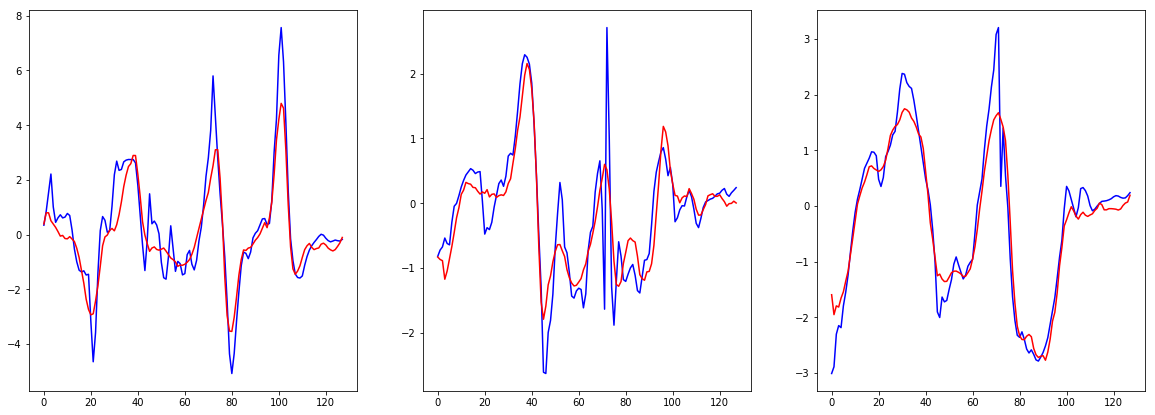

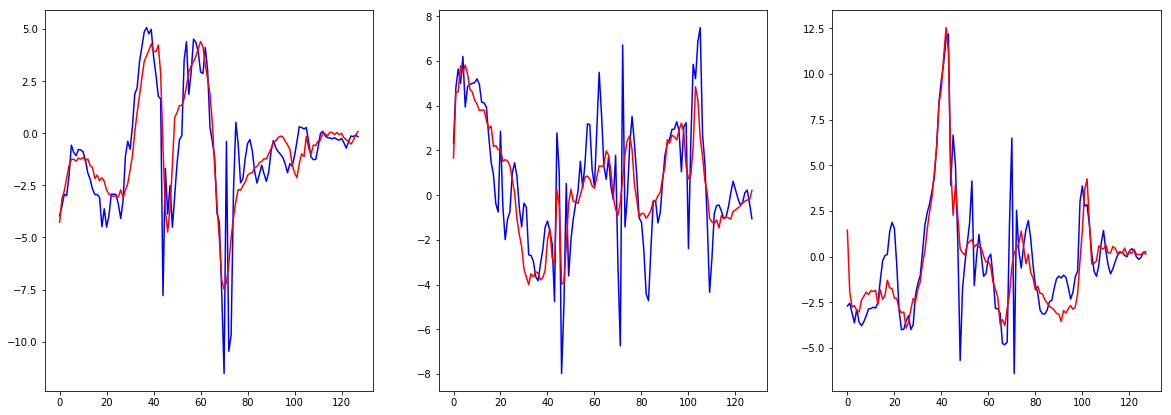

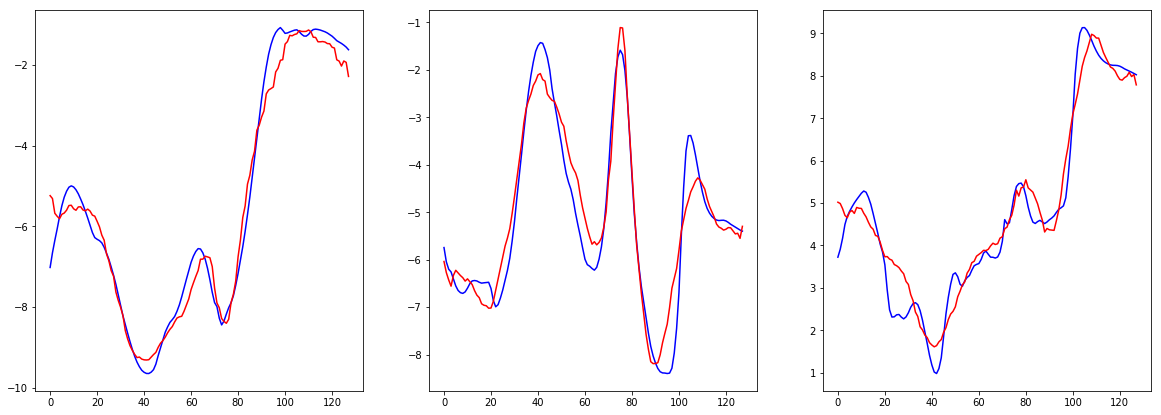

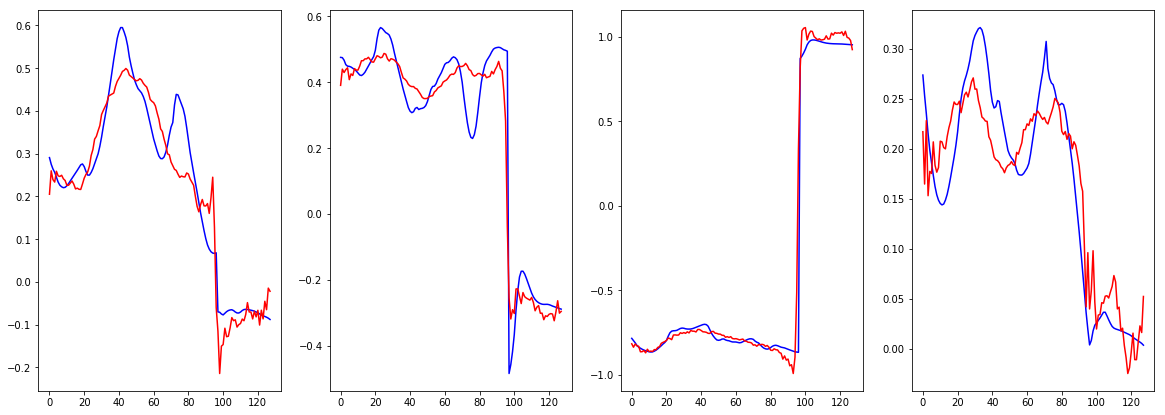

In [220]:
sample = 33
gyroy = gyroModel.predict(gyro_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gyro_train[sample,:,channel],'b')
    plot(gyroy[0,:,channel],'r')
linearAccy = linearAccModel.predict(linearAcc_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(linearAcc_train[sample,:,channel],'b')
    plot(linearAccy[0,:,channel],'r')
gravityy = gravityModel.predict(gravity_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gravity_train[sample,:,channel],'b')
    plot(gravityy[0,:,channel],'r')
gameVecy = gameVecModel.predict(gameVec_train[sample].reshape(1,128,4))
fig=plt.figure(figsize=(20,7))
for channel in range(4):
    plt.subplot(1,4,channel+1)
    plot(gameVec_train[sample,:,channel],'b')
    plot(gameVecy[0,:,channel],'r')